In [3]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

    

cuda:0


In [4]:
lr_tune = np.array([0.05,0.1,0.25,0.5,1]).reshape(-1,1)
n_value = np.array([1.0,3.0,5.0,8.0,10.0]).reshape(-1,1)
r_value = np.array([2,6,8]).reshape(-1,1)

LR_tune,N_value,R_value = np.meshgrid(lr_tune,n_value,r_value)

LR_tune = LR_tune.flatten('F').reshape(-1,1)
N_value = N_value.flatten('F').reshape(-1,1)
R_value = R_value.flatten('F').reshape(-1,1)


lrnr_tune = np.hstack((LR_tune,N_value,R_value))

In [3]:
# def true_2D_1(xt): #True function for 2D_1 Klein Gordon Equation x \in [-50,50] , t \in [0,10]
#     y = xt[:,0]*np.cos(xt[:,1])
#     return y.reshape(-1,1)    

In [4]:
loss_thresh = 0.5


x = np.linspace(0,1,500).reshape(-1,1)
y = np.linspace(0,1,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

# bound_pts_1 = (X == 0).reshape(-1,)
# bound_pts_2 = np.logical_and(Y == 0,X != 0).reshape(-1,)
# bound_pts_3 = np.logical_and(X == 1,Y != 0).reshape(-1,) 
# bound_pts_4 = np.logical_and(Y == 1,X != 1).reshape(-1,) 

# xy_bound_1 = xy[bound_pts_1,:]
# xy_bound_2 = xy[bound_pts_2,:]
# xy_bound_3 = xy[bound_pts_3,:]
# xy_bound_4 = xy[bound_pts_4,:]

# u_bound_1 = 1000*np.ones((np.shape(xy_bound_1)[0],1))
# u_bound_2 = 800*np.ones((np.shape(xy_bound_2)[0],1))
# u_bound_3 = 500*np.ones((np.shape(xy_bound_3)[0],1))
# u_bound_4 = np.zeros((np.shape(xy_bound_4)[0],1))

# xy_bound = np.vstack((xy_bound_1,xy_bound_2,xy_bound_3,xy_bound_4))
# u_bound = np.vstack((u_bound_1,u_bound_2,u_bound_3,u_bound_4))

xy_test_tensor = torch.from_numpy(xy).float().to(device)

lb_xy = xy[0]
ub_xy = xy[-1]

In [5]:
fea_data = scipy.io.loadmat('./../ES_FEA.mat')

xy = np.array(fea_data['xy'])
u_true = np.array(fea_data['u'])

xy_test_tensor = torch.from_numpy(xy).float().to(device)
u_true_norm = np.linalg.norm(u_true,2)

In [6]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    N_t = int(N_T/4)
    
    x_BC1 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC1 = np.zeros((N_t,1))
    u_BC1 = 0*np.ones((N_t,1))
    
    x_BC2 = np.ones((N_t,1))
    y_BC2 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC2 = 1000*np.ones((N_t,1))
    
    x_BC3 = np.random.uniform(size = N_t).reshape(-1,1)
    y_BC3 = np.ones((N_t,1)) 
    u_BC3 = 0*np.ones((N_t,1))
    
    x_BC4 = np.zeros((N_t,1))
    y_BC4 = np.random.uniform(size = N_t).reshape(-1,1) 
    u_BC4 = 1000*np.ones((N_t,1))
    
    XY_1 = np.hstack((x_BC1,y_BC1))
    XY_2 = np.hstack((x_BC2,y_BC2))
    XY_3 = np.hstack((x_BC3,y_BC3))
    XY_4 = np.hstack((x_BC4,y_BC4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4)) #choose indices from  set 'idx' (x,t)
    u_BC = np.vstack((u_BC1,u_BC2,u_BC3,u_BC4))
    
    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [7]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   

        
        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        self.omega1.requiresGrad = True
        
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.alpha.requiresGrad = True
        
        
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        self.omega.requiresGrad = True
        
        self.n = torch.tensor(n_val)
            
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = (xy - lbxy)/(ubxy - lbxy)
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
                
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
        
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f = d2u_dx2 + d2u_dy2
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
     
    'callable for optimizer'  
    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        #self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))) #Commented because no true values yet
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        #print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1])
        print(self.iter,"Train Loss",self.train_loss[-1])
        
        loss.backward()
        
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
     
        
        return test_mse, test_re 

In [8]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(PINN.alpha.cpu().detach().numpy())
    omega_val.append(PINN.omega.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [9]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [10]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,rep*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    
    nan_flag = 0
    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
        if(np.isnan(loss_np)):
            nan_flag =1
            print("NAN BREAK!")
            break
            
    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))
    
    return nan_flag

In [11]:
nan_tune = []
for tune_reps in range(75):      
    
    max_reps = 10
    max_iter = 100 #200

    label = "MW_rowdy_tune" + str(tune_reps)

    train_loss_full = []
    test_mse_full = []
    test_re_full = []
    alpha_full = []
    omega_full = []
    elapsed_time= np.zeros((max_reps,1))

    n_val = lrnr_tune[tune_reps,1]
    rowdy_terms = int(lrnr_tune[tune_reps,2])

    N_T = 5000 #Total number of data points for 'y'
    N_f = 10000 #Total number of collocation points 


    for reps in range(max_reps):
        print(label)
        print(reps)
        train_loss = []
        test_mse_loss = []
        test_re_loss = []

        alpha_val = []    
        omega_val = []

        torch.manual_seed(reps*36)

        layers = np.array([2,50,50,50,50,50,50,50,50,50,1]) #9 hidden layers

        PINN = Sequentialmodel(layers,n_val,rowdy_terms)

        PINN.to(device)

        'Neural Network Summary'
        print(PINN)

        params = list(PINN.parameters())

        optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lrnr_tune[tune_reps,0], 
                                  max_iter = 20, 
                                  max_eval = 30, 
                                  tolerance_grad = 1e-08, 
                                  tolerance_change = 1e-08, 
                                  history_size = 100, 
                                  line_search_fn = 'strong_wolfe')





        nan_flag = train_model(max_iter,reps)


        torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
        train_loss_full.append(train_loss)
        test_mse_full.append(test_mse_loss)
        test_re_full.append(test_re_loss)
        #elapsed_time[reps] = time.time() - start_time
        alpha_full.append(alpha_val)
        omega_full.append(omega_val)
        
        if(nan_flag == 1):
            nan_tune.append(tune_reps)
            break


        print('Training time: %.2f' % (elapsed_time[reps]))

    mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time,"alpha": alpha_full,"omega": omega_full,  "label": label}
    savemat(label+'.mat', mdic)

MW_rowdy_tune0
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 427274.78 Test MSE 246383.54999599807 Test RE 0.8684441540636494
1 Train Loss 254834.08 Test MSE 80145.02195462272 Test RE 0.4953068314252529
2 Train Loss 246147.88 Test MSE 73750.943507578 Test RE 0.475138073202998
3 Train Loss 238869.1 Test MSE 68799.89095812164 Test 

96 Train Loss 42989.293 Test MSE 6075.991627511597 Test RE 0.13637809673294266
97 Train Loss 42989.293 Test MSE 6075.991627511597 Test RE 0.13637809673294266
98 Train Loss 42989.293 Test MSE 6075.991627511597 Test RE 0.13637809673294266
99 Train Loss 42989.293 Test MSE 6075.991627511597 Test RE 0.13637809673294266
Training time: 178.39
Training time: 178.39
MW_rowdy_tune0
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, b

/home/smartlab/anaconda3/lib/python3.7/site-packages/scipy/io/matlab/mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


0 Train Loss 392725.03 Test MSE 215803.94196974998 Test RE 0.8127663758774024
1 Train Loss 290630.7 Test MSE 108601.28972018875 Test RE 0.5765719804812978
2 Train Loss 249750.86 Test MSE 74994.06762981575 Test RE 0.4791257332346312
3 Train Loss 249396.12 Test MSE 74846.81293732699 Test RE 0.47865510813957307
4 Train Loss 248689.28 Test MSE 74388.07726447114 Test RE 0.4771860165060365
5 Train Loss 247904.19 Test MSE 73899.54417965777 Test RE 0.4756165098408074
6 Train Loss 246888.94 Test MSE 73533.34997043447 Test RE 0.4744366357734752
7 Train Loss 244992.78 Test MSE 72625.12651330866 Test RE 0.47149760691143233
8 Train Loss 241676.03 Test MSE 72372.50944635952 Test RE 0.47067687100012723
9 Train Loss 235637.84 Test MSE 69381.2381969056 Test RE 0.4608473185714718
10 Train Loss 233025.48 Test MSE 67937.60007027749 Test RE 0.4560276150130965
11 Train Loss 230843.89 Test MSE 67176.45864169754 Test RE 0.4534658584482639
12 Train Loss 228429.7 Test MSE 64196.56528528884 Test RE 0.44329408675

0 Train Loss 455543.3 Test MSE 282070.12398684426 Test RE 0.9292115225404444
1 Train Loss 251891.83 Test MSE 75536.42368466296 Test RE 0.480855127450663
2 Train Loss 250104.61 Test MSE 75034.69700491638 Test RE 0.4792555031209261
3 Train Loss 249935.6 Test MSE 75017.2647297306 Test RE 0.47919982888326845
4 Train Loss 249442.62 Test MSE 74897.4464397094 Test RE 0.47881698468522677
5 Train Loss 248738.39 Test MSE 74480.14514604086 Test RE 0.47748122456814346
6 Train Loss 246266.84 Test MSE 73379.93251285053 Test RE 0.4739414531989468
7 Train Loss 241592.67 Test MSE 71783.48192433258 Test RE 0.46875757839822907
8 Train Loss 238182.39 Test MSE 70364.48330314425 Test RE 0.4641013089533689
9 Train Loss 234351.83 Test MSE 68974.93655528163 Test RE 0.4594959593295225
10 Train Loss 231363.67 Test MSE 67926.33060159379 Test RE 0.45598979058258643
11 Train Loss 225541.08 Test MSE 65778.96465845895 Test RE 0.4487242688648655
12 Train Loss 223396.53 Test MSE 64306.82696712214 Test RE 0.443674616315

0 Train Loss 453175.66 Test MSE 279665.0651899727 Test RE 0.9252416010153299
1 Train Loss 254400.89 Test MSE 79513.56621733133 Test RE 0.4933517328266156
2 Train Loss 249993.11 Test MSE 75074.18444371904 Test RE 0.47938159201026265
3 Train Loss 249806.75 Test MSE 74981.65816803082 Test RE 0.479086090509231
4 Train Loss 249710.3 Test MSE 74946.17340645478 Test RE 0.47897271433222405
5 Train Loss 249350.55 Test MSE 74686.75050012657 Test RE 0.4781430241588522
6 Train Loss 248903.66 Test MSE 74383.0585147117 Test RE 0.4771699190500405
7 Train Loss 247702.77 Test MSE 73900.49976721223 Test RE 0.4756195849054324
8 Train Loss 241888.14 Test MSE 70891.16806677303 Test RE 0.465834991741541
9 Train Loss 229831.48 Test MSE 67173.3178992902 Test RE 0.4534552577398614
10 Train Loss 217700.61 Test MSE 62297.84815059414 Test RE 0.43668931409900563
11 Train Loss 209126.47 Test MSE 58205.61961613369 Test RE 0.4221030597003361
12 Train Loss 201649.03 Test MSE 56002.57623488778 Test RE 0.414037850066528

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 2.79
MW_rowdy_tune2
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 415119.06 Test MSE 239396.2805136441 Test RE 0.8560413457994372
1 Train Loss 252114.28 Test MSE 77029.202966091 Test RE 0.4855833018983381
2 Train Loss 249953.83 Test MSE 75058.51903464565 Test RE 

95 Train Loss 49225.387 Test MSE 6485.259585174032 Test RE 0.14089634395283887
96 Train Loss 48702.344 Test MSE 6517.994079322409 Test RE 0.14125148510945387
97 Train Loss 48563.797 Test MSE 6532.357627767192 Test RE 0.14140703572901034
98 Train Loss 48496.62 Test MSE 6531.367504988993 Test RE 0.14139631864638363
99 Train Loss 48209.703 Test MSE 6530.23769062142 Test RE 0.14138408855051363
Training time: 180.31
Training time: 180.31
MW_rowdy_tune2
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, o

90 Train Loss 50772.98 Test MSE 6757.382850104604 Test RE 0.14382199360178904
91 Train Loss 50539.164 Test MSE 6766.781741385218 Test RE 0.143921980356466
92 Train Loss 50368.367 Test MSE 6712.661349932423 Test RE 0.1433452844435091
93 Train Loss 50159.543 Test MSE 6672.123040580355 Test RE 0.1429117920466914
94 Train Loss 50082.938 Test MSE 6623.731466614305 Test RE 0.1423925936004497
95 Train Loss 49998.434 Test MSE 6626.565992479232 Test RE 0.14242305772180766
96 Train Loss 49962.824 Test MSE 6619.511380049956 Test RE 0.1423472260597461
97 Train Loss 49868.61 Test MSE 6588.896665337045 Test RE 0.14201767226722184
98 Train Loss 49635.445 Test MSE 6536.864009407238 Test RE 0.14145580251766088
99 Train Loss 49516.465 Test MSE 6530.411453315324 Test RE 0.141385969578268
Training time: 181.05
Training time: 181.05
MW_rowdy_tune2
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1

85 Train Loss 79282.16 Test MSE 12697.691841763697 Test RE 0.19715074991475698
86 Train Loss 78817.5 Test MSE 12668.191689556086 Test RE 0.19692159964271394
87 Train Loss 77514.21 Test MSE 12005.311279215115 Test RE 0.19170028317453555
88 Train Loss 75347.445 Test MSE 11992.422008562417 Test RE 0.19159734788468297
89 Train Loss 74044.54 Test MSE 11956.212100803059 Test RE 0.19130787478458341
90 Train Loss 73145.25 Test MSE 12285.94805642542 Test RE 0.19392793780138198
91 Train Loss 72533.2 Test MSE 12320.989147900735 Test RE 0.1942042945019088
92 Train Loss 72009.87 Test MSE 12396.431942132529 Test RE 0.19479795443240006
93 Train Loss 70097.92 Test MSE 11287.945388837128 Test RE 0.18588463442772704
94 Train Loss 68937.11 Test MSE 10799.624163907354 Test RE 0.18181945967568178
95 Train Loss 68559.305 Test MSE 11185.630625054975 Test RE 0.1850402807807988
96 Train Loss 67931.625 Test MSE 11219.988091792375 Test RE 0.1853242451408369
97 Train Loss 67410.14 Test MSE 10986.421786996627 Test

80 Train Loss 65783.25 Test MSE 9443.285950810969 Test RE 0.1700190605744382
81 Train Loss 65686.23 Test MSE 9581.094850194339 Test RE 0.17125513861667802
82 Train Loss 65456.766 Test MSE 9708.846834750948 Test RE 0.1723930950177852
83 Train Loss 65300.03 Test MSE 9586.058050532054 Test RE 0.17129948968133957
84 Train Loss 65229.09 Test MSE 9428.169134136378 Test RE 0.16988292277343847
85 Train Loss 65121.316 Test MSE 9583.850524600075 Test RE 0.17127976468924258
86 Train Loss 64700.348 Test MSE 9320.949794174492 Test RE 0.1689141866003215
87 Train Loss 64341.668 Test MSE 9167.166501297308 Test RE 0.16751496138172084
88 Train Loss 64324.33 Test MSE 9146.235926886782 Test RE 0.16732361610664767
89 Train Loss 64200.992 Test MSE 9234.510776041272 Test RE 0.16812913866115287
90 Train Loss 63566.863 Test MSE 8936.538605411666 Test RE 0.16539436528300627
91 Train Loss 62928.344 Test MSE 8839.943665899924 Test RE 0.16449806381075757
92 Train Loss 62495.46 Test MSE 9096.24178609571 Test RE 0.1

65 Train Loss 145987.23 Test MSE 41063.298877831745 Test RE 0.3545381383217797
66 Train Loss 142801.19 Test MSE 40469.33218314709 Test RE 0.35196466132797516
67 Train Loss 141870.52 Test MSE 40101.041529568436 Test RE 0.35035947598016176
68 Train Loss 140586.02 Test MSE 40354.15467717975 Test RE 0.35146345097512827
69 Train Loss 138427.53 Test MSE 38912.28636281722 Test RE 0.3451273815505059
70 Train Loss 137489.64 Test MSE 38932.28350430225 Test RE 0.3452160511619413
71 Train Loss 136834.75 Test MSE 37923.34586126039 Test RE 0.3407135183724169
72 Train Loss 135579.77 Test MSE 37539.98528447332 Test RE 0.338987036953205
73 Train Loss 135333.92 Test MSE 37541.79976910715 Test RE 0.33899522927577286
74 Train Loss 135100.16 Test MSE 37769.97819463038 Test RE 0.34002387226659514
75 Train Loss 134672.56 Test MSE 37218.128129349454 Test RE 0.33753071950782343
76 Train Loss 134355.0 Test MSE 36847.22823410136 Test RE 0.335844665205661
77 Train Loss 133415.48 Test MSE 34876.11672015924 Test RE

60 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
61 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
62 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
63 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
64 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
65 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
66 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
67 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
68 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
69 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
70 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
71 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.4672666640810065
72 Train Loss 237349.98 Test MSE 71327.58391228691 Test RE 0.467

46 Train Loss 213250.86 Test MSE 59409.463293691 Test RE 0.42644581459328357
47 Train Loss 213153.69 Test MSE 59446.85911443575 Test RE 0.42658000855501915
48 Train Loss 212981.2 Test MSE 59276.74368198248 Test RE 0.4259692123425289
49 Train Loss 212603.52 Test MSE 59157.36334222012 Test RE 0.4255400560203207
50 Train Loss 212487.22 Test MSE 58958.38499448291 Test RE 0.4248237920339773
51 Train Loss 212117.16 Test MSE 59046.92086398 Test RE 0.42514264434121213
52 Train Loss 212006.56 Test MSE 58897.36173073894 Test RE 0.4246038839937664
53 Train Loss 209441.58 Test MSE 58449.54641753421 Test RE 0.4229866049865852
54 Train Loss 208683.3 Test MSE 58332.907137158305 Test RE 0.4225643477200244
55 Train Loss 208449.28 Test MSE 58177.29068463333 Test RE 0.42200032748936406
56 Train Loss 208246.39 Test MSE 58220.175055154024 Test RE 0.4221558339112662
57 Train Loss 208138.98 Test MSE 58305.11853136234 Test RE 0.4224636852169836
58 Train Loss 207831.34 Test MSE 58392.565391586904 Test RE 0.422

32 Train Loss 166413.23 Test MSE 43890.54537206991 Test RE 0.36654013080202996
33 Train Loss 163940.5 Test MSE 42879.16890146817 Test RE 0.362292398082815
34 Train Loss 162391.97 Test MSE 42387.28562095884 Test RE 0.36020840722713776
35 Train Loss 161823.77 Test MSE 41995.647528783375 Test RE 0.3585404695043172
36 Train Loss 160075.28 Test MSE 41573.82765821359 Test RE 0.3567352682616627
37 Train Loss 158296.45 Test MSE 40922.12715456376 Test RE 0.3539281793941658
38 Train Loss 156434.69 Test MSE 40572.471511906326 Test RE 0.35241288096901435
39 Train Loss 154993.52 Test MSE 39815.01806357353 Test RE 0.3491077583378211
40 Train Loss 153566.45 Test MSE 39998.19648869995 Test RE 0.34990991325385534
41 Train Loss 152152.17 Test MSE 39830.90969015184 Test RE 0.34917742220989745
42 Train Loss 150416.84 Test MSE 40115.71573264801 Test RE 0.3504235737648621
43 Train Loss 148759.42 Test MSE 39703.288569354794 Test RE 0.34861757852408704
44 Train Loss 148027.62 Test MSE 39616.75761548853 Test R

27 Train Loss 77676.984 Test MSE 13262.351854072785 Test RE 0.20148666787134006
28 Train Loss 74259.664 Test MSE 12440.445089018327 Test RE 0.19514346007318303
29 Train Loss 72513.45 Test MSE 11941.625722170234 Test RE 0.1911911429684962
30 Train Loss 70857.805 Test MSE 11520.352781286212 Test RE 0.18778847324705164
31 Train Loss 69309.37 Test MSE 11045.330616748053 Test RE 0.18387614997414442
32 Train Loss 66885.79 Test MSE 10402.867852370107 Test RE 0.17844836891032184
33 Train Loss 64411.17 Test MSE 9332.603778347508 Test RE 0.1690197503236471
34 Train Loss 62972.844 Test MSE 9155.803832305304 Test RE 0.16741111210383633
35 Train Loss 62340.484 Test MSE 9083.130817230907 Test RE 0.16674538636100183
36 Train Loss 61395.387 Test MSE 8953.513069241473 Test RE 0.16555136951562294
37 Train Loss 60420.97 Test MSE 8552.85825693534 Test RE 0.16180490365591396
38 Train Loss 59427.707 Test MSE 8174.327138359549 Test RE 0.15818381629379938
39 Train Loss 58472.027 Test MSE 7936.782514551224 Tes

22 Train Loss 195502.03 Test MSE 53283.91549786265 Test RE 0.4038630374603881
23 Train Loss 193863.7 Test MSE 52675.53495662037 Test RE 0.401550822004024
24 Train Loss 192528.6 Test MSE 52166.77629938129 Test RE 0.39960695816166564
25 Train Loss 191102.45 Test MSE 51609.657703990335 Test RE 0.39746741579125255
26 Train Loss 188817.7 Test MSE 50452.95973207504 Test RE 0.3929880694804298
27 Train Loss 186488.86 Test MSE 48852.53274933411 Test RE 0.3867048189657483
28 Train Loss 183744.11 Test MSE 48634.25739343123 Test RE 0.3858399443798381
29 Train Loss 180545.94 Test MSE 47670.64446906075 Test RE 0.3819984084539512
30 Train Loss 178558.92 Test MSE 46788.93462958774 Test RE 0.3784492249167204
31 Train Loss 175502.42 Test MSE 44610.583406653845 Test RE 0.36953450223155876
32 Train Loss 172453.98 Test MSE 44596.268535806965 Test RE 0.3694752084194787
33 Train Loss 169893.28 Test MSE 43774.77482080087 Test RE 0.3660563982335772
34 Train Loss 167654.06 Test MSE 42940.49521439153 Test RE 0.3

17 Train Loss 126706.516 Test MSE 27893.43085170253 Test RE 0.2922045737124711
18 Train Loss 117216.47 Test MSE 24419.627684305844 Test RE 0.27340443863414965
19 Train Loss 111597.266 Test MSE 22337.8478624595 Test RE 0.261490976099799
20 Train Loss 106773.68 Test MSE 21132.59488896085 Test RE 0.254338705005845
21 Train Loss 101202.56 Test MSE 19803.25109203006 Test RE 0.24620920673155533
22 Train Loss 95216.89 Test MSE 17972.136071704503 Test RE 0.23455024497952773
23 Train Loss 89486.5 Test MSE 16148.62060964355 Test RE 0.22233291271712774
24 Train Loss 84748.53 Test MSE 14492.929609043065 Test RE 0.210627044242016
25 Train Loss 82276.13 Test MSE 13752.858583791589 Test RE 0.20517882126203063
26 Train Loss 78500.56 Test MSE 12882.846388661952 Test RE 0.19858294912777896
27 Train Loss 75868.67 Test MSE 12715.651727674593 Test RE 0.19729012775826596
28 Train Loss 72554.46 Test MSE 12232.795079881746 Test RE 0.19350798567265337
29 Train Loss 69820.88 Test MSE 10791.803980027233 Test RE 

2 Train Loss 243332.83 Test MSE 71979.2968847416 Test RE 0.46939649442835085
3 Train Loss 239491.72 Test MSE 71116.78560802489 Test RE 0.4665756838343735
4 Train Loss 234055.61 Test MSE 68001.1918245039 Test RE 0.45624099326771916
5 Train Loss 228345.84 Test MSE 66207.52196971783 Test RE 0.45018364012991635
6 Train Loss 214194.88 Test MSE 60480.346729147 Test RE 0.43027209188486587
7 Train Loss 197100.23 Test MSE 52928.86107165072 Test RE 0.4025152289302485
8 Train Loss 179348.58 Test MSE 49103.412359427544 Test RE 0.3876964985364591
9 Train Loss 170392.66 Test MSE 46647.91565424873 Test RE 0.37787848318672124
10 Train Loss 164443.1 Test MSE 42422.70819393943 Test RE 0.360358886831759
11 Train Loss 154270.08 Test MSE 38002.135975155405 Test RE 0.3410672704933702
12 Train Loss 145297.64 Test MSE 36130.10032377932 Test RE 0.3325604702394288
13 Train Loss 138824.16 Test MSE 33045.694454279015 Test RE 0.3180485964242329
14 Train Loss 132650.38 Test MSE 31997.16165564776 Test RE 0.312962116

0 Train Loss 371215.34 Test MSE 187312.18670972364 Test RE 0.7572147389790539
1 Train Loss 270188.34 Test MSE 94277.14408464957 Test RE 0.5372040162425136
2 Train Loss 249723.73 Test MSE 74874.71263866243 Test RE 0.478744310937835
3 Train Loss 246149.14 Test MSE 73589.21941559383 Test RE 0.474616836177252
4 Train Loss 240841.27 Test MSE 71330.13499034963 Test RE 0.4672750200564407
5 Train Loss 234030.89 Test MSE 68456.40046550427 Test RE 0.4577655138550631
6 Train Loss 224229.52 Test MSE 65854.05657009808 Test RE 0.4489803230021393
7 Train Loss 212428.5 Test MSE 62410.49693921593 Test RE 0.4370839529664867
8 Train Loss 201025.7 Test MSE 58356.28133268915 Test RE 0.4226490007308525
9 Train Loss 183322.78 Test MSE 51430.484102719965 Test RE 0.3967768707561474
10 Train Loss 165871.8 Test MSE 45199.53854784155 Test RE 0.3719658268793109
11 Train Loss 157688.86 Test MSE 40816.54998854962 Test RE 0.3534713254987586
12 Train Loss 149725.53 Test MSE 36822.9567602267 Test RE 0.33573403561150933

0 Train Loss 435666.0 Test MSE 262023.92704954927 Test RE 0.895584394638559
1 Train Loss 273506.1 Test MSE 96558.95331482297 Test RE 0.543666178745085
2 Train Loss 249935.73 Test MSE 75036.40128530808 Test RE 0.47926094581045015
3 Train Loss 247824.75 Test MSE 73893.77002805946 Test RE 0.475597928295357
4 Train Loss 242122.5 Test MSE 71962.98008826682 Test RE 0.46934328828784544
5 Train Loss 235409.06 Test MSE 68986.50299270813 Test RE 0.45953448425421256
6 Train Loss 230072.81 Test MSE 66476.56236548435 Test RE 0.4510973942423191
7 Train Loss 219589.77 Test MSE 61502.662513547155 Test RE 0.43389335642443044
8 Train Loss 201795.84 Test MSE 56044.91816226983 Test RE 0.4141943415113037
9 Train Loss 188610.16 Test MSE 51137.563243110846 Test RE 0.3956453416156622
10 Train Loss 178310.16 Test MSE 47376.912885084355 Test RE 0.3808197126714614
11 Train Loss 172832.3 Test MSE 44626.11793023017 Test RE 0.36959883722042963
12 Train Loss 168535.78 Test MSE 42217.49067201731 Test RE 0.35948622201

0 Train Loss 278467.8 Test MSE 103936.36893758706 Test RE 0.5640528683809926
1 Train Loss 250103.33 Test MSE 75212.7372397745 Test RE 0.4798237482825435
2 Train Loss 249726.62 Test MSE 74926.32763104758 Test RE 0.4789092940544654
3 Train Loss 247982.75 Test MSE 73912.6374002268 Test RE 0.4756586418737513
4 Train Loss 241797.45 Test MSE 71178.59787412279 Test RE 0.4667784055694276
5 Train Loss 206832.22 Test MSE 57714.511340449244 Test RE 0.42031854619382175
6 Train Loss 190974.94 Test MSE 48021.26254181844 Test RE 0.38340063590930573
7 Train Loss 175170.08 Test MSE 43302.897916217655 Test RE 0.36407807180244106
8 Train Loss 154433.2 Test MSE 35234.20497687416 Test RE 0.32841144229620006
9 Train Loss 141969.62 Test MSE 33225.324415093564 Test RE 0.3189118500164004
10 Train Loss 126191.49 Test MSE 27914.37897622751 Test RE 0.2923142767642128
11 Train Loss 111014.375 Test MSE 21947.44934277376 Test RE 0.259195865369733
12 Train Loss 99545.53 Test MSE 18391.945792022772 Test RE 0.237273852

0 Train Loss 439561.66 Test MSE 265961.31829618127 Test RE 0.902288205324818
1 Train Loss 250488.12 Test MSE 75640.23161107885 Test RE 0.48118542794170127
2 Train Loss 250006.52 Test MSE 75096.33873723596 Test RE 0.479452319232787
3 Train Loss 249999.84 Test MSE 75081.7974000956 Test RE 0.4794058974266921
4 Train Loss 249999.84 Test MSE 75081.74808604943 Test RE 0.47940573998874264
5 Train Loss 249999.84 Test MSE 75081.7044504758 Test RE 0.4794056006796026
6 Train Loss 249999.84 Test MSE 75081.66397453005 Test RE 0.4794054714577247
7 Train Loss 249999.84 Test MSE 75081.62744285092 Test RE 0.47940535482812396
8 Train Loss 249999.81 Test MSE 75081.5941082441 Test RE 0.47940524840534565
9 Train Loss 249999.81 Test MSE 75081.5941082441 Test RE 0.47940524840534565
10 Train Loss 249999.81 Test MSE 75081.5941082441 Test RE 0.47940524840534565
11 Train Loss 249999.81 Test MSE 75081.5941082441 Test RE 0.47940524840534565
12 Train Loss 249999.81 Test MSE 75081.5941082441 Test RE 0.47940524840534

0 Train Loss 272453.1 Test MSE 93518.78936651761 Test RE 0.5350390494939596
1 Train Loss 249670.44 Test MSE 74863.03034892927 Test RE 0.4787069615596337
2 Train Loss 247630.78 Test MSE 73859.05683302716 Test RE 0.47548620397125285
3 Train Loss 238453.27 Test MSE 70311.97421283042 Test RE 0.4639281101710692
4 Train Loss 224987.88 Test MSE 63174.37657176429 Test RE 0.43975068462529987
5 Train Loss 207990.8 Test MSE 57381.071874996946 Test RE 0.41910261451950437
6 Train Loss 192000.36 Test MSE 51266.46974296776 Test RE 0.39614369500464985
7 Train Loss 177528.17 Test MSE 45074.453962239844 Test RE 0.37145078372726437
8 Train Loss 165144.4 Test MSE 39612.04518123932 Test RE 0.34821676354698844
9 Train Loss 151476.78 Test MSE 34084.46831677323 Test RE 0.3230087623799624
10 Train Loss 138812.53 Test MSE 32610.28340714044 Test RE 0.31594633975834924
11 Train Loss 125924.78 Test MSE 28893.282930052625 Test RE 0.29739556453065474
12 Train Loss 116031.0 Test MSE 24395.83096027647 Test RE 0.273271

0 Train Loss 377501.03 Test MSE 202853.19745048202 Test RE 0.7880013665631627
1 Train Loss 259385.92 Test MSE 81258.61605541928 Test RE 0.4987360399141866
2 Train Loss 247290.94 Test MSE 73957.11383237029 Test RE 0.47580173254437325
3 Train Loss 240441.36 Test MSE 71229.1427201481 Test RE 0.46694410885919113
4 Train Loss 236186.55 Test MSE 69420.83096405353 Test RE 0.46097879228624095
5 Train Loss 226439.55 Test MSE 65657.84517762104 Test RE 0.4483109582245696
6 Train Loss 221874.5 Test MSE 63982.58805858125 Test RE 0.4425546857251429
7 Train Loss 215113.81 Test MSE 60322.50869646018 Test RE 0.42971027576508986
8 Train Loss 211554.38 Test MSE 59102.039930482126 Test RE 0.42534102894138986
9 Train Loss 207876.0 Test MSE 58459.88226329712 Test RE 0.42302400246285443
10 Train Loss 202469.84 Test MSE 56116.58594872039 Test RE 0.4144590836938002
11 Train Loss 199046.4 Test MSE 55216.36375367599 Test RE 0.4111212672343505
12 Train Loss 196091.45 Test MSE 53814.87775165872 Test RE 0.405870251

0 Train Loss 433567.75 Test MSE 251818.14436726618 Test RE 0.8779697474397457
1 Train Loss 250007.25 Test MSE 75083.87505944814 Test RE 0.4794125304275686
2 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
3 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
4 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
5 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
6 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
7 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
8 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
9 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
10 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
11 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47940991942109495
12 Train Loss 250000.34 Test MSE 75083.05720869312 Test RE 0.47

0 Train Loss 363584.03 Test MSE 189575.3387387147 Test RE 0.7617754320843643
1 Train Loss 272216.88 Test MSE 93565.20967939231 Test RE 0.5351718228058198
2 Train Loss 248456.64 Test MSE 74180.23495802443 Test RE 0.47651891486563464
3 Train Loss 238789.67 Test MSE 69462.08705425197 Test RE 0.46111574943319156
4 Train Loss 223052.66 Test MSE 62470.78553980021 Test RE 0.43729501376883373
5 Train Loss 209971.78 Test MSE 59859.355552680834 Test RE 0.4280574502889092
6 Train Loss 199447.16 Test MSE 54204.17514623572 Test RE 0.4073356411997767
7 Train Loss 190833.8 Test MSE 50661.770139700944 Test RE 0.3938004625385492
8 Train Loss 182032.17 Test MSE 48468.85689738709 Test RE 0.38518328306822575
9 Train Loss 176640.06 Test MSE 45973.44486678294 Test RE 0.3751367102261899
10 Train Loss 165034.19 Test MSE 41429.999500165744 Test RE 0.3561176557762184
11 Train Loss 160671.2 Test MSE 40356.73008593782 Test RE 0.35147466602368505
12 Train Loss 154053.72 Test MSE 38063.57406806835 Test RE 0.3413428

0 Train Loss 387415.7 Test MSE 208520.36492912876 Test RE 0.7989328526411013
1 Train Loss 249190.16 Test MSE 74942.82158688277 Test RE 0.47896200365817826
2 Train Loss 244742.39 Test MSE 72903.36785190299 Test RE 0.47239994414532027
3 Train Loss 242192.28 Test MSE 72095.56089800861 Test RE 0.46977543603287514
4 Train Loss 241008.62 Test MSE 71868.58488420006 Test RE 0.4690353640365415
5 Train Loss 238980.28 Test MSE 70977.75703091799 Test RE 0.4661193985372659
6 Train Loss 225754.38 Test MSE 64156.10416676201 Test RE 0.44315436742809355
7 Train Loss 208502.5 Test MSE 58161.28308910911 Test RE 0.4219422663866955
8 Train Loss 191974.86 Test MSE 52026.70999469554 Test RE 0.39907013094229543
9 Train Loss 183581.19 Test MSE 50857.69013754786 Test RE 0.3945611834652601
10 Train Loss 179162.14 Test MSE 47246.978719418905 Test RE 0.38029714311438534
11 Train Loss 174421.81 Test MSE 45675.03270197881 Test RE 0.37391722788665305
12 Train Loss 171777.98 Test MSE 44596.45921277211 Test RE 0.369475

0 Train Loss 389491.3 Test MSE 213802.75026425533 Test RE 0.8089891287713349
1 Train Loss 250326.11 Test MSE 75180.09780621759 Test RE 0.4797196244640154
2 Train Loss 249655.6 Test MSE 74943.4713729115 Test RE 0.4789640800554707
3 Train Loss 247512.81 Test MSE 73632.16443827092 Test RE 0.4747553038640889
4 Train Loss 238644.72 Test MSE 69755.35955583894 Test RE 0.46208815132828407
5 Train Loss 231386.16 Test MSE 66831.6568167435 Test RE 0.4523005915509175
6 Train Loss 220331.11 Test MSE 63231.70469606088 Test RE 0.43995016712590607
7 Train Loss 208051.02 Test MSE 56493.6237922597 Test RE 0.4158490930122487
8 Train Loss 197060.45 Test MSE 53520.19947245601 Test RE 0.40475749882119977
9 Train Loss 191821.03 Test MSE 52183.488051534325 Test RE 0.3996709605609305
10 Train Loss 184879.27 Test MSE 49543.00538282152 Test RE 0.38942803744146126
11 Train Loss 175163.05 Test MSE 46843.55868868363 Test RE 0.3786700720354532
12 Train Loss 167986.28 Test MSE 45299.62431475379 Test RE 0.372377422884

0 Train Loss 415217.06 Test MSE 238596.99678258406 Test RE 0.8546110980442961
1 Train Loss 312652.03 Test MSE 137354.95808874443 Test RE 0.6484227029426779
2 Train Loss 263653.28 Test MSE 87436.96407177763 Test RE 0.5173489557344916
3 Train Loss 250032.72 Test MSE 75037.07965459127 Test RE 0.4792631121934583
4 Train Loss 249840.94 Test MSE 74998.5165645768 Test RE 0.4791399448088541
5 Train Loss 249721.72 Test MSE 74952.62583993067 Test RE 0.4789933322832081
6 Train Loss 249637.42 Test MSE 74938.06615546544 Test RE 0.47894680735888817
7 Train Loss 249304.94 Test MSE 74766.01879805859 Test RE 0.47839669386681694
8 Train Loss 248553.9 Test MSE 74452.08524712294 Test RE 0.47739127215856536
9 Train Loss 247567.8 Test MSE 74028.73810917468 Test RE 0.47603207352324234
10 Train Loss 247120.73 Test MSE 74003.77447628649 Test RE 0.47595180407503235
11 Train Loss 244679.06 Test MSE 73028.1246067777 Test RE 0.47280397138013697
12 Train Loss 241340.86 Test MSE 71904.49380492869 Test RE 0.469152525

0 Train Loss 466956.25 Test MSE 293461.8825420414 Test RE 0.9477894963787568
1 Train Loss 263973.06 Test MSE 88526.5723262321 Test RE 0.5205624843347035
2 Train Loss 249955.33 Test MSE 75062.83611103347 Test RE 0.4793453586003899
3 Train Loss 249865.03 Test MSE 75018.63909784064 Test RE 0.47920421849910616
4 Train Loss 249335.03 Test MSE 74667.83184795314 Test RE 0.4780824619144318
5 Train Loss 243011.03 Test MSE 71876.53572792346 Test RE 0.4690613080825424
6 Train Loss 235829.48 Test MSE 68975.38788715095 Test RE 0.45949746266422176
7 Train Loss 228640.67 Test MSE 66888.59135503335 Test RE 0.4524932101722092
8 Train Loss 220127.62 Test MSE 61653.68711815208 Test RE 0.43442575934487426
9 Train Loss 207200.11 Test MSE 59631.03698436563 Test RE 0.4272403112098304
10 Train Loss 196331.1 Test MSE 55443.462931555194 Test RE 0.41196584927416613
11 Train Loss 186258.9 Test MSE 51009.379172900306 Test RE 0.39514915790639576
12 Train Loss 169748.23 Test MSE 43675.55546112021 Test RE 0.365641313

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 2.68
MW_rowdy_tune8
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 419297.78 Test MSE 241042.3823852091 Test RE 0.8589793973743641
1 Train Loss 249993.05 Test MSE 75082.53437197742 Test RE 0.4794082502459614
2 Train Loss 249980.95 Test MSE 75072.15876697659 Test R

95 Train Loss 160332.69 Test MSE 48955.07243106117 Test RE 0.38711044587292165
96 Train Loss 159732.86 Test MSE 48751.92135136656 Test RE 0.3863064059969726
97 Train Loss 159456.94 Test MSE 49146.70660283958 Test RE 0.3878673759519183
98 Train Loss 159415.1 Test MSE 49007.95207631206 Test RE 0.3873194613762507
99 Train Loss 159415.1 Test MSE 49007.95207631206 Test RE 0.3873194613762507
Training time: 165.34
Training time: 165.34
MW_rowdy_tune8
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_f

91 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
92 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
93 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
94 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
95 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
96 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
97 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
98 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
99 Train Loss 197630.78 Test MSE 55736.0537782038 Test RE 0.41305144909928226
Training time: 153.98
Training time: 153.98
MW_rowdy_tune8
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_featu

76 Train Loss 59038.16 Test MSE 8353.624671694712 Test RE 0.1599092259680578
77 Train Loss 58800.36 Test MSE 8409.44195184564 Test RE 0.1604425775417644
78 Train Loss 58545.29 Test MSE 8296.184190524364 Test RE 0.15935850053476153
79 Train Loss 58380.035 Test MSE 8167.113175075765 Test RE 0.1581140011211776
80 Train Loss 58303.62 Test MSE 8120.418405643998 Test RE 0.15766135157415193
81 Train Loss 58210.85 Test MSE 8098.85318832714 Test RE 0.1574518634992267
82 Train Loss 58184.953 Test MSE 8036.890644154246 Test RE 0.156848392240709
83 Train Loss 57909.445 Test MSE 8094.558040609227 Test RE 0.15741010643284095
84 Train Loss 57565.297 Test MSE 8061.745501699513 Test RE 0.15709073938656856
85 Train Loss 57440.637 Test MSE 8114.76411611554 Test RE 0.15760645180659522
86 Train Loss 57232.484 Test MSE 7943.731271384882 Test RE 0.15593669087290607
87 Train Loss 57002.027 Test MSE 8052.163484482778 Test RE 0.1569973542932979
88 Train Loss 56920.727 Test MSE 8078.668939905846 Test RE 0.157255

72 Train Loss 137166.56 Test MSE 29653.78822657263 Test RE 0.3012840444486451
73 Train Loss 135576.45 Test MSE 29787.8978080019 Test RE 0.3019645561035699
74 Train Loss 134395.89 Test MSE 29276.396464364287 Test RE 0.29936074553896447
75 Train Loss 133939.64 Test MSE 28956.997775001164 Test RE 0.29772328910279133
76 Train Loss 133199.83 Test MSE 28720.658348096742 Test RE 0.29650583013825516
77 Train Loss 132453.66 Test MSE 28437.61447927169 Test RE 0.2950411709563986
78 Train Loss 132079.78 Test MSE 28430.291463176643 Test RE 0.2950031802459359
79 Train Loss 131804.08 Test MSE 28275.680777696834 Test RE 0.29419993797973426
80 Train Loss 131603.61 Test MSE 28328.104203299354 Test RE 0.29447253666113454
81 Train Loss 131097.28 Test MSE 27938.59061261018 Test RE 0.29244101920394483
82 Train Loss 130937.45 Test MSE 27793.79184332609 Test RE 0.29168221019799717
83 Train Loss 130688.94 Test MSE 27644.924152181702 Test RE 0.2909000147096302
84 Train Loss 130637.17 Test MSE 27590.703165614705

67 Train Loss 46522.7 Test MSE 7853.697690481584 Test RE 0.15505048601683494
68 Train Loss 46189.656 Test MSE 7559.817721435579 Test RE 0.15212188697234105
69 Train Loss 45833.35 Test MSE 7528.204182246866 Test RE 0.1518034831681146
70 Train Loss 45680.08 Test MSE 7519.3096960717685 Test RE 0.1517137796345097
71 Train Loss 45392.69 Test MSE 7373.3087883752505 Test RE 0.15023366182078238
72 Train Loss 45203.734 Test MSE 7380.826616024849 Test RE 0.1503102314494143
73 Train Loss 45081.625 Test MSE 7430.399909714512 Test RE 0.15081416574413053
74 Train Loss 45063.645 Test MSE 7451.031352681146 Test RE 0.15102339788591088
75 Train Loss 45025.777 Test MSE 7399.04088174047 Test RE 0.15049558355505382
76 Train Loss 44938.92 Test MSE 7316.826499862714 Test RE 0.14965713271980297
77 Train Loss 44701.902 Test MSE 7355.276736396366 Test RE 0.15004984478623257
78 Train Loss 44605.117 Test MSE 7324.248471858972 Test RE 0.14973301736136463
79 Train Loss 44494.168 Test MSE 7302.410011581235 Test RE 0

62 Train Loss 58183.19 Test MSE 8305.287806676706 Test RE 0.15944591065133973
63 Train Loss 58093.57 Test MSE 8352.078424669218 Test RE 0.15989442576948348
64 Train Loss 57999.707 Test MSE 8466.570233442757 Test RE 0.16098662641071798
65 Train Loss 57701.67 Test MSE 8538.691555181225 Test RE 0.16167084368842166
66 Train Loss 57153.336 Test MSE 8454.199212270938 Test RE 0.16086896973620748
67 Train Loss 56782.453 Test MSE 8250.743082504154 Test RE 0.158921470095332
68 Train Loss 56293.44 Test MSE 8150.589984213284 Test RE 0.15795397698005287
69 Train Loss 55753.54 Test MSE 7994.192355411307 Test RE 0.15643118631562092
70 Train Loss 55689.145 Test MSE 8010.1226650891895 Test RE 0.15658697172165248
71 Train Loss 55666.312 Test MSE 7995.1564958792005 Test RE 0.15644061923162242
72 Train Loss 55509.79 Test MSE 7931.898138324365 Test RE 0.15582050445937506
73 Train Loss 54751.04 Test MSE 7750.276456733427 Test RE 0.15402621347136752
74 Train Loss 54433.78 Test MSE 7713.76549403343 Test RE 0.

47 Train Loss 73893.52 Test MSE 12991.770678872444 Test RE 0.19942069014370742
48 Train Loss 73026.97 Test MSE 12982.602237538686 Test RE 0.199350310992396
49 Train Loss 71751.586 Test MSE 12170.221022551994 Test RE 0.1930124282752271
50 Train Loss 70078.09 Test MSE 11582.559376137293 Test RE 0.1882947925714533
51 Train Loss 68991.14 Test MSE 11700.961130327974 Test RE 0.18925475947687154
52 Train Loss 68629.82 Test MSE 11534.323243788149 Test RE 0.18790230209386202
53 Train Loss 67723.41 Test MSE 11299.908197997685 Test RE 0.1859831073331427
54 Train Loss 67191.96 Test MSE 11280.28421326822 Test RE 0.18582154338291532
55 Train Loss 66859.1 Test MSE 11295.969768102064 Test RE 0.18595069356249913
56 Train Loss 65968.56 Test MSE 11080.640352889584 Test RE 0.18416982328899736
57 Train Loss 65138.777 Test MSE 10885.141421077216 Test RE 0.18253791254827376
58 Train Loss 64354.035 Test MSE 10385.670602115968 Test RE 0.17830080909135948
59 Train Loss 63922.11 Test MSE 10147.587023367543 Test 

22 Train Loss 119547.945 Test MSE 25995.347203422847 Test RE 0.2820875072328471
23 Train Loss 118357.88 Test MSE 25679.21322849798 Test RE 0.2803670025764691
24 Train Loss 117316.58 Test MSE 25317.452828808324 Test RE 0.27838513830513767
25 Train Loss 114759.67 Test MSE 24435.10995881905 Test RE 0.27349109539876454
26 Train Loss 113807.2 Test MSE 23664.72558610152 Test RE 0.26914528634883655
27 Train Loss 111929.18 Test MSE 23556.992207995994 Test RE 0.2685319471610871
28 Train Loss 110997.266 Test MSE 23162.17484038491 Test RE 0.2662721283257331
29 Train Loss 109270.92 Test MSE 22416.910358700545 Test RE 0.26195332744761923
30 Train Loss 108020.36 Test MSE 21964.80217222918 Test RE 0.25929831219354316
31 Train Loss 106035.15 Test MSE 21435.695751601706 Test RE 0.25615617756813197
32 Train Loss 104326.58 Test MSE 21600.245592051382 Test RE 0.2571374817502783
33 Train Loss 103653.914 Test MSE 21877.654028088484 Test RE 0.25878340143844275
34 Train Loss 102071.164 Test MSE 20427.96286570

17 Train Loss 236720.58 Test MSE 69656.20445592882 Test RE 0.4617596124816094
18 Train Loss 236429.05 Test MSE 69504.28379043145 Test RE 0.46125578715976406
19 Train Loss 235618.55 Test MSE 69393.71153637255 Test RE 0.4608887422103576
20 Train Loss 234584.98 Test MSE 69698.56342234746 Test RE 0.46189999256221853
21 Train Loss 234025.22 Test MSE 69976.68696199772 Test RE 0.46282065256904403
22 Train Loss 233931.92 Test MSE 70083.66058333791 Test RE 0.46317427530009847
23 Train Loss 233786.61 Test MSE 70103.76090547293 Test RE 0.4632406908142279
24 Train Loss 233214.17 Test MSE 69818.29527464774 Test RE 0.4622965603554516
25 Train Loss 232634.33 Test MSE 69496.5121134356 Test RE 0.4612299985967591
26 Train Loss 232553.03 Test MSE 69318.4480583881 Test RE 0.460638737565871
27 Train Loss 232321.67 Test MSE 68873.26038858229 Test RE 0.4591571622226295
28 Train Loss 231727.23 Test MSE 68099.8441542994 Test RE 0.4565718177969351
29 Train Loss 228723.81 Test MSE 67321.05479509853 Test RE 0.453

0 Train Loss 356516.94 Test MSE 182643.20881332405 Test RE 0.7477179491654263
1 Train Loss 265904.22 Test MSE 90870.52070295296 Test RE 0.5274090165161791
2 Train Loss 249440.11 Test MSE 74600.6107624027 Test RE 0.4778672122040439
3 Train Loss 245151.52 Test MSE 72455.29589754272 Test RE 0.4709459961923185
4 Train Loss 236913.66 Test MSE 70648.98559672035 Test RE 0.46503860489967175
5 Train Loss 233215.64 Test MSE 69260.80778880703 Test RE 0.46044718060230433
6 Train Loss 230228.17 Test MSE 68080.48887396621 Test RE 0.4565069299573135
7 Train Loss 228909.05 Test MSE 67914.80711323407 Test RE 0.4559511103250738
8 Train Loss 226114.86 Test MSE 66271.90026116135 Test RE 0.45040245976565907
9 Train Loss 222446.12 Test MSE 65168.13480320168 Test RE 0.44663596092607555
10 Train Loss 221278.92 Test MSE 64733.993302395924 Test RE 0.4451457600284316
11 Train Loss 219893.48 Test MSE 64757.85121669951 Test RE 0.4452277823979968
12 Train Loss 219273.39 Test MSE 64792.693637757526 Test RE 0.4453475

0 Train Loss 464413.7 Test MSE 290979.02325755375 Test RE 0.9437715528560886
1 Train Loss 381025.88 Test MSE 207275.17512444718 Test RE 0.7965438470086043
2 Train Loss 326010.16 Test MSE 151856.40738615565 Test RE 0.6817931011306784
3 Train Loss 298991.88 Test MSE 122751.46020220789 Test RE 0.6129843338991171
4 Train Loss 268343.47 Test MSE 91684.53696835478 Test RE 0.5297660094011641
5 Train Loss 256055.95 Test MSE 80799.89314314954 Test RE 0.49732630975147446
6 Train Loss 252570.88 Test MSE 76858.56255298111 Test RE 0.48504515485594224
7 Train Loss 250967.95 Test MSE 75190.10508077552 Test RE 0.4797515513062775
8 Train Loss 250210.27 Test MSE 75144.60298071495 Test RE 0.4796063659345597
9 Train Loss 249821.89 Test MSE 74979.39392935537 Test RE 0.4790788569172376
10 Train Loss 249500.47 Test MSE 74795.42004917952 Test RE 0.47849074781700657
11 Train Loss 248847.86 Test MSE 74491.07017214021 Test RE 0.47751624264947523
12 Train Loss 248441.55 Test MSE 74209.4941510774 Test RE 0.4766128

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 1.80
MW_rowdy_tune15
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 297282.06 Test MSE 123035.00326433594 Test RE 0.6136918904579876
1 Train Loss 249995.56 Test MSE 75082.14511855938 Test RE 0.47940700753656523
2 Train Loss 247710.28 Test MSE 74301.05362164845 Tes

95 Train Loss 42963.65 Test MSE 5985.343007743349 Test RE 0.13535695124466285
96 Train Loss 42932.938 Test MSE 6014.454095602352 Test RE 0.13568572174838037
97 Train Loss 42890.387 Test MSE 6031.271177807054 Test RE 0.1358752855108081
98 Train Loss 42850.92 Test MSE 6050.93672392917 Test RE 0.13609662252500432
99 Train Loss 42788.062 Test MSE 6016.21140234373 Test RE 0.13570554266772744
Training time: 127.22
Training time: 127.22
MW_rowdy_tune15
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out

90 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
91 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
92 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
93 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
94 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
95 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
96 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
97 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
98 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
99 Train Loss 488282.72 Test MSE 314921.83544812904 Test RE 0.9818325567013928
Training time: 46.39
Training time: 46.39
MW_rowdy_tune15
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=Tru

75 Train Loss 48878.914 Test MSE 6961.391040076868 Test RE 0.1459768731706232
76 Train Loss 48704.547 Test MSE 7123.779386875037 Test RE 0.1476696592052555
77 Train Loss 48619.395 Test MSE 6983.531404990898 Test RE 0.14620882505431648
78 Train Loss 48532.375 Test MSE 6956.419623188261 Test RE 0.14592473980389073
79 Train Loss 48275.03 Test MSE 6782.360232313912 Test RE 0.14408755377086924
80 Train Loss 47929.992 Test MSE 6591.5340968820665 Test RE 0.14204609314195282
81 Train Loss 47788.383 Test MSE 6555.701576192418 Test RE 0.14165947557487138
82 Train Loss 47714.086 Test MSE 6548.173425959028 Test RE 0.14157811585053107
83 Train Loss 47534.824 Test MSE 6542.122069066273 Test RE 0.1415126825092401
84 Train Loss 47332.574 Test MSE 6616.498231571631 Test RE 0.1423148247144235
85 Train Loss 47153.363 Test MSE 6655.827834647474 Test RE 0.14273716991449895
86 Train Loss 47045.875 Test MSE 6635.531294575259 Test RE 0.14251936960889294
87 Train Loss 46931.234 Test MSE 6605.523254755428 Test 

70 Train Loss 50521.08 Test MSE 6699.121200222316 Test RE 0.14320064014690304
71 Train Loss 50221.14 Test MSE 6627.661154266121 Test RE 0.1424348262491725
72 Train Loss 49945.67 Test MSE 6607.975946681718 Test RE 0.14222314190599522
73 Train Loss 49694.797 Test MSE 6589.282807508208 Test RE 0.14202183367782373
74 Train Loss 49528.496 Test MSE 6560.824516780315 Test RE 0.1417148145303776
75 Train Loss 48743.07 Test MSE 6387.112580656281 Test RE 0.13982612668113345
76 Train Loss 48086.254 Test MSE 6335.812831668353 Test RE 0.1392634697461407
77 Train Loss 47470.555 Test MSE 6338.382522175852 Test RE 0.13929170824902312
78 Train Loss 46637.145 Test MSE 6192.395946704898 Test RE 0.13767827015128567
79 Train Loss 45940.14 Test MSE 6109.696808700915 Test RE 0.1367558368325625
80 Train Loss 45598.66 Test MSE 6131.732232068925 Test RE 0.13700222880785035
81 Train Loss 45355.113 Test MSE 6119.491602905263 Test RE 0.1368654133708939
82 Train Loss 45133.117 Test MSE 6188.681509839326 Test RE 0.13

45 Train Loss 113960.445 Test MSE 21776.278668967472 Test RE 0.2581831377739212
46 Train Loss 111477.51 Test MSE 21082.438763900616 Test RE 0.2540367018179497
47 Train Loss 109818.05 Test MSE 19277.76259530444 Test RE 0.24292060589330874
48 Train Loss 105273.484 Test MSE 16921.039282203546 Test RE 0.2275881044633871
49 Train Loss 102814.34 Test MSE 17311.07118210707 Test RE 0.23019612725744168
50 Train Loss 99297.06 Test MSE 16419.43409646895 Test RE 0.22418943077228984
51 Train Loss 98133.89 Test MSE 16849.53548413795 Test RE 0.2271067320787305
52 Train Loss 95429.18 Test MSE 16495.336816324238 Test RE 0.22470701764470588
53 Train Loss 94292.8 Test MSE 15155.896815478787 Test RE 0.21539065739018914
54 Train Loss 93359.92 Test MSE 15421.725735715547 Test RE 0.21727138333848084
55 Train Loss 92286.89 Test MSE 15450.238699440022 Test RE 0.217472145248685
56 Train Loss 90819.72 Test MSE 14899.42069040576 Test RE 0.21356040374379928
57 Train Loss 88126.445 Test MSE 14816.349850888244 Test 

41 Train Loss 213939.44 Test MSE 61984.14479101656 Test RE 0.43558844303847455
42 Train Loss 213505.0 Test MSE 62132.2469030643 Test RE 0.4361085202237581
43 Train Loss 212723.89 Test MSE 63203.32253915528 Test RE 0.4398514181182187
44 Train Loss 211209.5 Test MSE 62891.61590911145 Test RE 0.43876544621623786
45 Train Loss 210554.75 Test MSE 62075.35261987528 Test RE 0.4359088029628011
46 Train Loss 210385.81 Test MSE 62288.38122985361 Test RE 0.43665613269454
47 Train Loss 209979.75 Test MSE 61483.98817160511 Test RE 0.4338274788857223
48 Train Loss 209677.28 Test MSE 61879.79606827293 Test RE 0.4352216375938937
49 Train Loss 209460.12 Test MSE 61837.57234176761 Test RE 0.4350731253454048
50 Train Loss 208881.97 Test MSE 61172.2027466928 Test RE 0.4327261108520189
51 Train Loss 207932.94 Test MSE 60269.18243390254 Test RE 0.42952029767884087
52 Train Loss 207479.47 Test MSE 60373.24762748487 Test RE 0.429890958379721
53 Train Loss 207319.17 Test MSE 60625.83360492311 Test RE 0.4307892

15 Train Loss 120236.82 Test MSE 28583.274938166596 Test RE 0.29579582182891345
16 Train Loss 114951.445 Test MSE 27110.394180933243 Test RE 0.2880739303284283
17 Train Loss 107401.64 Test MSE 23637.988056138303 Test RE 0.2689931968188768
18 Train Loss 104402.87 Test MSE 23255.12318153208 Test RE 0.26680586000011747
19 Train Loss 99288.64 Test MSE 21288.6501269249 Test RE 0.2552760693372411
20 Train Loss 95583.51 Test MSE 19003.172892092127 Test RE 0.24118433768280423
21 Train Loss 92210.625 Test MSE 18082.080990838087 Test RE 0.2352665841150645
22 Train Loss 90268.85 Test MSE 16873.47868557931 Test RE 0.2272680342072315
23 Train Loss 84179.65 Test MSE 16016.921593447756 Test RE 0.2214244459464759
24 Train Loss 81643.23 Test MSE 14947.112660739358 Test RE 0.21390192638464733
25 Train Loss 79236.05 Test MSE 13847.556811798497 Test RE 0.20588401058219857
26 Train Loss 74040.12 Test MSE 12714.974111044063 Test RE 0.19728487089626776
27 Train Loss 70721.69 Test MSE 11158.583462988146 Test 

0 Train Loss 403354.5 Test MSE 219936.6161012929 Test RE 0.8205117624171987
1 Train Loss 250944.4 Test MSE 75591.07489550504 Test RE 0.48102904727680684
2 Train Loss 248377.89 Test MSE 74352.21089308783 Test RE 0.47707096450433106
3 Train Loss 242517.47 Test MSE 72426.79582781646 Test RE 0.47085336449647597
4 Train Loss 240136.58 Test MSE 71576.33351501058 Test RE 0.4680807336811755
5 Train Loss 238679.55 Test MSE 71452.19545083801 Test RE 0.46767465076652737
6 Train Loss 234789.3 Test MSE 68369.78735016998 Test RE 0.4574758327877094
7 Train Loss 224011.61 Test MSE 62978.39484331206 Test RE 0.43906804992540377
8 Train Loss 207124.5 Test MSE 58109.83858233201 Test RE 0.4217556180468764
9 Train Loss 191966.39 Test MSE 51079.345651969954 Test RE 0.3954200661367477
10 Train Loss 183738.11 Test MSE 49125.51029383251 Test RE 0.38778372595831806
11 Train Loss 180328.55 Test MSE 46750.18160908533 Test RE 0.37829246682057527
12 Train Loss 170031.77 Test MSE 44293.77447666716 Test RE 0.368220011

0 Train Loss 389020.2 Test MSE 212162.8569365776 Test RE 0.8058806337235085
1 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 4.49
MW_rowdy_tune22
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 1.77
MW_rowdy_tune23
0
Sequentialmodel(
  (activation): Tanh()
  

84 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
85 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
86 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
87 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
88 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
89 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
90 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
91 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
92 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
93 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
94 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
95 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.9774573167146478
96 Train Loss 486208.25 Test MSE 312121.3811495092 Test RE 0.977

68 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
69 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
70 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
71 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
72 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
73 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
74 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
75 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
76 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
77 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
78 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
79 Train Loss 435648.16 Test MSE 255248.86089239508 Test RE 0.8839301513030082
80 Train Loss 435648.16 Test MSE 255248.86089239508 

53 Train Loss 60753.945 Test MSE 9553.251848116026 Test RE 0.17100612081240246
54 Train Loss 60115.93 Test MSE 9459.463819875036 Test RE 0.1701646332644226
55 Train Loss 59309.99 Test MSE 9264.921113390867 Test RE 0.16840574570342348
56 Train Loss 59001.45 Test MSE 9274.73448840651 Test RE 0.16849490951464138
57 Train Loss 58353.95 Test MSE 9314.686769016504 Test RE 0.16885742781531027
58 Train Loss 57842.17 Test MSE 9231.52856513445 Test RE 0.16810198849314376
59 Train Loss 57476.297 Test MSE 9266.373787434464 Test RE 0.1684189476003383
60 Train Loss 57136.746 Test MSE 9131.448063814269 Test RE 0.16718829488247436
61 Train Loss 56791.207 Test MSE 9041.788973278675 Test RE 0.16636548301103737
62 Train Loss 56416.074 Test MSE 8968.582185840103 Test RE 0.16569062569798895
63 Train Loss 56024.344 Test MSE 8854.267216530974 Test RE 0.16463127974279873
64 Train Loss 55266.996 Test MSE 8571.400753019514 Test RE 0.16198020425876022
65 Train Loss 54630.652 Test MSE 8350.089271026278 Test RE 0.

49 Train Loss 162374.81 Test MSE 40464.64597627063 Test RE 0.3519442826007012
50 Train Loss 160852.0 Test MSE 40144.933237443845 Test RE 0.3505511626497284
51 Train Loss 159792.9 Test MSE 40027.309569984565 Test RE 0.3500372327788121
52 Train Loss 158785.75 Test MSE 39943.1781545646 Test RE 0.3496691763336149
53 Train Loss 157354.16 Test MSE 39028.48851996511 Test RE 0.34564231724249894
54 Train Loss 156270.77 Test MSE 38778.78071907686 Test RE 0.34453481751913706
55 Train Loss 155074.81 Test MSE 38541.667823301956 Test RE 0.3434798731786189
56 Train Loss 154122.9 Test MSE 38332.69033041208 Test RE 0.3425474131837484
57 Train Loss 152767.56 Test MSE 37612.05022770918 Test RE 0.3393122550985455
58 Train Loss 151270.84 Test MSE 37172.960797250154 Test RE 0.33732584635783414
59 Train Loss 150345.6 Test MSE 36902.91532614511 Test RE 0.33609834984988446
60 Train Loss 148956.27 Test MSE 36479.90429738999 Test RE 0.3341664823294794
61 Train Loss 147460.9 Test MSE 35701.82995345469 Test RE 0.3

33 Train Loss 133711.89 Test MSE 35306.37565515971 Test RE 0.328747614942418
34 Train Loss 132557.36 Test MSE 33583.04764411703 Test RE 0.32062404924914534
35 Train Loss 132029.33 Test MSE 34056.329369580744 Test RE 0.3228754024707808
36 Train Loss 130225.91 Test MSE 33615.84015180334 Test RE 0.32078054935779243
37 Train Loss 129124.62 Test MSE 33568.443183351206 Test RE 0.3205543258191968
38 Train Loss 128673.85 Test MSE 32909.19071229631 Test RE 0.3173910258825142
39 Train Loss 127496.05 Test MSE 33238.4022575876 Test RE 0.31897460739638417
40 Train Loss 126636.78 Test MSE 32079.807942938834 Test RE 0.31336603434281485
41 Train Loss 125931.97 Test MSE 31043.715598684706 Test RE 0.3082640570772369
42 Train Loss 125351.77 Test MSE 31794.74377977266 Test RE 0.31197062760371563
43 Train Loss 123984.25 Test MSE 31172.741192540292 Test RE 0.3089040048130794
44 Train Loss 123293.336 Test MSE 31703.583462520146 Test RE 0.3115230731930375
45 Train Loss 122323.22 Test MSE 30952.90131041685 Tes

28 Train Loss 161487.89 Test MSE 40813.66981139137 Test RE 0.3534588541115602
29 Train Loss 155984.72 Test MSE 38743.851114928024 Test RE 0.3443796143929587
30 Train Loss 152205.39 Test MSE 37539.779167081986 Test RE 0.3389861063292432
31 Train Loss 147033.27 Test MSE 36262.83628598074 Test RE 0.3331707960433391
32 Train Loss 141783.2 Test MSE 34326.10147321501 Test RE 0.32415168451696696
33 Train Loss 137567.7 Test MSE 34074.83739165403 Test RE 0.32296312439379876
34 Train Loss 132013.16 Test MSE 32196.46636356836 Test RE 0.31393529604564613
35 Train Loss 128801.68 Test MSE 31131.923286673868 Test RE 0.3087016975353121
36 Train Loss 123304.414 Test MSE 28232.667560646714 Test RE 0.29397608303383604
37 Train Loss 118851.086 Test MSE 26902.119253735826 Test RE 0.2869652364518733
38 Train Loss 116009.945 Test MSE 26018.42701367465 Test RE 0.2822127042853972
39 Train Loss 110424.18 Test MSE 23326.542681204126 Test RE 0.26721524362501403
40 Train Loss 106517.164 Test MSE 21401.6246214477 T

23 Train Loss 60787.305 Test MSE 8604.875381361651 Test RE 0.1622961936537441
24 Train Loss 58653.137 Test MSE 8369.33107551841 Test RE 0.16005948525755517
25 Train Loss 56213.785 Test MSE 7861.543979126334 Test RE 0.15512791878873594
26 Train Loss 54068.33 Test MSE 7653.548617425559 Test RE 0.15306202844589115
27 Train Loss 52811.707 Test MSE 7343.973841800638 Test RE 0.14993450924524174
28 Train Loss 51419.055 Test MSE 6893.748296455013 Test RE 0.1452659247339145
29 Train Loss 49554.664 Test MSE 6705.554705853809 Test RE 0.1432693850624641
30 Train Loss 48196.035 Test MSE 6457.822544242654 Test RE 0.140597984566224
31 Train Loss 47317.848 Test MSE 6379.304124089885 Test RE 0.13974062950805177
32 Train Loss 46436.74 Test MSE 6394.4406937502135 Test RE 0.13990631690164368
33 Train Loss 45540.984 Test MSE 6208.322002841509 Test RE 0.13785520197781148
34 Train Loss 44376.46 Test MSE 6186.130118454717 Test RE 0.13760859706052794
35 Train Loss 43677.39 Test MSE 6260.117858062471 Test RE 0.

19 Train Loss 279403.78 Test MSE 104996.76890343882 Test RE 0.5669229119134032
20 Train Loss 275657.44 Test MSE 101239.14798787942 Test RE 0.5566859784292081
21 Train Loss 272898.2 Test MSE 98269.87962639368 Test RE 0.5484616348637411
22 Train Loss 270038.34 Test MSE 95215.67375861744 Test RE 0.5398713293995333
23 Train Loss 267630.2 Test MSE 92975.45544835215 Test RE 0.5334825262700522
24 Train Loss 265504.75 Test MSE 90980.39653811004 Test RE 0.5277277777542727
25 Train Loss 263614.9 Test MSE 89055.58390961926 Test RE 0.5221155400810995
26 Train Loss 260939.7 Test MSE 86324.03514541555 Test RE 0.5140459102908939
27 Train Loss 258006.5 Test MSE 83337.40338220535 Test RE 0.505075176365354
28 Train Loss 256238.72 Test MSE 81476.07303018452 Test RE 0.4994029302341179
29 Train Loss 255128.55 Test MSE 80484.37266569061 Test RE 0.49635433988380584
30 Train Loss 253325.25 Test MSE 78566.95867312596 Test RE 0.4904062684991692
31 Train Loss 252780.62 Test MSE 77961.38688816802 Test RE 0.488512

14 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
15 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
16 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
17 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
18 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
19 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
20 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
21 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
22 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
23 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
24 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
25 Train Loss 250000.19 Test MSE 75081.56591197349 Test RE 0.47940515838700265
26 Train Loss 250000.19 Test MSE 75081.56591197349 T

9 Train Loss 240252.62 Test MSE 70790.56162890464 Test RE 0.46550432545463727
10 Train Loss 233877.0 Test MSE 68795.76763597506 Test RE 0.45889877916944005
11 Train Loss 227207.55 Test MSE 67266.88414312463 Test RE 0.4537709585434725
12 Train Loss 218760.69 Test MSE 67345.29345228546 Test RE 0.45403534945063573
13 Train Loss 210060.75 Test MSE 60754.3116296586 Test RE 0.43124551768040414
14 Train Loss 204258.23 Test MSE 57453.83402313991 Test RE 0.41936825216278617
15 Train Loss 196525.4 Test MSE 54775.27459114269 Test RE 0.4094758786913847
16 Train Loss 191149.73 Test MSE 54602.1165056505 Test RE 0.4088281394991152
17 Train Loss 188623.1 Test MSE 53170.856856431004 Test RE 0.4034343484997793
18 Train Loss 184469.84 Test MSE 50510.173136132944 Test RE 0.39321082959898085
19 Train Loss 183312.45 Test MSE 49753.47529229784 Test RE 0.3902543500394144
20 Train Loss 181481.12 Test MSE 48293.09613036562 Test RE 0.38448426105979083
21 Train Loss 179174.03 Test MSE 47358.01395228284 Test RE 0.

4 Train Loss 271705.1 Test MSE 91424.78461039829 Test RE 0.5290150344953032
5 Train Loss 250550.7 Test MSE 75068.25056435096 Test RE 0.4793626464248336
6 Train Loss 250012.1 Test MSE 75072.76240279534 Test RE 0.4793770518112905
7 Train Loss 249984.56 Test MSE 75073.0412140817 Test RE 0.4793779419850639
8 Train Loss 249931.08 Test MSE 75034.38193101986 Test RE 0.4792544969127096
9 Train Loss 249844.44 Test MSE 74968.25844629107 Test RE 0.47904328065884955
10 Train Loss 249756.77 Test MSE 74912.3446814079 Test RE 0.47886460430912303
11 Train Loss 249414.42 Test MSE 74698.66071550388 Test RE 0.47818114711468773
12 Train Loss 248887.4 Test MSE 74252.97504829866 Test RE 0.47675249147666837
13 Train Loss 247892.72 Test MSE 73569.40566294773 Test RE 0.4745529370507784
14 Train Loss 245565.89 Test MSE 72737.01659770419 Test RE 0.47186067411398863
15 Train Loss 242163.84 Test MSE 71114.88090919038 Test RE 0.4665694357165483
16 Train Loss 238546.47 Test MSE 70646.62935965716 Test RE 0.4650308500

0 Train Loss 488640.47 Test MSE 315227.54869745014 Test RE 0.982309002563794
1 Train Loss 420572.25 Test MSE 246587.9369160607 Test RE 0.8688042873401247
2 Train Loss 251761.22 Test MSE 76510.66783514038 Test RE 0.483946148917782
3 Train Loss 246245.58 Test MSE 73525.13110581758 Test RE 0.4744101210053872
4 Train Loss 240490.95 Test MSE 70676.65291866432 Test RE 0.46512965442617593
5 Train Loss 230508.38 Test MSE 67261.71994114829 Test RE 0.4537535397950899
6 Train Loss 208949.11 Test MSE 58081.2713519452 Test RE 0.42165193619768065
7 Train Loss 196651.64 Test MSE 53715.42481376922 Test RE 0.40549504271620157
8 Train Loss 181081.69 Test MSE 47932.16266250928 Test RE 0.38304478509374684
9 Train Loss 164954.06 Test MSE 41306.03482017076 Test RE 0.3555844783188666
10 Train Loss 154009.89 Test MSE 38307.281027408724 Test RE 0.34243386344606297
11 Train Loss 148720.84 Test MSE 36231.553618308986 Test RE 0.33302705769986196
12 Train Loss 141067.34 Test MSE 34044.304633247644 Test RE 0.322818

0 Train Loss 487044.97 Test MSE 313734.5550999302 Test RE 0.9799800156106224
1 Train Loss 462362.84 Test MSE 288396.09647510713 Test RE 0.9395734381778458
2 Train Loss 420172.44 Test MSE 244753.85133632697 Test RE 0.8655672363112645
3 Train Loss 376723.1 Test MSE 202360.8881459223 Test RE 0.7870445759599785
4 Train Loss 345952.6 Test MSE 171553.92714808858 Test RE 0.724663477832007
5 Train Loss 284880.44 Test MSE 110061.06917482983 Test RE 0.5804340820946833
6 Train Loss 249834.78 Test MSE 75054.928217563 Test RE 0.47932010834294847
7 Train Loss 249254.58 Test MSE 74560.4497363529 Test RE 0.47773856566215994
8 Train Loss 248097.77 Test MSE 74024.67668668833 Test RE 0.4760190151223077
9 Train Loss 244339.22 Test MSE 72301.65238069056 Test RE 0.4704464040084516
10 Train Loss 240130.47 Test MSE 70474.9717912105 Test RE 0.4644655391430954
11 Train Loss 228778.94 Test MSE 65861.28610281293 Test RE 0.4490049671092929
12 Train Loss 220248.75 Test MSE 61723.64317215053 Test RE 0.43467215252422

0 Train Loss 490812.03 Test MSE 317377.88867662346 Test RE 0.9856537423826557
1 Train Loss 476327.62 Test MSE 302876.41736238234 Test RE 0.9628724741211374
2 Train Loss 446727.12 Test MSE 273164.3793835297 Test RE 0.9144249667933462
3 Train Loss 422093.44 Test MSE 248165.70685999468 Test RE 0.8715793370941325
4 Train Loss 392870.06 Test MSE 218495.1302266889 Test RE 0.8178184853995644
5 Train Loss 327733.25 Test MSE 153690.659108872 Test RE 0.6858983820132322
6 Train Loss 291344.6 Test MSE 116227.53591771025 Test RE 0.5964726807123485
7 Train Loss 265560.72 Test MSE 89583.57693945464 Test RE 0.5236610129046937
8 Train Loss 254862.73 Test MSE 79468.56049831696 Test RE 0.49321209129563026
9 Train Loss 250479.94 Test MSE 75341.45862615171 Test RE 0.48023416530052226
10 Train Loss 250028.55 Test MSE 75065.46123117757 Test RE 0.4793537404323353
11 Train Loss 249986.5 Test MSE 75067.93139424002 Test RE 0.4793616273629099
12 Train Loss 249976.02 Test MSE 75069.67435408941 Test RE 0.4793671923

0 Train Loss 495502.0 Test MSE 322198.3921565489 Test RE 0.9931108490276404
1 Train Loss 479925.72 Test MSE 305283.4885829562 Test RE 0.9666910545493851
2 Train Loss 457346.75 Test MSE 283596.9052546156 Test RE 0.931722933756057
3 Train Loss 397689.5 Test MSE 222534.09712235993 Test RE 0.8253427178684404
4 Train Loss 329234.22 Test MSE 152649.91525969558 Test RE 0.6835720951814622
5 Train Loss 254671.5 Test MSE 79290.67251124333 Test RE 0.4926597617990064
6 Train Loss 250000.55 Test MSE 75071.55247910492 Test RE 0.47937318881244756
7 Train Loss 249805.58 Test MSE 75025.67465584415 Test RE 0.4792266888482852
8 Train Loss 248801.72 Test MSE 74516.34147928239 Test RE 0.4775972351516574
9 Train Loss 245122.23 Test MSE 72198.71094946541 Test RE 0.4701113793260924
10 Train Loss 242279.56 Test MSE 70999.64002285051 Test RE 0.4661912471092282
11 Train Loss 236691.97 Test MSE 69623.06116740804 Test RE 0.46164974392716757
12 Train Loss 230901.62 Test MSE 68066.41030879851 Test RE 0.4564597263093

0 Train Loss 490905.6 Test MSE 317229.4023966805 Test RE 0.9854231447496198
1 Train Loss 470940.5 Test MSE 297410.37529611547 Test RE 0.9541443860303963
2 Train Loss 421885.47 Test MSE 246609.25380340163 Test RE 0.8688418394667767
3 Train Loss 355569.56 Test MSE 181117.3943535385 Test RE 0.7445881541483087
4 Train Loss 310808.53 Test MSE 133574.06739406756 Test RE 0.6394360499605464
5 Train Loss 250468.36 Test MSE 75618.51920709411 Test RE 0.4811163612424305
6 Train Loss 250000.03 Test MSE 75080.15784228824 Test RE 0.4794006630156876
7 Train Loss 249980.67 Test MSE 75067.32960482514 Test RE 0.4793597059343715
8 Train Loss 249939.12 Test MSE 75056.92154923042 Test RE 0.47932647326547795
9 Train Loss 249063.67 Test MSE 74634.67990813349 Test RE 0.47797631767364557
10 Train Loss 246848.16 Test MSE 73209.73015467488 Test RE 0.47339148824228366
11 Train Loss 243951.38 Test MSE 72575.07446776674 Test RE 0.47133510470102535
12 Train Loss 242204.28 Test MSE 71647.24749584982 Test RE 0.46831255

0 Train Loss 498772.38 Test MSE 325032.18642643595 Test RE 0.9974685847511008
1 Train Loss 425589.9 Test MSE 251968.21679101893 Test RE 0.8782313239506914
2 Train Loss 289991.44 Test MSE 115719.16473162104 Test RE 0.5951667860930953
3 Train Loss 249925.08 Test MSE 75029.8211516892 Test RE 0.47923993154172473
4 Train Loss 249233.25 Test MSE 74721.7929371031 Test RE 0.4782551814811027
5 Train Loss 245705.16 Test MSE 73254.06787477432 Test RE 0.47353481565473543
6 Train Loss 233171.44 Test MSE 68160.87975670173 Test RE 0.4567763769628727
7 Train Loss 215844.3 Test MSE 63323.68829672893 Test RE 0.4402700501184095
8 Train Loss 202590.25 Test MSE 56818.39429065697 Test RE 0.4170426964873878
9 Train Loss 191317.72 Test MSE 52029.41357244866 Test RE 0.3990804996847344
10 Train Loss 180732.25 Test MSE 48222.72311253026 Test RE 0.3842040224320816
11 Train Loss 175999.0 Test MSE 46660.476892074985 Test RE 0.37792935686385665
12 Train Loss 169604.98 Test MSE 43841.27157438037 Test RE 0.36633432456

0 Train Loss 490935.9 Test MSE 317641.6793653516 Test RE 0.9860632735516339
1 Train Loss 472867.44 Test MSE 299250.70798232633 Test RE 0.9570918875932263
2 Train Loss 417088.56 Test MSE 243271.2807565123 Test RE 0.8629417133005859
3 Train Loss 343201.66 Test MSE 168602.96421596286 Test RE 0.7184038394176656
4 Train Loss 286117.38 Test MSE 109596.40816886691 Test RE 0.5792075341772145
5 Train Loss 255852.61 Test MSE 80192.74836895989 Test RE 0.495454287251198
6 Train Loss 249943.61 Test MSE 75048.39631183782 Test RE 0.4792992506727335
7 Train Loss 249747.1 Test MSE 74970.80248870589 Test RE 0.47905140873939184
8 Train Loss 248842.66 Test MSE 74480.60007088387 Test RE 0.4774826827939499
9 Train Loss 247911.73 Test MSE 74187.38749976731 Test RE 0.47654188755692617
10 Train Loss 246226.44 Test MSE 73410.02603555097 Test RE 0.4740386262638579
11 Train Loss 242495.05 Test MSE 71691.44868981375 Test RE 0.46845698617518566
12 Train Loss 240019.02 Test MSE 70560.54580268956 Test RE 0.4647474414

0 Train Loss 499407.8 Test MSE 325997.48005521705 Test RE 0.9989486477907418
1 Train Loss 475273.38 Test MSE 301848.0350808018 Test RE 0.961236422428791
2 Train Loss 435377.97 Test MSE 261824.16590969125 Test RE 0.8952429428627086
3 Train Loss 313440.0 Test MSE 139166.51717270992 Test RE 0.6526846833066398
4 Train Loss 250147.47 Test MSE 75493.97591058319 Test RE 0.4807199999376472
5 Train Loss 247924.94 Test MSE 74404.38495837818 Test RE 0.47723831908822556
6 Train Loss 243522.6 Test MSE 71847.46444422487 Test RE 0.46896643989412284
7 Train Loss 235527.3 Test MSE 69126.5734741355 Test RE 0.46000076804823653
8 Train Loss 226834.92 Test MSE 64702.24977787821 Test RE 0.4450366038699783
9 Train Loss 206125.47 Test MSE 56057.47321104357 Test RE 0.4142407323271601
10 Train Loss 181385.6 Test MSE 47400.912141764195 Test RE 0.3809161545073365
11 Train Loss 171492.42 Test MSE 42204.83970408923 Test RE 0.3594323558451858
12 Train Loss 161742.94 Test MSE 39989.11264186184 Test RE 0.3498701776054

0 Train Loss 482048.34 Test MSE 308424.406477748 Test RE 0.9716512432043356
1 Train Loss 400142.53 Test MSE 226380.740302465 Test RE 0.8324454420895804
2 Train Loss 322682.22 Test MSE 145853.7952034456 Test RE 0.6681822105451728
3 Train Loss 265210.47 Test MSE 90500.5657993944 Test RE 0.5263343195309098
4 Train Loss 249543.38 Test MSE 74751.81639821938 Test RE 0.4783512540806038
5 Train Loss 248743.56 Test MSE 74298.73424996132 Test RE 0.47689937079944134
6 Train Loss 247227.11 Test MSE 73731.74123464977 Test RE 0.4750762141644418
7 Train Loss 243727.22 Test MSE 71648.77370605388 Test RE 0.46831753878959764
8 Train Loss 233402.86 Test MSE 67714.09555371327 Test RE 0.4552768658067384
9 Train Loss 227763.16 Test MSE 65780.38299161306 Test RE 0.4487291065594095
10 Train Loss 216920.81 Test MSE 62105.34966802051 Test RE 0.4360141136657072
11 Train Loss 205834.98 Test MSE 56177.90281139138 Test RE 0.41468545520221894
12 Train Loss 196376.84 Test MSE 53718.834976335944 Test RE 0.405507914084

0 Train Loss 479583.56 Test MSE 305707.8023435511 Test RE 0.9673626236048721
1 Train Loss 443386.1 Test MSE 269899.46414002543 Test RE 0.908943844736887
2 Train Loss 411318.88 Test MSE 236758.56397575547 Test RE 0.8513122650620335
3 Train Loss 389172.56 Test MSE 215461.18604049258 Test RE 0.812120671273018
4 Train Loss 359453.66 Test MSE 184641.72663767502 Test RE 0.7517976575353715
5 Train Loss 329369.3 Test MSE 154339.67259899748 Test RE 0.6873450812995107
6 Train Loss 305956.28 Test MSE 131556.62194202677 Test RE 0.6345887936147373
7 Train Loss 274165.9 Test MSE 98672.62297349256 Test RE 0.549584376736341
8 Train Loss 256647.53 Test MSE 82021.46251563815 Test RE 0.5010716092462697
9 Train Loss 250388.28 Test MSE 75320.26274971777 Test RE 0.4801666082062679
10 Train Loss 249907.36 Test MSE 75028.2790154271 Test RE 0.47923500645285383
11 Train Loss 249722.7 Test MSE 74863.61100945606 Test RE 0.4787088180547301
12 Train Loss 249347.0 Test MSE 74809.13502216904 Test RE 0.478534615388511

0 Train Loss 497214.9 Test MSE 323419.5330303646 Test RE 0.9949910281088722
1 Train Loss 476894.06 Test MSE 303503.7186424441 Test RE 0.9638690830936248
2 Train Loss 451787.38 Test MSE 278308.76019273384 Test RE 0.9229952800350922
3 Train Loss 406464.78 Test MSE 232815.19368539195 Test RE 0.8441929121208644
4 Train Loss 278314.12 Test MSE 103325.95270818294 Test RE 0.5623940936630948
5 Train Loss 249186.2 Test MSE 74591.55147943382 Test RE 0.4778381959152357
6 Train Loss 248411.92 Test MSE 74064.19270313307 Test RE 0.4761460529318073
7 Train Loss 245815.42 Test MSE 72951.90505318658 Test RE 0.4725571738916256
8 Train Loss 242612.69 Test MSE 71728.23712754968 Test RE 0.46857716501569163
9 Train Loss 239367.95 Test MSE 70292.44542295298 Test RE 0.46386367887142527
10 Train Loss 234942.36 Test MSE 68985.72373411497 Test RE 0.45953188883922963
11 Train Loss 227434.3 Test MSE 64964.51627099087 Test RE 0.44593765562209475
12 Train Loss 224298.64 Test MSE 64225.589725753925 Test RE 0.44339428

0 Train Loss 493452.28 Test MSE 318782.43058490445 Test RE 0.9878323184206256
1 Train Loss 469842.75 Test MSE 295169.25986893626 Test RE 0.9505426433311411
2 Train Loss 414993.66 Test MSE 240226.25359223332 Test RE 0.8575239848086498
3 Train Loss 349174.1 Test MSE 171961.81545322723 Test RE 0.7255244498794335
4 Train Loss 275257.2 Test MSE 99957.68929053983 Test RE 0.5531515655219992
5 Train Loss 250272.69 Test MSE 75300.00821339968 Test RE 0.4801020425398233
6 Train Loss 250004.97 Test MSE 75080.7509877196 Test RE 0.47940255668346615
7 Train Loss 250000.52 Test MSE 75081.40367077016 Test RE 0.4794046404215682
8 Train Loss 250000.27 Test MSE 75081.45511822354 Test RE 0.47940480467091934
9 Train Loss 250000.11 Test MSE 75081.47418799526 Test RE 0.47940486555239537
10 Train Loss 249999.95 Test MSE 75081.47646351607 Test RE 0.4794048728171417
11 Train Loss 249999.95 Test MSE 75081.47341761582 Test RE 0.47940486309290953
12 Train Loss 249999.92 Test MSE 75081.4704603761 Test RE 0.479404853

0 Train Loss 495318.1 Test MSE 321140.34087112074 Test RE 0.991478894474586
1 Train Loss 486284.25 Test MSE 312737.16345439915 Test RE 0.9784210513009451
2 Train Loss 457729.88 Test MSE 283332.65328978136 Test RE 0.9312887488410574
3 Train Loss 442277.38 Test MSE 268581.5658380144 Test RE 0.9067219777123291
4 Train Loss 413641.38 Test MSE 239494.34662019936 Test RE 0.8562166619034489
5 Train Loss 363153.2 Test MSE 188443.0623146753 Test RE 0.7594970973811475
6 Train Loss 311548.03 Test MSE 136649.2999111828 Test RE 0.6467549292196645
7 Train Loss 274707.2 Test MSE 98586.39839434657 Test RE 0.549344198472812
8 Train Loss 251690.9 Test MSE 76388.85763692122 Test RE 0.48356075783685504
9 Train Loss 249881.2 Test MSE 74965.09524600109 Test RE 0.4790331742093985
10 Train Loss 249720.89 Test MSE 74944.76147572263 Test RE 0.47896820256431355
11 Train Loss 249412.44 Test MSE 74739.21701671793 Test RE 0.47831093944871467
12 Train Loss 249292.6 Test MSE 74677.53892967434 Test RE 0.47811353710834

0 Train Loss 495979.84 Test MSE 322348.5432517319 Test RE 0.9933422271419231
1 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 8.26
MW_rowdy_tune29
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 492968.75 Test MSE 319634.5354504599 Test RE 0.9891516743582482
1 Train Loss 477029.22 Test MSE 303617.1686124303 Test 

94 Train Loss 143884.31 Test MSE 36646.65028452908 Test RE 0.3349293323486882
95 Train Loss 143826.12 Test MSE 36564.65988088043 Test RE 0.3345544499525504
96 Train Loss 143795.16 Test MSE 36600.45631824192 Test RE 0.33471817262662107
97 Train Loss 143609.31 Test MSE 36543.31308733157 Test RE 0.3344567776722057
98 Train Loss 143096.16 Test MSE 36178.084932642116 Test RE 0.33278123476889826
99 Train Loss 141635.42 Test MSE 36147.312689497914 Test RE 0.3326396766463079
Training time: 333.06
Training time: 333.06
MW_rowdy_tune29
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Line

90 Train Loss 204456.28 Test MSE 57310.576212464526 Test RE 0.41884509060558095
91 Train Loss 204130.5 Test MSE 57120.14643958302 Test RE 0.41814864897526466
92 Train Loss 202714.1 Test MSE 56783.603377008614 Test RE 0.41691499560479783
93 Train Loss 202441.69 Test MSE 56613.82065078198 Test RE 0.41629124199213097
94 Train Loss 202162.25 Test MSE 55992.20772570051 Test RE 0.413999520097959
95 Train Loss 201543.1 Test MSE 55655.403198187494 Test RE 0.412752496299344
96 Train Loss 201034.16 Test MSE 55550.215134705344 Test RE 0.4123622631240389
97 Train Loss 200691.69 Test MSE 55494.34586536114 Test RE 0.41215484562007626
98 Train Loss 200494.45 Test MSE 55519.86277191032 Test RE 0.41224959138061357
99 Train Loss 200014.08 Test MSE 55608.1815750074 Test RE 0.4125773562607979
Training time: 333.31
Training time: 333.31
MW_rowdy_tune29
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
 

85 Train Loss 108745.62 Test MSE 25015.483347044723 Test RE 0.27671996316416614
86 Train Loss 108170.46 Test MSE 25189.39296530802 Test RE 0.2776801866996166
87 Train Loss 107378.87 Test MSE 24085.921744252788 Test RE 0.27152991104527696
88 Train Loss 106739.12 Test MSE 23730.16251754344 Test RE 0.2695171453701709
89 Train Loss 105781.984 Test MSE 23599.024089741444 Test RE 0.26877140627226365
90 Train Loss 104903.664 Test MSE 22555.007577521883 Test RE 0.2627589577321239
91 Train Loss 104484.33 Test MSE 22188.718533171163 Test RE 0.2606166466348572
92 Train Loss 102953.445 Test MSE 21656.73990252976 Test RE 0.25747352697126447
93 Train Loss 101542.31 Test MSE 20711.259917151576 Test RE 0.25179047741806937
94 Train Loss 98663.48 Test MSE 19898.971629580352 Test RE 0.24680352499692235
95 Train Loss 98131.31 Test MSE 19757.606679691195 Test RE 0.24592529987151004
96 Train Loss 97520.02 Test MSE 19561.261742066705 Test RE 0.2447002843236646
97 Train Loss 96846.38 Test MSE 19187.2568777894

80 Train Loss 206601.06 Test MSE 57870.42363638509 Test RE 0.4208858959769757
81 Train Loss 205744.28 Test MSE 57572.50196637255 Test RE 0.41980112055385677
82 Train Loss 205194.72 Test MSE 57265.64606439276 Test RE 0.41868087604869203
83 Train Loss 204764.06 Test MSE 57219.075001170924 Test RE 0.4185105961273649
84 Train Loss 204617.36 Test MSE 57112.19214141508 Test RE 0.41811953319876893
85 Train Loss 204547.25 Test MSE 57111.2173781703 Test RE 0.41811596505266335
86 Train Loss 204390.92 Test MSE 57172.65588546242 Test RE 0.41834080280744546
87 Train Loss 203298.14 Test MSE 56871.58443342425 Test RE 0.41723785662662966
88 Train Loss 202822.2 Test MSE 56803.697279379325 Test RE 0.4169887555260042
89 Train Loss 202200.03 Test MSE 56555.112951058545 Test RE 0.41607534205736724
90 Train Loss 201805.25 Test MSE 56547.78862215032 Test RE 0.4160483986815072
91 Train Loss 201737.56 Test MSE 56488.203847329176 Test RE 0.41582914444908703
92 Train Loss 201654.34 Test MSE 56521.72489555057 Tes

65 Train Loss 151431.4 Test MSE 38864.87193958625 Test RE 0.34491704947837243
66 Train Loss 150654.56 Test MSE 38709.78453880139 Test RE 0.3442281785646938
67 Train Loss 149814.78 Test MSE 38461.8430643931 Test RE 0.34312399328302207
68 Train Loss 148563.86 Test MSE 38179.808166943156 Test RE 0.3418636402770385
69 Train Loss 147825.86 Test MSE 37859.06439006306 Test RE 0.34042463490782343
70 Train Loss 146772.0 Test MSE 37447.0626974089 Test RE 0.33856723032488445
71 Train Loss 145244.9 Test MSE 37052.77154079906 Test RE 0.3367800764463315
72 Train Loss 143900.84 Test MSE 36511.56931103549 Test RE 0.33431148121624565
73 Train Loss 141935.86 Test MSE 35720.98490574738 Test RE 0.3306722528854123
74 Train Loss 140893.92 Test MSE 35262.341279573964 Test RE 0.3285425427394166
75 Train Loss 139622.34 Test MSE 35099.67255725064 Test RE 0.32778386689063144
76 Train Loss 138695.98 Test MSE 35038.07148305333 Test RE 0.32749610486964553
77 Train Loss 137219.38 Test MSE 34928.797409094244 Test RE 

60 Train Loss 41599.152 Test MSE 6018.047135692868 Test RE 0.13572624508101325
61 Train Loss 41567.21 Test MSE 6029.9769241153435 Test RE 0.1358607059536941
62 Train Loss 41525.293 Test MSE 6003.767622730814 Test RE 0.13556512506374813
63 Train Loss 41512.02 Test MSE 6013.694393041757 Test RE 0.1356771520557764
64 Train Loss 41471.543 Test MSE 6008.485197545225 Test RE 0.13561837604519958
65 Train Loss 41462.504 Test MSE 6023.387869633333 Test RE 0.13578645705634035
66 Train Loss 41457.508 Test MSE 6012.07871725952 Test RE 0.13565892490620554
67 Train Loss 41451.457 Test MSE 6011.119891358292 Test RE 0.13564810681120115
68 Train Loss 41433.11 Test MSE 6016.177744553472 Test RE 0.1357051630637895
69 Train Loss 41423.3 Test MSE 6022.181912680232 Test RE 0.13577286330953905
70 Train Loss 41410.61 Test MSE 6010.241490667431 Test RE 0.1356381953682289
71 Train Loss 41386.527 Test MSE 5990.990008178036 Test RE 0.13542078890262
72 Train Loss 41364.613 Test MSE 5972.710027743841 Test RE 0.1352

56 Train Loss 172082.58 Test MSE 45298.3826705212 Test RE 0.372372319492661
57 Train Loss 171465.06 Test MSE 45321.62030898159 Test RE 0.3724678189716054
58 Train Loss 170871.81 Test MSE 45086.01342505266 Test RE 0.37149841044142173
59 Train Loss 170368.56 Test MSE 44913.37957083355 Test RE 0.370786496627105
60 Train Loss 169705.42 Test MSE 44834.66004229087 Test RE 0.37046141600311683
61 Train Loss 169290.6 Test MSE 44642.753452905585 Test RE 0.3696677194941921
62 Train Loss 168672.48 Test MSE 44433.26289002874 Test RE 0.3687993482874218
63 Train Loss 168011.61 Test MSE 44325.4529462096 Test RE 0.3683516613335428
64 Train Loss 167368.19 Test MSE 44204.570454792796 Test RE 0.3678490419212007
65 Train Loss 166430.0 Test MSE 43687.32390955532 Test RE 0.365690571457045
66 Train Loss 165841.75 Test MSE 43407.481778647205 Test RE 0.36451746189070605
67 Train Loss 165065.84 Test MSE 43049.81632570426 Test RE 0.3630125948274445
68 Train Loss 163999.22 Test MSE 42730.74146699989 Test RE 0.3616

52 Train Loss 162771.23 Test MSE 41003.77373776695 Test RE 0.35428107682764476
53 Train Loss 161381.72 Test MSE 40794.940204501116 Test RE 0.3533777427449622
54 Train Loss 159089.72 Test MSE 40405.05925781695 Test RE 0.351685057165579
55 Train Loss 156827.06 Test MSE 40059.79321582541 Test RE 0.35017923807052126
56 Train Loss 153551.88 Test MSE 38292.21694642162 Test RE 0.34236652691701874
57 Train Loss 150970.4 Test MSE 37221.28349606393 Test RE 0.33754502719440593
58 Train Loss 149031.89 Test MSE 36716.55913932639 Test RE 0.3352486435252811
59 Train Loss 146819.69 Test MSE 35485.9284703992 Test RE 0.32958248827330255
60 Train Loss 144731.55 Test MSE 34154.5494161033 Test RE 0.32334066113524984
61 Train Loss 142353.06 Test MSE 33345.89318101694 Test RE 0.3194899630858945
62 Train Loss 139677.48 Test MSE 31625.6973562835 Test RE 0.31114017894635354
63 Train Loss 136457.66 Test MSE 31301.826736974628 Test RE 0.30954292595021554
64 Train Loss 134651.22 Test MSE 30964.130103028914 Test RE

47 Train Loss 46919.582 Test MSE 6396.536818802147 Test RE 0.13992924596774178
48 Train Loss 46449.36 Test MSE 6420.101170413487 Test RE 0.14018675333759117
49 Train Loss 46230.92 Test MSE 6446.179249813342 Test RE 0.1404711800385739
50 Train Loss 45768.375 Test MSE 6328.677877074688 Test RE 0.13918503320934666
51 Train Loss 45432.812 Test MSE 6355.116896529438 Test RE 0.1394754635746383
52 Train Loss 45231.457 Test MSE 6288.699107167477 Test RE 0.1387447151716353
53 Train Loss 45014.65 Test MSE 6272.455158661855 Test RE 0.1385654078744384
54 Train Loss 44810.273 Test MSE 6300.262191767347 Test RE 0.13887221213574716
55 Train Loss 44641.09 Test MSE 6299.988767008663 Test RE 0.1388691986490127
56 Train Loss 44414.816 Test MSE 6273.210218128272 Test RE 0.13857374766897348
57 Train Loss 44178.582 Test MSE 6305.732840542629 Test RE 0.13893249186897688
58 Train Loss 43981.4 Test MSE 6291.544532229566 Test RE 0.13877610028293683
59 Train Loss 43877.312 Test MSE 6274.739050720461 Test RE 0.13

43 Train Loss 154784.17 Test MSE 39659.62722088433 Test RE 0.3484258399923392
44 Train Loss 152949.52 Test MSE 38786.314473813334 Test RE 0.3445682831762611
45 Train Loss 151092.44 Test MSE 37737.098697974274 Test RE 0.33987584136445653
46 Train Loss 149387.84 Test MSE 36964.41484207646 Test RE 0.33637829089387206
47 Train Loss 147721.4 Test MSE 36548.50866935487 Test RE 0.3344805526903214
48 Train Loss 146298.75 Test MSE 35767.56240855458 Test RE 0.33088776864414343
49 Train Loss 144943.98 Test MSE 35385.92004480735 Test RE 0.3291177367068408
50 Train Loss 143589.98 Test MSE 34653.120972869896 Test RE 0.32569209606799615
51 Train Loss 142326.16 Test MSE 34481.24343689934 Test RE 0.3248833847682712
52 Train Loss 140672.27 Test MSE 34238.25971759417 Test RE 0.3237366607928114
53 Train Loss 139845.62 Test MSE 33528.28827431297 Test RE 0.3203625432962207
54 Train Loss 138418.23 Test MSE 32657.318158127953 Test RE 0.3161741069119625
55 Train Loss 137044.7 Test MSE 32067.469977604094 Test R

38 Train Loss 216614.1 Test MSE 62408.958098173665 Test RE 0.43707856439481335
39 Train Loss 216029.14 Test MSE 62041.50479988395 Test RE 0.43578994278782257
40 Train Loss 215583.86 Test MSE 61943.54427998934 Test RE 0.4354457613059554
41 Train Loss 214828.34 Test MSE 61792.07125450368 Test RE 0.4349130289635232
42 Train Loss 214166.6 Test MSE 61472.24817771321 Test RE 0.4337860585480654
43 Train Loss 213463.28 Test MSE 61212.74316707565 Test RE 0.43286947656459096
44 Train Loss 212809.0 Test MSE 60999.6525875275 Test RE 0.4321153784920605
45 Train Loss 212087.31 Test MSE 60907.756207714076 Test RE 0.43178976347361464
46 Train Loss 211284.88 Test MSE 60638.00336754678 Test RE 0.43083253098244856
47 Train Loss 210412.62 Test MSE 60534.11032187277 Test RE 0.4304632931268316
48 Train Loss 209531.36 Test MSE 60348.516311080166 Test RE 0.4298028990260134
49 Train Loss 208488.8 Test MSE 60047.60058264373 Test RE 0.4287299970838578
50 Train Loss 207505.12 Test MSE 59681.91535513012 Test RE 0.

33 Train Loss 243769.33 Test MSE 72927.14848422773 Test RE 0.47247698484830364
34 Train Loss 243129.69 Test MSE 72718.6935014388 Test RE 0.47180123743699554
35 Train Loss 242266.92 Test MSE 72280.31574985082 Test RE 0.4703769831751812
36 Train Loss 241629.81 Test MSE 71907.85152954464 Test RE 0.4691634793343302
37 Train Loss 240300.14 Test MSE 71619.31690977362 Test RE 0.4682212597341232
38 Train Loss 239778.62 Test MSE 71404.14352403225 Test RE 0.4675173676525543
39 Train Loss 239143.5 Test MSE 71218.26068004637 Test RE 0.4669084387780076
40 Train Loss 238459.48 Test MSE 70938.78896570219 Test RE 0.46599142700347623
41 Train Loss 237820.55 Test MSE 70909.65784963038 Test RE 0.465895737152651
42 Train Loss 236489.83 Test MSE 70482.8949898422 Test RE 0.4644916473429525
43 Train Loss 235079.83 Test MSE 69624.52797457307 Test RE 0.4616546068818716
44 Train Loss 233940.34 Test MSE 69302.6353225494 Test RE 0.4605861947412345
45 Train Loss 232366.16 Test MSE 68438.12983551256 Test RE 0.45770

19 Train Loss 79102.54 Test MSE 14112.273001735311 Test RE 0.207842580825357
20 Train Loss 72579.21 Test MSE 11324.194953256889 Test RE 0.186182865671534
21 Train Loss 69230.375 Test MSE 11062.257400472241 Test RE 0.18401698959253368
22 Train Loss 66513.45 Test MSE 10017.544055651953 Test RE 0.17511230810543912
23 Train Loss 63925.195 Test MSE 9153.97415063756 Test RE 0.16739438367927556
24 Train Loss 61197.805 Test MSE 8581.00480538738 Test RE 0.1620709263519845
25 Train Loss 60045.062 Test MSE 8378.557786438116 Test RE 0.16014768918825822
26 Train Loss 57643.766 Test MSE 8149.646726837425 Test RE 0.15794483680952456
27 Train Loss 55970.383 Test MSE 7435.17689018184 Test RE 0.15086263692861313
28 Train Loss 54513.246 Test MSE 7299.127713610226 Test RE 0.14947601913737013
29 Train Loss 53615.215 Test MSE 7165.865925178324 Test RE 0.148105225229691
30 Train Loss 52118.51 Test MSE 6813.633148478101 Test RE 0.14441935977434545
31 Train Loss 51043.21 Test MSE 6779.7634392553755 Test RE 0.1

15 Train Loss 185583.83 Test MSE 50379.198534222465 Test RE 0.39270069413761594
16 Train Loss 177046.58 Test MSE 46254.326948937545 Test RE 0.37628094390175815
17 Train Loss 168339.55 Test MSE 40879.383619334156 Test RE 0.35374329049552106
18 Train Loss 160215.62 Test MSE 38673.30952450745 Test RE 0.34406596264184064
19 Train Loss 154566.84 Test MSE 36000.02372772316 Test RE 0.33196128370556227
20 Train Loss 150512.2 Test MSE 35047.889264151905 Test RE 0.32754198439055504
21 Train Loss 146006.94 Test MSE 32315.10218081538 Test RE 0.31451315021767645
22 Train Loss 143687.98 Test MSE 32517.458843267163 Test RE 0.31549635162594863
23 Train Loss 136144.97 Test MSE 29878.42923070996 Test RE 0.30242307354704834
24 Train Loss 132566.88 Test MSE 26923.47495448185 Test RE 0.28707911461744823
25 Train Loss 128503.22 Test MSE 25964.521489725976 Test RE 0.2819202055994361
26 Train Loss 118321.51 Test MSE 25374.20374936231 Test RE 0.2786969739674132
27 Train Loss 115881.2 Test MSE 23776.95018038648

11 Train Loss 232393.28 Test MSE 67763.69229905776 Test RE 0.45544356756517135
12 Train Loss 225005.23 Test MSE 64932.24050300327 Test RE 0.44582686615373746
13 Train Loss 221419.19 Test MSE 63612.0730404274 Test RE 0.44127143633533134
14 Train Loss 214591.39 Test MSE 61022.809574805724 Test RE 0.43219739158885717
15 Train Loss 208008.66 Test MSE 59317.95865071962 Test RE 0.42611727426383067
16 Train Loss 199329.92 Test MSE 54555.34561654002 Test RE 0.4086530057015551
17 Train Loss 195296.17 Test MSE 52950.85560863793 Test RE 0.4025988526506006
18 Train Loss 192029.92 Test MSE 50801.689425222714 Test RE 0.3943438928926904
19 Train Loss 186870.7 Test MSE 48503.76198807802 Test RE 0.38532195394437624
20 Train Loss 180775.78 Test MSE 48101.890536081046 Test RE 0.38372236692816225
21 Train Loss 174872.19 Test MSE 44104.9399414387 Test RE 0.3674342696233361
22 Train Loss 169733.66 Test MSE 41831.25752940359 Test RE 0.35783803646509577
23 Train Loss 163500.0 Test MSE 41593.45181276912 Test R

6 Train Loss 368324.94 Test MSE 193395.68207881064 Test RE 0.76941283821598
7 Train Loss 338979.47 Test MSE 164594.1329431114 Test RE 0.7098118036590223
8 Train Loss 307569.84 Test MSE 133100.48859403387 Test RE 0.6383015024749725
9 Train Loss 277391.03 Test MSE 102609.8994576389 Test RE 0.5604419982529768
10 Train Loss 260520.1 Test MSE 85655.83883982002 Test RE 0.512052543951081
11 Train Loss 250105.08 Test MSE 75027.0938204478 Test RE 0.4792312212856203
12 Train Loss 249101.9 Test MSE 74647.44416555905 Test RE 0.4780171884319735
13 Train Loss 248290.19 Test MSE 74155.41407536708 Test RE 0.47643918601583
14 Train Loss 247309.42 Test MSE 73523.94320026814 Test RE 0.47440628859677225
15 Train Loss 246489.84 Test MSE 73194.01752491722 Test RE 0.4733406847198601
16 Train Loss 245207.97 Test MSE 72567.00069968741 Test RE 0.47130888663515935
17 Train Loss 242819.05 Test MSE 71719.58402872787 Test RE 0.4685489002278647
18 Train Loss 241703.3 Test MSE 71344.11893515344 Test RE 0.467320821370

2 Train Loss 358603.75 Test MSE 183698.8817470654 Test RE 0.74987573069859
3 Train Loss 267558.62 Test MSE 90795.62066729568 Test RE 0.5271916132413201
4 Train Loss 248575.61 Test MSE 74430.51246491946 Test RE 0.4773221041558619
5 Train Loss 244615.75 Test MSE 71988.03872024527 Test RE 0.46942499750171424
6 Train Loss 238899.56 Test MSE 70362.72037551062 Test RE 0.46409549506752257
7 Train Loss 232109.2 Test MSE 68276.62558834697 Test RE 0.4571640446094428
8 Train Loss 223248.6 Test MSE 65061.81236200804 Test RE 0.44627146675496787
9 Train Loss 210862.48 Test MSE 59710.79762768792 Test RE 0.4275259474853181
10 Train Loss 206165.28 Test MSE 58652.811960975894 Test RE 0.42372146083046625
11 Train Loss 199555.25 Test MSE 55479.775487802995 Test RE 0.41210073518909435
12 Train Loss 194267.81 Test MSE 53088.19931229566 Test RE 0.4031206441088867
13 Train Loss 186236.77 Test MSE 50455.030273422955 Test RE 0.39299613332547734
14 Train Loss 179995.19 Test MSE 46987.03420073053 Test RE 0.379249

0 Train Loss 492134.9 Test MSE 318659.7126938534 Test RE 0.987642163073198
1 Train Loss 380874.6 Test MSE 205242.06581589443 Test RE 0.7926276724719269
2 Train Loss 320580.25 Test MSE 141578.62854729217 Test RE 0.658316730435384
3 Train Loss 250614.1 Test MSE 75958.17658884902 Test RE 0.48219567113156103
4 Train Loss 236532.34 Test MSE 69789.32479515138 Test RE 0.4622006374846605
5 Train Loss 224181.39 Test MSE 65049.96691516274 Test RE 0.4462308398082291
6 Train Loss 218098.69 Test MSE 62419.29716522356 Test RE 0.43711476751032424
7 Train Loss 213585.06 Test MSE 60822.971019389224 Test RE 0.4314891274966033
8 Train Loss 206697.72 Test MSE 57363.291371489395 Test RE 0.4190376764430224
9 Train Loss 200915.78 Test MSE 56236.30595851824 Test RE 0.4149009549195784
10 Train Loss 196329.08 Test MSE 54383.206188263364 Test RE 0.40800778136909477
11 Train Loss 190335.22 Test MSE 52057.93813283721 Test RE 0.39918988046789183
12 Train Loss 183624.75 Test MSE 49173.32008483691 Test RE 0.387972378

0 Train Loss 494806.5 Test MSE 320603.1057186545 Test RE 0.9906492256286941
1 Train Loss 465702.16 Test MSE 292263.8374668417 Test RE 0.9458528635838408
2 Train Loss 373546.03 Test MSE 199124.78095229086 Test RE 0.7807260984213604
3 Train Loss 278765.34 Test MSE 103975.35284179424 Test RE 0.5641586394490132
4 Train Loss 250013.77 Test MSE 75042.94493864711 Test RE 0.4792818426622795
5 Train Loss 249762.98 Test MSE 74947.79974668003 Test RE 0.4789779111843836
6 Train Loss 246563.0 Test MSE 73138.15312210447 Test RE 0.4731600146114937
7 Train Loss 236538.8 Test MSE 69306.0836821161 Test RE 0.46059765351943815
8 Train Loss 229149.1 Test MSE 66330.63013208994 Test RE 0.4506019879245752
9 Train Loss 218275.53 Test MSE 61357.58124088721 Test RE 0.43338128942299775
10 Train Loss 207784.9 Test MSE 57498.62976789245 Test RE 0.41953170733654227
11 Train Loss 192463.22 Test MSE 50550.390870459974 Test RE 0.39336734165431314
12 Train Loss 171954.0 Test MSE 42824.82169167264 Test RE 0.3620627315067

0 Train Loss 493101.72 Test MSE 319740.4575237355 Test RE 0.98931555576952
1 Train Loss 460596.75 Test MSE 285796.5588715032 Test RE 0.9353293006903037
2 Train Loss 424221.47 Test MSE 250627.81012915104 Test RE 0.8758922256027564
3 Train Loss 393925.44 Test MSE 220225.15127911838 Test RE 0.8210498013198114
4 Train Loss 268836.3 Test MSE 93394.81625544793 Test RE 0.5346842948330456
5 Train Loss 249088.08 Test MSE 74584.01118662594 Test RE 0.47781404350855594
6 Train Loss 245517.42 Test MSE 72341.03524756206 Test RE 0.4705745131538169
7 Train Loss 236089.45 Test MSE 68711.09461823477 Test RE 0.4586162886242296
8 Train Loss 219788.44 Test MSE 61639.573682397786 Test RE 0.4343760332761341
9 Train Loss 204141.94 Test MSE 56094.74688984365 Test RE 0.41437842770779465
10 Train Loss 183363.33 Test MSE 49568.60247052271 Test RE 0.3895286261757094
11 Train Loss 159989.11 Test MSE 39941.710243525275 Test RE 0.3496627511067846
12 Train Loss 147173.34 Test MSE 34717.18462537654 Test RE 0.3259930125

0 Train Loss 495327.12 Test MSE 321983.5462731194 Test RE 0.9927796844974965
1 Train Loss 451755.7 Test MSE 277531.04811050155 Test RE 0.9217047587473363
2 Train Loss 416923.94 Test MSE 241087.35959597531 Test RE 0.8590595341016443
3 Train Loss 387291.25 Test MSE 213231.25524616367 Test RE 0.807907190807106
4 Train Loss 351424.88 Test MSE 176874.5244377955 Test RE 0.7358150805027265
5 Train Loss 322815.84 Test MSE 147681.31224106366 Test RE 0.6723552698547034
6 Train Loss 291976.16 Test MSE 114861.72209821802 Test RE 0.5929576869070827
7 Train Loss 262290.38 Test MSE 87624.81431940309 Test RE 0.5179043958088773
8 Train Loss 250186.47 Test MSE 75185.96083877963 Test RE 0.4797383299261433
9 Train Loss 249233.64 Test MSE 74664.57823264647 Test RE 0.4780720456928621
10 Train Loss 245029.5 Test MSE 72629.36753639774 Test RE 0.4715113735177126
11 Train Loss 240200.7 Test MSE 71201.74638312025 Test RE 0.46685430159769525
12 Train Loss 232331.47 Test MSE 68233.06306513616 Test RE 0.45701817919

0 Train Loss 492206.72 Test MSE 318851.33007742313 Test RE 0.9879390643729284
1 Train Loss 476181.1 Test MSE 302748.0255163735 Test RE 0.9626683676415163
2 Train Loss 444173.25 Test MSE 270308.72456774494 Test RE 0.9096327194567219
3 Train Loss 418488.9 Test MSE 244771.3299387435 Test RE 0.8655981421283035
4 Train Loss 392114.53 Test MSE 218225.4152483377 Test RE 0.8173135633713262
5 Train Loss 344334.22 Test MSE 169622.6733453801 Test RE 0.7205730143799346
6 Train Loss 288306.72 Test MSE 113637.47683587107 Test RE 0.5897892235168496
7 Train Loss 264261.78 Test MSE 89568.69193834224 Test RE 0.523617505942592
8 Train Loss 251114.58 Test MSE 76256.70306161846 Test RE 0.483142290852954
9 Train Loss 249994.58 Test MSE 75077.46330630903 Test RE 0.4793920603837656
10 Train Loss 249994.53 Test MSE 75077.31116547128 Test RE 0.47939157465114096
11 Train Loss 249994.53 Test MSE 75077.31116547128 Test RE 0.47939157465114096
12 Train Loss 249994.53 Test MSE 75077.31116547128 Test RE 0.479391574651

0 Train Loss 495575.38 Test MSE 322221.23072435445 Test RE 0.9931460460182193
1 Train Loss 485546.0 Test MSE 312033.0557168889 Test RE 0.9773190044197202
2 Train Loss 469002.34 Test MSE 295472.30258862243 Test RE 0.9510304670482682
3 Train Loss 444423.66 Test MSE 270253.39999090356 Test RE 0.909539626603987
4 Train Loss 358798.1 Test MSE 184460.6997966703 Test RE 0.751429027617221
5 Train Loss 250003.92 Test MSE 75088.18201981606 Test RE 0.47942628025838946
6 Train Loss 249555.42 Test MSE 74799.23187732312 Test RE 0.4785029404169011
7 Train Loss 247336.81 Test MSE 73856.22634521987 Test RE 0.4754770928963549
8 Train Loss 236968.16 Test MSE 69174.70940247465 Test RE 0.46016089974232244
9 Train Loss 226549.77 Test MSE 65016.70914540851 Test RE 0.44611675412462526
10 Train Loss 215697.55 Test MSE 61694.14568252039 Test RE 0.43456827604445397
11 Train Loss 207427.83 Test MSE 57543.35967388153 Test RE 0.4196948587519758
12 Train Loss 201732.8 Test MSE 55931.823034334135 Test RE 0.4137762213

0 Train Loss 485522.1 Test MSE 312082.6000841746 Test RE 0.9773965903179566
1 Train Loss 463707.8 Test MSE 289735.1978026727 Test RE 0.9417522590986086
2 Train Loss 416829.84 Test MSE 239861.05567433135 Test RE 0.8568719222627235
3 Train Loss 387982.7 Test MSE 213403.47247359972 Test RE 0.8082333799819462
4 Train Loss 331821.03 Test MSE 157471.50190030603 Test RE 0.6942837917710089
5 Train Loss 250038.89 Test MSE 75151.1552444469 Test RE 0.47962727521328646
6 Train Loss 249911.84 Test MSE 75044.20303334843 Test RE 0.47928586022462316
7 Train Loss 249784.53 Test MSE 74982.32341687307 Test RE 0.4790882157673804
8 Train Loss 248759.44 Test MSE 74565.28526591878 Test RE 0.4777540569951214
9 Train Loss 247604.72 Test MSE 74182.62428161349 Test RE 0.47652658907101125
10 Train Loss 245949.9 Test MSE 73447.70376100997 Test RE 0.4741602609166239
11 Train Loss 244806.19 Test MSE 72894.26355161486 Test RE 0.4723704461580682
12 Train Loss 240476.33 Test MSE 70715.45786565525 Test RE 0.465257326394

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 3.91
MW_rowdy_tune33
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 492575.4 Test MSE 319244.53035165113 Test RE 0.9885480287848663
1 Train Loss 447054.47 Test MSE 271774.0078671212 Test RE 0.9120948453398536
2 Train Loss 409751.6 Test MSE 234571.04592027498 Test 

95 Train Loss 87537.44 Test MSE 16241.189971809088 Test RE 0.22296924587602263
96 Train Loss 85129.71 Test MSE 16271.034712573166 Test RE 0.22317401551135133
97 Train Loss 83376.586 Test MSE 15009.592474390738 Test RE 0.2143485215151641
98 Train Loss 82226.164 Test MSE 14800.27831132447 Test RE 0.21284869064110154
99 Train Loss 81999.45 Test MSE 14655.405554098328 Test RE 0.21180439244482674
Training time: 326.31
Training time: 326.31
MW_rowdy_tune33
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50

90 Train Loss 76317.84 Test MSE 11586.323916887324 Test RE 0.1883253896877413
91 Train Loss 75409.375 Test MSE 10823.532307423131 Test RE 0.18202060383160643
92 Train Loss 73926.016 Test MSE 10618.832038257508 Test RE 0.18029115359614958
93 Train Loss 72804.39 Test MSE 10253.252564096778 Test RE 0.17716048864769288
94 Train Loss 72283.914 Test MSE 10188.050211229225 Test RE 0.17659629189960546
95 Train Loss 71788.766 Test MSE 10164.196802659662 Test RE 0.1763894372043647
96 Train Loss 71049.09 Test MSE 9721.162180622281 Test RE 0.17250239779028093
97 Train Loss 70828.56 Test MSE 9612.552124434187 Test RE 0.17153604624107735
98 Train Loss 70390.875 Test MSE 9475.088191185856 Test RE 0.17030510731813697
99 Train Loss 70140.2 Test MSE 9483.567750437938 Test RE 0.17038129601782218
Training time: 326.08
Training time: 326.08
MW_rowdy_tune33
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=Tru

75 Train Loss 183580.89 Test MSE 49425.72707938163 Test RE 0.38896683691858974
76 Train Loss 182461.83 Test MSE 48354.30381221068 Test RE 0.3847278356103385
77 Train Loss 181234.25 Test MSE 48083.16465211453 Test RE 0.3836476688248191
78 Train Loss 180836.45 Test MSE 47703.37980676527 Test RE 0.38212954472257016
79 Train Loss 180537.81 Test MSE 47454.58214500178 Test RE 0.3811317409454075
80 Train Loss 180137.48 Test MSE 47560.78884060267 Test RE 0.381558002411697
81 Train Loss 180031.48 Test MSE 47327.88837726621 Test RE 0.38062263006272534
82 Train Loss 179397.89 Test MSE 47599.73640113885 Test RE 0.38171419948741964
83 Train Loss 178520.6 Test MSE 48253.56436142804 Test RE 0.3843268632542009
84 Train Loss 175128.58 Test MSE 47324.93448268317 Test RE 0.38061075190053223
85 Train Loss 173226.62 Test MSE 46319.678471754385 Test RE 0.3765466688037691
86 Train Loss 171511.31 Test MSE 45437.25328406168 Test RE 0.3729426709842835
87 Train Loss 169238.58 Test MSE 44554.55489040705 Test RE 0

70 Train Loss 115667.66 Test MSE 26754.430928663725 Test RE 0.28617645580352974
71 Train Loss 115254.24 Test MSE 26216.832538933366 Test RE 0.2832866781456131
72 Train Loss 114702.06 Test MSE 26700.54408899194 Test RE 0.2858881125810328
73 Train Loss 114485.984 Test MSE 26478.70559678125 Test RE 0.28469800070032314
74 Train Loss 113554.55 Test MSE 26511.120752073573 Test RE 0.2848722106369254
75 Train Loss 111294.21 Test MSE 27190.51928266852 Test RE 0.288499319262809
76 Train Loss 110353.87 Test MSE 26084.51704581878 Test RE 0.28257090459973444
77 Train Loss 109635.58 Test MSE 25955.961822301353 Test RE 0.28187373175785435
78 Train Loss 108628.55 Test MSE 24510.691166969147 Test RE 0.273913741904315
79 Train Loss 108132.26 Test MSE 24621.983431902965 Test RE 0.2745348984990168
80 Train Loss 107677.29 Test MSE 24185.129530375274 Test RE 0.2720885402710449
81 Train Loss 107221.68 Test MSE 24080.566168821508 Test RE 0.27149972163045544
82 Train Loss 106896.69 Test MSE 23933.886854371318 

54 Train Loss 58560.24 Test MSE 8979.774879625746 Test RE 0.16579398351711344
55 Train Loss 58353.0 Test MSE 8891.919234991692 Test RE 0.16498094866207752
56 Train Loss 57838.44 Test MSE 8869.982542804866 Test RE 0.16477731595438846
57 Train Loss 57393.305 Test MSE 8758.446793534209 Test RE 0.16373804091509164
58 Train Loss 57021.773 Test MSE 8566.206710408227 Test RE 0.161931118957405
59 Train Loss 56464.742 Test MSE 8419.385995816167 Test RE 0.16053741003392158
60 Train Loss 56025.887 Test MSE 8356.191403587814 Test RE 0.15993379090860976
61 Train Loss 55512.098 Test MSE 8246.413808805659 Test RE 0.1588797705290026
62 Train Loss 54756.293 Test MSE 8087.995514121787 Test RE 0.15734628469939715
63 Train Loss 54036.99 Test MSE 7890.452122088797 Test RE 0.155412872044124
64 Train Loss 53243.79 Test MSE 8079.513608971926 Test RE 0.15726375829699382
65 Train Loss 52958.3 Test MSE 8187.346911528367 Test RE 0.15830974090774508
66 Train Loss 52684.855 Test MSE 8127.118073422255 Test RE 0.1577

50 Train Loss 54930.797 Test MSE 8531.392558809459 Test RE 0.16160172963391947
51 Train Loss 54257.21 Test MSE 8144.028861896942 Test RE 0.1578903886991696
52 Train Loss 53478.613 Test MSE 8038.129974027993 Test RE 0.1568604851889319
53 Train Loss 52876.496 Test MSE 8072.981064384756 Test RE 0.15720016905731166
54 Train Loss 51904.41 Test MSE 8047.129693867476 Test RE 0.15694827336237363
55 Train Loss 51410.043 Test MSE 8208.138108473559 Test RE 0.15851062173548758
56 Train Loss 50959.887 Test MSE 8127.880461766461 Test RE 0.1577337744251303
57 Train Loss 50560.008 Test MSE 8049.4935208904035 Test RE 0.1569713232784854
58 Train Loss 50139.367 Test MSE 7967.286800450264 Test RE 0.15616771909798954
59 Train Loss 49674.35 Test MSE 7513.064678181893 Test RE 0.15165076506863337
60 Train Loss 49359.773 Test MSE 7481.603652640008 Test RE 0.15133291249933503
61 Train Loss 48865.266 Test MSE 7357.899459005777 Test RE 0.15007659456459335
62 Train Loss 48279.4 Test MSE 6946.924184188378 Test RE 0

46 Train Loss 41396.77 Test MSE 6931.023615466507 Test RE 0.14565813036088915
47 Train Loss 41148.58 Test MSE 6976.874800554426 Test RE 0.1461391263380975
48 Train Loss 41011.656 Test MSE 6986.422584908495 Test RE 0.14623908712748823
49 Train Loss 40754.086 Test MSE 6991.187540030099 Test RE 0.14628894840524467
50 Train Loss 40592.938 Test MSE 6908.546266069165 Test RE 0.14542175348565445
51 Train Loss 40442.203 Test MSE 6872.633243229586 Test RE 0.1450432846016998
52 Train Loss 40331.113 Test MSE 6855.379518456893 Test RE 0.14486110482784165
53 Train Loss 40223.336 Test MSE 6786.339894519148 Test RE 0.144129820450987
54 Train Loss 40062.082 Test MSE 6641.738858101654 Test RE 0.14258601771802656
55 Train Loss 39899.04 Test MSE 6471.22442748239 Test RE 0.14074380006094353
56 Train Loss 39685.92 Test MSE 6403.804816029033 Test RE 0.14000871996078415
57 Train Loss 39554.348 Test MSE 6380.838714410398 Test RE 0.13975743633511567
58 Train Loss 39395.773 Test MSE 6287.387127499315 Test RE 0.

42 Train Loss 57507.992 Test MSE 8784.473071526212 Test RE 0.16398113942006073
43 Train Loss 55970.586 Test MSE 8392.432717938209 Test RE 0.16028023700307625
44 Train Loss 54584.8 Test MSE 7919.183788861893 Test RE 0.15569556898568884
45 Train Loss 53344.77 Test MSE 7684.623190807361 Test RE 0.15337244126124677
46 Train Loss 52066.176 Test MSE 7410.908826407667 Test RE 0.15061623146417624
47 Train Loss 51064.836 Test MSE 7458.076835135745 Test RE 0.15109478272102986
48 Train Loss 50406.082 Test MSE 7311.231303090908 Test RE 0.1495999001716352
49 Train Loss 49498.16 Test MSE 7201.921697352435 Test RE 0.14847736084552116
50 Train Loss 48981.293 Test MSE 7147.106896982144 Test RE 0.1479112409439264
51 Train Loss 48300.45 Test MSE 7224.0463298655 Test RE 0.14870525057607267
52 Train Loss 47917.977 Test MSE 7187.820863819583 Test RE 0.14833193574603895
53 Train Loss 47583.19 Test MSE 7036.891088620905 Test RE 0.14676633744737907
54 Train Loss 47108.88 Test MSE 6975.715125859639 Test RE 0.14

37 Train Loss 50344.574 Test MSE 6875.816170127691 Test RE 0.1450768677070041
38 Train Loss 49115.44 Test MSE 6875.447060851517 Test RE 0.14507297362846974
39 Train Loss 48161.746 Test MSE 6776.6729256973995 Test RE 0.14402712923336933
40 Train Loss 47427.465 Test MSE 6880.551379533624 Test RE 0.1451268145858503
41 Train Loss 46688.723 Test MSE 6710.383688167291 Test RE 0.14332096325727345
42 Train Loss 45777.96 Test MSE 6746.3272486991 Test RE 0.14370429348333902
43 Train Loss 45242.152 Test MSE 6740.5846210845 Test RE 0.14364311827612783
44 Train Loss 44895.23 Test MSE 6671.447660494317 Test RE 0.1429045588002061
45 Train Loss 44567.36 Test MSE 6786.0994536551225 Test RE 0.14412726715966503
46 Train Loss 44362.09 Test MSE 6786.4196265760365 Test RE 0.1441306671322223
47 Train Loss 43988.004 Test MSE 6728.300190713638 Test RE 0.1435121668318018
48 Train Loss 43741.938 Test MSE 6687.913280113801 Test RE 0.14308079956265002
49 Train Loss 43627.137 Test MSE 6725.024720647843 Test RE 0.14

23 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
24 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
25 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
26 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
27 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
28 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
29 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
30 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
31 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
32 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
33 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
34 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736
35 Train Loss 494250.47 Test MSE 320615.5159120058 Test RE 0.990668398913736

10 Train Loss 209330.84 Test MSE 59202.73477806485 Test RE 0.4257032112192433
11 Train Loss 192498.94 Test MSE 53265.037651420906 Test RE 0.40379148922926134
12 Train Loss 183843.78 Test MSE 49930.9040604359 Test RE 0.39094958515331
13 Train Loss 167886.78 Test MSE 42629.27223806189 Test RE 0.36123514862615036
14 Train Loss 155740.81 Test MSE 37649.76466415503 Test RE 0.3394823304342239
15 Train Loss 144527.78 Test MSE 34566.53727898796 Test RE 0.32528495724804773
16 Train Loss 134560.75 Test MSE 30690.962670883724 Test RE 0.30650763515514395
17 Train Loss 125661.56 Test MSE 28458.307316106217 Test RE 0.2951484958620806
18 Train Loss 118227.24 Test MSE 25467.694777785087 Test RE 0.27920993016924506
19 Train Loss 113884.63 Test MSE 25106.074175598696 Test RE 0.27722056584848576
20 Train Loss 107494.95 Test MSE 22643.14599776177 Test RE 0.2632718500164478
21 Train Loss 98534.445 Test MSE 20387.9643829023 Test RE 0.24981756731727645
22 Train Loss 91364.5 Test MSE 17351.661894948287 Test R

6 Train Loss 249794.11 Test MSE 74929.44034145235 Test RE 0.47891924176248524
7 Train Loss 248836.34 Test MSE 74018.20464209164 Test RE 0.4759982052804063
8 Train Loss 245937.03 Test MSE 72779.86828214195 Test RE 0.47199964769624253
9 Train Loss 241425.25 Test MSE 70587.07768391016 Test RE 0.46483480948195066
10 Train Loss 237697.84 Test MSE 69010.14083759616 Test RE 0.4596132059900733
11 Train Loss 227303.62 Test MSE 63626.5708100695 Test RE 0.441321718356181
12 Train Loss 216017.84 Test MSE 61690.63697483944 Test RE 0.4345559183506139
13 Train Loss 208366.0 Test MSE 58041.5318424955 Test RE 0.4215076632860276
14 Train Loss 202636.23 Test MSE 56696.49414255039 Test RE 0.4165950873674791
15 Train Loss 197243.58 Test MSE 54182.37941353728 Test RE 0.40725373725604774
16 Train Loss 191949.44 Test MSE 52394.65240591811 Test RE 0.4004787932382743
17 Train Loss 184925.55 Test MSE 48117.053944955594 Test RE 0.38378284356015524
18 Train Loss 181544.88 Test MSE 46110.31127396113 Test RE 0.37569

0 Train Loss 489385.62 Test MSE 316080.0796820403 Test RE 0.9836364300207627
1 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 9.14
MW_rowdy_tune39
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 489993.34 Test MSE 316638.93070067966 Test RE 0.9845056139575286
1 Train Loss 488193.94 Test MSE 314650.1069078915 Test

95 Train Loss 488193.94 Test MSE 314650.1069078915 Test RE 0.9814088809314482
96 Train Loss 488193.94 Test MSE 314650.1069078915 Test RE 0.9814088809314482
97 Train Loss 488193.94 Test MSE 314650.1069078915 Test RE 0.9814088809314482
98 Train Loss 488193.94 Test MSE 314650.1069078915 Test RE 0.9814088809314482
99 Train Loss 488193.94 Test MSE 314650.1069078915 Test RE 0.9814088809314482
Training time: 72.15
Training time: 72.15
MW_rowdy_tune39
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_f

74 Train Loss 64147.082 Test MSE 10121.206521148522 Test RE 0.17601601533102013
75 Train Loss 63630.594 Test MSE 9910.719842636516 Test RE 0.17417613195492468
76 Train Loss 63194.42 Test MSE 9775.631444578874 Test RE 0.17298500230133476
77 Train Loss 62380.598 Test MSE 9665.29677133761 Test RE 0.17200601669304066
78 Train Loss 61415.64 Test MSE 9450.113495129055 Test RE 0.1700805117967389
79 Train Loss 60693.344 Test MSE 9187.930486893434 Test RE 0.16770456799918854
80 Train Loss 60139.977 Test MSE 9033.179169645902 Test RE 0.16628625558758495
81 Train Loss 59367.348 Test MSE 8735.226524124511 Test RE 0.1635208468829829
82 Train Loss 58627.83 Test MSE 8668.940047921376 Test RE 0.16289923379717677
83 Train Loss 58081.58 Test MSE 8471.08986438981 Test RE 0.16102958967935113
84 Train Loss 57281.86 Test MSE 8245.260301745067 Test RE 0.15886865810178905
85 Train Loss 56771.79 Test MSE 8107.449598106553 Test RE 0.15753540383076978
86 Train Loss 56355.33 Test MSE 7906.419527113943 Test RE 0.1

69 Train Loss 75329.52 Test MSE 14583.085325665515 Test RE 0.21128114912939103
70 Train Loss 74480.96 Test MSE 14304.170407465548 Test RE 0.20925092163096443
71 Train Loss 73577.2 Test MSE 13975.80688464721 Test RE 0.2068352175032076
72 Train Loss 72766.37 Test MSE 13565.364136574806 Test RE 0.2037754073064053
73 Train Loss 71937.1 Test MSE 13369.362160566476 Test RE 0.2022979052801827
74 Train Loss 71388.04 Test MSE 13167.474545925585 Test RE 0.2007646682950021
75 Train Loss 70815.61 Test MSE 12809.077058738718 Test RE 0.1980135733067968
76 Train Loss 70186.85 Test MSE 12386.98119215826 Test RE 0.19472368557074013
77 Train Loss 69620.51 Test MSE 12193.070042176056 Test RE 0.19319352920733024
78 Train Loss 68865.6 Test MSE 11987.448693554212 Test RE 0.19155761559474482
79 Train Loss 68134.766 Test MSE 11753.025083659359 Test RE 0.18967534093342328
80 Train Loss 67550.54 Test MSE 11591.707344094897 Test RE 0.18836913601725344
81 Train Loss 66994.06 Test MSE 11364.405467011411 Test RE 0.

34 Train Loss 147197.23 Test MSE 36169.009900927405 Test RE 0.3327394941726822
35 Train Loss 143355.06 Test MSE 34729.69557608809 Test RE 0.3260517459336318
36 Train Loss 141977.16 Test MSE 33809.42743866477 Test RE 0.32170288073929415
37 Train Loss 140643.1 Test MSE 32738.072575410617 Test RE 0.3165647803144457
38 Train Loss 138167.81 Test MSE 32756.179869427953 Test RE 0.31665231355504764
39 Train Loss 137802.6 Test MSE 32648.78704406234 Test RE 0.3161328069262051
40 Train Loss 136158.81 Test MSE 32425.024596625542 Test RE 0.315047616967657
41 Train Loss 133382.56 Test MSE 31898.221012430575 Test RE 0.3124778755068967
42 Train Loss 132833.8 Test MSE 31536.07841956332 Test RE 0.3106990213371487
43 Train Loss 132291.22 Test MSE 30827.073895693047 Test RE 0.30718654798962475
44 Train Loss 131928.5 Test MSE 30524.218087101464 Test RE 0.3056738702425853
45 Train Loss 131110.78 Test MSE 30115.925928110602 Test RE 0.3036226398973664
46 Train Loss 130612.195 Test MSE 29852.939904300507 Test 

19 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
20 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
21 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
22 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
23 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
24 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
25 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
26 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
27 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
28 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
29 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
30 Train Loss 491067.25 Test MSE 317676.37527998624 Test RE 0.9861171257933026
31 Train Loss 491067.25 Test MSE 317676.37527998624 

4 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 16.82
MW_rowdy_tune46
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 3.36
MW_rowdy_tune47
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_feat

74 Train Loss 44621.08 Test MSE 6356.134192303013 Test RE 0.1394866264001379
75 Train Loss 44554.56 Test MSE 6378.906158233132 Test RE 0.13973627065749267
76 Train Loss 44511.527 Test MSE 6456.196289475967 Test RE 0.1405802802597195
77 Train Loss 44465.9 Test MSE 6540.942794952372 Test RE 0.14149992749162657
78 Train Loss 44412.97 Test MSE 6528.476500299845 Test RE 0.1413650217805571
79 Train Loss 44279.543 Test MSE 6487.523692359041 Test RE 0.1409209363830243
80 Train Loss 44177.523 Test MSE 6443.227199814803 Test RE 0.14043901172480008
81 Train Loss 44092.953 Test MSE 6462.6756741349645 Test RE 0.14065080516701292
82 Train Loss 44059.277 Test MSE 6457.930608258911 Test RE 0.1405991609317268
83 Train Loss 44043.742 Test MSE 6465.924011360774 Test RE 0.1406861484112914
84 Train Loss 44004.867 Test MSE 6431.844229137287 Test RE 0.14031490312383207
85 Train Loss 43969.17 Test MSE 6410.916201241868 Test RE 0.1400864377945831
86 Train Loss 43950.8 Test MSE 6388.749576931948 Test RE 0.13984

59 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
60 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
61 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
62 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
63 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
64 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
65 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
66 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
67 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
68 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
69 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
70 Train Loss 478582.47 Test MSE 305116.16896364954 Test RE 0.9664261064702586
71 Train Loss 478582.47 Test MSE 305116.16896364954 

43 Train Loss 45133.695 Test MSE 6497.039887633211 Test RE 0.1410242531338649
44 Train Loss 44860.945 Test MSE 6479.260044061099 Test RE 0.14083115697085785
45 Train Loss 44601.0 Test MSE 6469.041670542852 Test RE 0.14072006147640764
46 Train Loss 44390.016 Test MSE 6465.424982763839 Test RE 0.1406807193522907
47 Train Loss 44179.93 Test MSE 6520.2760938592255 Test RE 0.14127620972027374
48 Train Loss 43766.098 Test MSE 6374.098523896897 Test RE 0.13968360273104163
49 Train Loss 43522.37 Test MSE 6412.777228680968 Test RE 0.1401067691933353
50 Train Loss 43283.094 Test MSE 6223.3685366462605 Test RE 0.13802215431122103
51 Train Loss 43062.035 Test MSE 6117.551228334059 Test RE 0.1368437129388835
52 Train Loss 42823.41 Test MSE 6167.463368998151 Test RE 0.13740082209767582
53 Train Loss 42645.457 Test MSE 6241.287327171517 Test RE 0.13822071336858774
54 Train Loss 42442.766 Test MSE 6201.884717327044 Test RE 0.13778371378430196
55 Train Loss 42273.47 Test MSE 6171.148221024762 Test RE 0

39 Train Loss 229858.8 Test MSE 69055.39438463574 Test RE 0.45976387746338354
40 Train Loss 227584.08 Test MSE 68494.86333483692 Test RE 0.4578940957156216
41 Train Loss 224914.0 Test MSE 67244.47671318603 Test RE 0.453695373892937
42 Train Loss 223155.9 Test MSE 67696.07112870061 Test RE 0.45521626801083503
43 Train Loss 221561.55 Test MSE 66790.95357453886 Test RE 0.45216283569249455
44 Train Loss 220009.72 Test MSE 66714.60974816 Test RE 0.45190434476603286
45 Train Loss 218564.34 Test MSE 66444.80056100896 Test RE 0.45098961656446807
46 Train Loss 217595.58 Test MSE 66262.5046584475 Test RE 0.4503705310556276
47 Train Loss 215975.08 Test MSE 65099.29887221184 Test RE 0.44640001182832806
48 Train Loss 214637.83 Test MSE 64975.237384218046 Test RE 0.44597445071531305
49 Train Loss 213216.47 Test MSE 64619.85397234633 Test RE 0.4447531451709602
50 Train Loss 212150.89 Test MSE 64291.141404819355 Test RE 0.44362050300708916
51 Train Loss 210703.1 Test MSE 63455.23646664221 Test RE 0.44

34 Train Loss 114067.03 Test MSE 25400.726982293323 Test RE 0.2788425945782193
35 Train Loss 109251.75 Test MSE 23429.21982108714 Test RE 0.26780270253690924
36 Train Loss 105107.19 Test MSE 22112.817104948324 Test RE 0.2601705162930454
37 Train Loss 101652.27 Test MSE 20668.033814252623 Test RE 0.2515275864598914
38 Train Loss 95856.38 Test MSE 18052.79971080041 Test RE 0.23507601705891187
39 Train Loss 91260.45 Test MSE 17036.50304439618 Test RE 0.22836327855759886
40 Train Loss 88532.28 Test MSE 16886.354840595242 Test RE 0.22735473181220328
41 Train Loss 84988.234 Test MSE 15621.519867695186 Test RE 0.2186742695960544
42 Train Loss 82141.24 Test MSE 14396.946426987044 Test RE 0.20992841952333638
43 Train Loss 79862.375 Test MSE 13554.44951202572 Test RE 0.2036934124700647
44 Train Loss 77237.32 Test MSE 13007.861700112526 Test RE 0.1995441486645139
45 Train Loss 76200.66 Test MSE 12717.562305234982 Test RE 0.19730494901717605
46 Train Loss 74484.11 Test MSE 12609.017424807556 Test 

19 Train Loss 100466.14 Test MSE 18269.91333622863 Test RE 0.23648537375472992
20 Train Loss 96888.94 Test MSE 17980.434225094745 Test RE 0.23460438738329473
21 Train Loss 91759.82 Test MSE 15577.496967021067 Test RE 0.21836592996191836
22 Train Loss 85957.56 Test MSE 13283.065026275473 Test RE 0.2016439476603207
23 Train Loss 81868.46 Test MSE 13084.794779260292 Test RE 0.20013336595477846
24 Train Loss 74626.734 Test MSE 11376.454508286117 Test RE 0.18661197494290754
25 Train Loss 72431.41 Test MSE 10721.19386861727 Test RE 0.1811580413440745
26 Train Loss 69728.36 Test MSE 10009.62316871338 Test RE 0.1750430636339701
27 Train Loss 67951.945 Test MSE 9317.64726474087 Test RE 0.16888425974163931
28 Train Loss 66240.97 Test MSE 9761.575610267957 Test RE 0.17286059483035332
29 Train Loss 64483.344 Test MSE 9727.4973739583 Test RE 0.17255859776055102
30 Train Loss 63307.54 Test MSE 9433.245086482804 Test RE 0.16992864753587436
31 Train Loss 62385.547 Test MSE 9279.614815886416 Test RE 0.

15 Train Loss 246965.9 Test MSE 73446.65022549123 Test RE 0.4741568602216923
16 Train Loss 246009.14 Test MSE 72796.3049545307 Test RE 0.47205294310460916
17 Train Loss 245534.45 Test MSE 72658.19581508506 Test RE 0.4716049411280213
18 Train Loss 244836.75 Test MSE 72239.22489602026 Test RE 0.4702432611553828
19 Train Loss 243598.56 Test MSE 71970.86194100401 Test RE 0.46936899034597174
20 Train Loss 242966.98 Test MSE 71507.66770413937 Test RE 0.4678561562699157
21 Train Loss 242196.34 Test MSE 71167.43171889779 Test RE 0.4667417911606234
22 Train Loss 241219.97 Test MSE 70723.19553689132 Test RE 0.4652827798798784
23 Train Loss 240731.81 Test MSE 70336.05481351214 Test RE 0.4640075469336584
24 Train Loss 240446.64 Test MSE 70333.01685650292 Test RE 0.46399752611144385
25 Train Loss 239680.81 Test MSE 70329.02054260558 Test RE 0.46398434378125575
26 Train Loss 238623.52 Test MSE 70063.38851884438 Test RE 0.4631072826673574
27 Train Loss 237371.31 Test MSE 69282.84615339052 Test RE 0.4

11 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
12 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
13 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
14 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
15 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
16 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
17 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
18 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
19 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
20 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
21 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
22 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.9983696033389367
23 Train Loss 498967.78 Test MSE 325619.6581866451 Test RE 0.998

7 Train Loss 399136.22 Test MSE 225458.41262216834 Test RE 0.8307479233302337
8 Train Loss 382677.47 Test MSE 208722.80503974002 Test RE 0.7993205769268362
9 Train Loss 369808.0 Test MSE 195975.70917572323 Test RE 0.7745280742144143
10 Train Loss 357445.75 Test MSE 183137.5580981354 Test RE 0.7487291667665691
11 Train Loss 348935.53 Test MSE 174348.14403295348 Test RE 0.7305411873364934
12 Train Loss 342341.22 Test MSE 168093.49745014563 Test RE 0.717317619527853
13 Train Loss 331526.3 Test MSE 157315.9973631253 Test RE 0.6939409013257432
14 Train Loss 325632.9 Test MSE 151567.96363791838 Test RE 0.6811452771903173
15 Train Loss 319558.88 Test MSE 145281.88313557193 Test RE 0.6668709083185024
16 Train Loss 309262.16 Test MSE 134626.69754442247 Test RE 0.6419506428285976
17 Train Loss 303332.5 Test MSE 128908.09391788261 Test RE 0.6281684720533455
18 Train Loss 294839.75 Test MSE 120075.67463582325 Test RE 0.6062664833945112
19 Train Loss 287678.4 Test MSE 112998.42315041496 Test RE 0.5

3 Train Loss 337598.0 Test MSE 162358.15993816633 Test RE 0.7049740032675375
4 Train Loss 250062.06 Test MSE 75137.18128505877 Test RE 0.4795826810640924
5 Train Loss 249914.88 Test MSE 75054.27286563715 Test RE 0.47931801571526045
6 Train Loss 249633.95 Test MSE 74882.68861609396 Test RE 0.4787698092135601
7 Train Loss 248624.9 Test MSE 74376.00011435326 Test RE 0.47714727857047706
8 Train Loss 244630.61 Test MSE 72516.97659067658 Test RE 0.47114641008611957
9 Train Loss 240145.5 Test MSE 71335.72884055923 Test RE 0.4672933420126877
10 Train Loss 235504.52 Test MSE 69315.43336590313 Test RE 0.46062872075737127
11 Train Loss 227237.2 Test MSE 66114.48162689972 Test RE 0.44986721108627625
12 Train Loss 219231.2 Test MSE 62641.87315049938 Test RE 0.43789341031781415
13 Train Loss 207170.22 Test MSE 58024.39622424272 Test RE 0.42144543777823157
14 Train Loss 192685.45 Test MSE 52783.85723319702 Test RE 0.4019634856853737
15 Train Loss 178275.14 Test MSE 48281.515974565926 Test RE 0.384438

0 Train Loss 492660.84 Test MSE 319298.6477725789 Test RE 0.9886318131534206
1 Train Loss 477577.84 Test MSE 303254.8713448166 Test RE 0.963473856631046
2 Train Loss 434181.72 Test MSE 260111.02813468163 Test RE 0.8923093108969119
3 Train Loss 395716.8 Test MSE 220801.29574828062 Test RE 0.8221230990650247
4 Train Loss 342601.4 Test MSE 165381.31498270447 Test RE 0.7115071393928788
5 Train Loss 308175.88 Test MSE 133815.86510088877 Test RE 0.6400145464666902
6 Train Loss 292306.16 Test MSE 116477.18368146018 Test RE 0.5971129257055232
7 Train Loss 269958.0 Test MSE 92833.40202668331 Test RE 0.5330748273430901
8 Train Loss 253670.12 Test MSE 78216.70152420603 Test RE 0.4893119142623729
9 Train Loss 250023.17 Test MSE 75095.58386342876 Test RE 0.47944990948210403
10 Train Loss 249989.62 Test MSE 75072.34793832271 Test RE 0.47937572852821925
11 Train Loss 249989.62 Test MSE 75072.40735500117 Test RE 0.47937591823127673
12 Train Loss 249989.14 Test MSE 75072.95059599716 Test RE 0.479377652

0 Train Loss 494845.25 Test MSE 321074.6609128372 Test RE 0.9913775001399319
1 Train Loss 478749.22 Test MSE 304899.23835468106 Test RE 0.9660824919686241
2 Train Loss 468858.34 Test MSE 295215.48109157133 Test RE 0.9506170642300448
3 Train Loss 459988.03 Test MSE 286256.26218061044 Test RE 0.9360812362841643
4 Train Loss 450773.34 Test MSE 277293.093473386 Test RE 0.9213095399870556
5 Train Loss 427633.25 Test MSE 254048.72380966562 Test RE 0.8818496576640971
6 Train Loss 410790.8 Test MSE 235706.40348335556 Test RE 0.8494185331496631
7 Train Loss 387432.12 Test MSE 213733.35695605792 Test RE 0.8088578325467046
8 Train Loss 371300.03 Test MSE 197504.00680733146 Test RE 0.7775422503598239
9 Train Loss 348964.9 Test MSE 174923.26126042183 Test RE 0.7317451029653594
10 Train Loss 334234.75 Test MSE 160063.45304997283 Test RE 0.6999743608960688
11 Train Loss 320959.84 Test MSE 146744.15496860104 Test RE 0.670218555895422
12 Train Loss 308017.78 Test MSE 133491.59903478328 Test RE 0.639238

0 Train Loss 493430.66 Test MSE 320065.5525351808 Test RE 0.9898183695892793
1 Train Loss 473038.28 Test MSE 299634.3331992795 Test RE 0.9577051643152183
2 Train Loss 446088.16 Test MSE 272060.02756450383 Test RE 0.9125746713759987
3 Train Loss 393625.28 Test MSE 218620.00059448305 Test RE 0.8180521444026178
4 Train Loss 347168.62 Test MSE 172431.3060863029 Test RE 0.726514189241263
5 Train Loss 253184.06 Test MSE 78202.01862332632 Test RE 0.4892659850976365
6 Train Loss 249514.64 Test MSE 74878.46876794277 Test RE 0.47875631901712556
7 Train Loss 247170.64 Test MSE 73448.30727044972 Test RE 0.47416220896667133
8 Train Loss 241859.5 Test MSE 71280.99664669577 Test RE 0.4671140426779333
9 Train Loss 234759.89 Test MSE 68428.55440296076 Test RE 0.45767240157060524
10 Train Loss 226112.52 Test MSE 64715.96553221992 Test RE 0.44508377138966115
11 Train Loss 218389.53 Test MSE 62434.63727025293 Test RE 0.43716847665814657
12 Train Loss 209580.66 Test MSE 58955.15702886217 Test RE 0.42481216

0 Train Loss 487406.66 Test MSE 314027.65895251103 Test RE 0.9804376777612329
1 Train Loss 478978.47 Test MSE 305317.6264008267 Test RE 0.9667451023473831
2 Train Loss 458914.9 Test MSE 284233.03678521555 Test RE 0.9327673145818921
3 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 20.16
MW_rowdy_tune52
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_feature

92 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
93 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
94 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
95 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
96 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
97 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
98 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
99 Train Loss 185843.45 Test MSE 52969.06468527063 Test RE 0.4026680708259307
Training time: 323.56
Training time: 323.56
MW_rowdy_tune52
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_featu

71 Train Loss 80026.19 Test MSE 13773.472450440304 Test RE 0.20533253276621985
72 Train Loss 78105.86 Test MSE 13624.687235536361 Test RE 0.20422048939596152
73 Train Loss 76434.13 Test MSE 13267.582978891589 Test RE 0.20152640056760152
74 Train Loss 75393.84 Test MSE 12656.237207785514 Test RE 0.19682866406989183
75 Train Loss 74931.68 Test MSE 12854.271965023403 Test RE 0.19836259629892145
76 Train Loss 73750.75 Test MSE 12439.000661639044 Test RE 0.19513213094721976
77 Train Loss 72828.84 Test MSE 12362.534984334834 Test RE 0.1945314431441399
78 Train Loss 72180.42 Test MSE 12033.680523291316 Test RE 0.1919266489462422
79 Train Loss 71873.15 Test MSE 12294.714514463178 Test RE 0.19399711268174138
80 Train Loss 70932.79 Test MSE 12088.939799779266 Test RE 0.19236681270591832
81 Train Loss 70155.03 Test MSE 11806.341152494679 Test RE 0.19010507287967607
82 Train Loss 69707.91 Test MSE 11654.566413557603 Test RE 0.18887918597346628
83 Train Loss 69493.734 Test MSE 11549.161462660775 Te

67 Train Loss 177364.4 Test MSE 48301.35325015363 Test RE 0.38451712907988844
68 Train Loss 175989.14 Test MSE 47181.5069876844 Test RE 0.38003355647946646
69 Train Loss 174201.73 Test MSE 46104.56071431141 Test RE 0.3756712726023023
70 Train Loss 172834.28 Test MSE 45153.69154716196 Test RE 0.3717771319865019
71 Train Loss 169626.4 Test MSE 44492.385243266035 Test RE 0.3690446266624315
72 Train Loss 168832.52 Test MSE 44052.17854794568 Test RE 0.3672144286553904
73 Train Loss 168738.62 Test MSE 43963.41967955016 Test RE 0.3668442997240205
74 Train Loss 168519.06 Test MSE 44075.76086229736 Test RE 0.3673127053778499
75 Train Loss 168185.23 Test MSE 43987.137344406234 Test RE 0.3669432401278741
76 Train Loss 167475.23 Test MSE 44033.45335880286 Test RE 0.3671363747347433
77 Train Loss 167204.16 Test MSE 43823.82991853246 Test RE 0.3662614467407944
78 Train Loss 166833.31 Test MSE 44037.70490749443 Test RE 0.36715409831056073
79 Train Loss 163433.34 Test MSE 43456.528078425734 Test RE 0.

53 Train Loss 202174.1 Test MSE 54985.14422840301 Test RE 0.410259575316614
54 Train Loss 202098.17 Test MSE 55117.3435040328 Test RE 0.41075246716062547
55 Train Loss 199753.45 Test MSE 54495.91728949074 Test RE 0.4084303677409546
56 Train Loss 197195.89 Test MSE 53145.19234723259 Test RE 0.4033369719022186
57 Train Loss 196637.75 Test MSE 52471.303182790354 Test RE 0.4007716264795254
58 Train Loss 195709.6 Test MSE 52774.014281192896 Test RE 0.40192600555441543
59 Train Loss 193560.9 Test MSE 51895.819876017646 Test RE 0.3985678194246682
60 Train Loss 193113.48 Test MSE 51993.57785615922 Test RE 0.3989430409092813
61 Train Loss 192621.05 Test MSE 52077.69603534801 Test RE 0.39926562690349865
62 Train Loss 192355.56 Test MSE 51992.45515284041 Test RE 0.39893873367449956
63 Train Loss 190387.3 Test MSE 51136.193965208215 Test RE 0.39564004460876795
64 Train Loss 189840.34 Test MSE 50845.61442552827 Test RE 0.39451433813985437
65 Train Loss 189118.98 Test MSE 50861.937299034944 Test RE 

38 Train Loss 55072.348 Test MSE 8061.304601918737 Test RE 0.1570864436531229
39 Train Loss 53678.195 Test MSE 7869.030447944469 Test RE 0.15520176458630217
40 Train Loss 52309.855 Test MSE 7527.08586713945 Test RE 0.15179220754184564
41 Train Loss 51214.664 Test MSE 7489.338102383782 Test RE 0.15141111595065546
42 Train Loss 49994.184 Test MSE 7386.926320526841 Test RE 0.1503723287384248
43 Train Loss 49235.973 Test MSE 7183.753316789148 Test RE 0.14828995970642742
44 Train Loss 48293.336 Test MSE 7108.135788002278 Test RE 0.1475074310955761
45 Train Loss 46655.76 Test MSE 6955.255700247044 Test RE 0.14591253149368136
46 Train Loss 45679.266 Test MSE 6885.902546701572 Test RE 0.14518323789167584
47 Train Loss 45131.984 Test MSE 6877.165991930389 Test RE 0.14509110734810526
48 Train Loss 44913.137 Test MSE 6861.000974829701 Test RE 0.14492048618725842
49 Train Loss 44467.895 Test MSE 6810.4416128942 Test RE 0.14438553248261254
50 Train Loss 44007.555 Test MSE 6873.568942097547 Test RE 

33 Train Loss 234993.39 Test MSE 69254.7845503211 Test RE 0.4604271588644223
34 Train Loss 234576.86 Test MSE 69239.67613252414 Test RE 0.4603769334153027
35 Train Loss 234310.33 Test MSE 69102.69511532101 Test RE 0.45992131226472877
36 Train Loss 233685.1 Test MSE 68952.29148205009 Test RE 0.4594205248721105
37 Train Loss 233229.77 Test MSE 68743.46013536054 Test RE 0.4587242886924342
38 Train Loss 232692.25 Test MSE 68274.32651774967 Test RE 0.4571563475297162
39 Train Loss 232292.33 Test MSE 68165.32844119896 Test RE 0.4567912830265744
40 Train Loss 231618.08 Test MSE 67912.0199342259 Test RE 0.45594175426226424
41 Train Loss 230822.77 Test MSE 67638.6674965542 Test RE 0.4550232242444691
42 Train Loss 230046.92 Test MSE 67323.42478307107 Test RE 0.4539616252558909
43 Train Loss 228880.39 Test MSE 66795.17694557489 Test RE 0.45217713120060227
44 Train Loss 227886.11 Test MSE 66666.1629001867 Test RE 0.45174023290773746
45 Train Loss 226679.25 Test MSE 66222.10146661298 Test RE 0.4502

28 Train Loss 46773.31 Test MSE 6983.265522566986 Test RE 0.14620604173993235
29 Train Loss 45905.074 Test MSE 6866.29798667459 Test RE 0.14497641807149594
30 Train Loss 45027.188 Test MSE 6754.055149167813 Test RE 0.14378657637520273
31 Train Loss 44576.426 Test MSE 6740.377588666802 Test RE 0.14364091230942846
32 Train Loss 44040.574 Test MSE 6782.881625096761 Test RE 0.1440930920174595
33 Train Loss 43837.832 Test MSE 6852.8729764316995 Test RE 0.14483461952222218
34 Train Loss 43655.496 Test MSE 6773.056786211773 Test RE 0.1439886965324695
35 Train Loss 43460.18 Test MSE 6744.344958179514 Test RE 0.1436831794329289
36 Train Loss 43201.785 Test MSE 6730.8802011238195 Test RE 0.143539679530834
37 Train Loss 42985.375 Test MSE 6644.193806467017 Test RE 0.14261236691502355
38 Train Loss 42834.055 Test MSE 6578.311682957858 Test RE 0.14190355158356666
39 Train Loss 42705.01 Test MSE 6548.55245591148 Test RE 0.14158221329622414
40 Train Loss 42502.996 Test MSE 6687.140194165874 Test RE 0

24 Train Loss 227705.8 Test MSE 66463.60736339958 Test RE 0.4510534370021895
25 Train Loss 225990.95 Test MSE 65815.9549076067 Test RE 0.448850419297227
26 Train Loss 224861.12 Test MSE 65362.270152990284 Test RE 0.4473007286786694
27 Train Loss 222975.23 Test MSE 64766.54294719169 Test RE 0.44525766039717474
28 Train Loss 221578.69 Test MSE 64308.92223641164 Test RE 0.4436818442429974
29 Train Loss 220185.36 Test MSE 63803.09617146101 Test RE 0.44193349512785185
30 Train Loss 218481.34 Test MSE 63002.48597341978 Test RE 0.439152020262928
31 Train Loss 217083.7 Test MSE 62573.576398009194 Test RE 0.4376546335027124
32 Train Loss 215688.6 Test MSE 62273.64874685795 Test RE 0.4366044905635859
33 Train Loss 214337.02 Test MSE 61632.52129797437 Test RE 0.4343511833768243
34 Train Loss 212783.14 Test MSE 61066.90734205161 Test RE 0.43235352581266406
35 Train Loss 211406.1 Test MSE 60514.62958477931 Test RE 0.4303940229503266
36 Train Loss 209714.84 Test MSE 60071.43144326609 Test RE 0.42881

20 Train Loss 138551.7 Test MSE 33614.611040774005 Test RE 0.3207746848826892
21 Train Loss 129367.6 Test MSE 30105.74500870143 Test RE 0.30357131457988284
22 Train Loss 121517.36 Test MSE 28243.74944761725 Test RE 0.29403377312087936
23 Train Loss 113821.59 Test MSE 24622.9020882044 Test RE 0.27454001995608307
24 Train Loss 105881.26 Test MSE 20947.71932315319 Test RE 0.2532237377301881
25 Train Loss 101003.07 Test MSE 20412.747511204438 Test RE 0.24996935737247164
26 Train Loss 93211.21 Test MSE 18135.809654598077 Test RE 0.2356158576073974
27 Train Loss 86268.84 Test MSE 15852.809135555037 Test RE 0.22028714647736342
28 Train Loss 79880.41 Test MSE 13751.994528660733 Test RE 0.20517237574392758
29 Train Loss 76761.56 Test MSE 12792.630344492869 Test RE 0.19788640884769157
30 Train Loss 74389.89 Test MSE 11605.185213116309 Test RE 0.18847861415174755
31 Train Loss 70602.19 Test MSE 10373.262842835393 Test RE 0.17819426928467844
32 Train Loss 67347.74 Test MSE 9831.162224524276 Test R

16 Train Loss 225824.77 Test MSE 65434.63182464139 Test RE 0.4475482604347861
17 Train Loss 222873.3 Test MSE 64394.76304515241 Test RE 0.44397786310008064
18 Train Loss 220736.28 Test MSE 63439.79735658269 Test RE 0.44067350048256954
19 Train Loss 218081.58 Test MSE 62547.50961865749 Test RE 0.43756346534696355
20 Train Loss 214899.61 Test MSE 61694.583106979815 Test RE 0.4345698166319294
21 Train Loss 212824.8 Test MSE 61144.20477118497 Test RE 0.4326270720638878
22 Train Loss 210664.77 Test MSE 60018.13445650632 Test RE 0.42862479252758967
23 Train Loss 208547.6 Test MSE 59241.56210184705 Test RE 0.42584278422461264
24 Train Loss 206258.95 Test MSE 58404.80071424417 Test RE 0.4228246665456474
25 Train Loss 205028.58 Test MSE 57838.94072498563 Test RE 0.4207713943437823
26 Train Loss 202691.47 Test MSE 57087.98543166583 Test RE 0.41803091489772387
27 Train Loss 201351.08 Test MSE 56721.48936161554 Test RE 0.41668690731352936
28 Train Loss 199806.78 Test MSE 56295.65703045031 Test RE 

11 Train Loss 248981.94 Test MSE 74870.94410023172 Test RE 0.47873226288467585
12 Train Loss 246125.56 Test MSE 73845.87397228263 Test RE 0.4754437680912991
13 Train Loss 242764.39 Test MSE 72212.13746776308 Test RE 0.47015508970213676
14 Train Loss 239827.86 Test MSE 71452.29801490824 Test RE 0.46767498642170346
15 Train Loss 237249.11 Test MSE 70193.30621841301 Test RE 0.4635364509442775
16 Train Loss 234530.77 Test MSE 69835.91549071323 Test RE 0.46235489213919734
17 Train Loss 231610.0 Test MSE 68208.17062042146 Test RE 0.45693480804495845
18 Train Loss 228446.75 Test MSE 67100.12703166567 Test RE 0.45320815196789277
19 Train Loss 226697.34 Test MSE 66450.47870130795 Test RE 0.4510088861505611
20 Train Loss 224017.11 Test MSE 65311.15750747411 Test RE 0.44712580211258895
21 Train Loss 221796.86 Test MSE 64305.999190937066 Test RE 0.44367176075147496
22 Train Loss 219727.7 Test MSE 63543.85311051818 Test RE 0.4410347549918653
23 Train Loss 217432.81 Test MSE 62692.238457130996 Test 

6 Train Loss 236533.05 Test MSE 69657.05631091696 Test RE 0.46176243599912425
7 Train Loss 226758.83 Test MSE 65975.71145286353 Test RE 0.449394841476309
8 Train Loss 215981.53 Test MSE 61058.564863830296 Test RE 0.4323239924432422
9 Train Loss 205584.08 Test MSE 57865.221464495735 Test RE 0.4208669781097198
10 Train Loss 197666.14 Test MSE 55405.649866886815 Test RE 0.41182534264432924
11 Train Loss 189172.5 Test MSE 51841.18157171592 Test RE 0.3983579489105396
12 Train Loss 182041.62 Test MSE 48524.21288304548 Test RE 0.3854031780393806
13 Train Loss 177645.64 Test MSE 47324.67843407432 Test RE 0.3806097222637622
14 Train Loss 171513.64 Test MSE 44927.69956794493 Test RE 0.37084560193660476
15 Train Loss 165872.02 Test MSE 42569.22625992201 Test RE 0.3609806479009018
16 Train Loss 161019.77 Test MSE 40975.282337415614 Test RE 0.35415796964592394
17 Train Loss 156859.7 Test MSE 39453.655237920866 Test RE 0.3475198886765668
18 Train Loss 152477.4 Test MSE 38313.63738119113 Test RE 0.34

1 Train Loss 462622.94 Test MSE 287846.77887298824 Test RE 0.9386781933419106
2 Train Loss 432882.62 Test MSE 258595.49586840693 Test RE 0.8897060011801186
3 Train Loss 382980.34 Test MSE 207716.78129907005 Test RE 0.7973919261915494
4 Train Loss 349119.88 Test MSE 173000.84644348797 Test RE 0.7277130377721864
5 Train Loss 287574.47 Test MSE 111360.75217001802 Test RE 0.5838511227166747
6 Train Loss 260363.47 Test MSE 85361.30001621711 Test RE 0.5111714059435365
7 Train Loss 250975.62 Test MSE 75748.30433996272 Test RE 0.4815290576432344
8 Train Loss 249898.17 Test MSE 75016.1063522375 Test RE 0.4791961290920182
9 Train Loss 248712.36 Test MSE 74128.58303802874 Test RE 0.47635298520175523
10 Train Loss 244356.95 Test MSE 72507.44130787709 Test RE 0.4711154334640813
11 Train Loss 237098.78 Test MSE 69261.14360535443 Test RE 0.46044829685838023
12 Train Loss 230781.98 Test MSE 66090.84263438155 Test RE 0.4497867797033269
13 Train Loss 226265.64 Test MSE 64873.82933120371 Test RE 0.445626

0 Train Loss 489438.94 Test MSE 315792.0888623504 Test RE 0.9831882163632288
1 Train Loss 476738.3 Test MSE 303078.1985678188 Test RE 0.9631931613856941
2 Train Loss 442887.22 Test MSE 266439.07963700406 Test RE 0.9030982573402763
3 Train Loss 398647.1 Test MSE 224265.79390399027 Test RE 0.8285477853660627
4 Train Loss 371918.97 Test MSE 197295.25252870837 Test RE 0.7771312253199842
5 Train Loss 320700.3 Test MSE 143699.57091881026 Test RE 0.6632294120704305
6 Train Loss 260483.95 Test MSE 85350.34264565473 Test RE 0.5111385967298069
7 Train Loss 251307.89 Test MSE 76458.11018345744 Test RE 0.48377990123368514
8 Train Loss 248453.02 Test MSE 74428.99463337944 Test RE 0.4773172372120907
9 Train Loss 245764.56 Test MSE 73361.115203362 Test RE 0.4738806813058878
10 Train Loss 242535.77 Test MSE 72084.49580860969 Test RE 0.469739384529866
11 Train Loss 239366.38 Test MSE 70874.28952844659 Test RE 0.46577953291616037
12 Train Loss 236524.08 Test MSE 69884.04426067261 Test RE 0.4625141851008

0 Train Loss 491816.4 Test MSE 318434.527327824 Test RE 0.9872931357911164
1 Train Loss 456343.7 Test MSE 282619.3740693543 Test RE 0.9301157680708071
2 Train Loss 379211.84 Test MSE 205195.28029962283 Test RE 0.7925373264498203
3 Train Loss 266080.88 Test MSE 89461.27760377072 Test RE 0.5233034402942628
4 Train Loss 249977.23 Test MSE 75070.00422424694 Test RE 0.4793682455571757
5 Train Loss 249739.19 Test MSE 74982.91537899613 Test RE 0.4790901068898789
6 Train Loss 248842.9 Test MSE 74460.55265226765 Test RE 0.47741841814363567
7 Train Loss 245801.5 Test MSE 72970.65204678272 Test RE 0.4726178882570487
8 Train Loss 239007.94 Test MSE 70319.56107459258 Test RE 0.4639531390764298
9 Train Loss 234200.52 Test MSE 68734.90980766233 Test RE 0.45869575968797544
10 Train Loss 224036.23 Test MSE 63949.800610584214 Test RE 0.4424412791048462
11 Train Loss 216563.77 Test MSE 62462.375546880896 Test RE 0.43726557783554243
12 Train Loss 203795.42 Test MSE 56538.73669186325 Test RE 0.416015097716

0 Train Loss 491896.6 Test MSE 318544.38957894593 Test RE 0.9874634327961648
1 Train Loss 470605.25 Test MSE 297048.4386519564 Test RE 0.9535636313291228
2 Train Loss 427706.16 Test MSE 253601.4807258405 Test RE 0.8810730843960729
3 Train Loss 310544.6 Test MSE 136328.73828082558 Test RE 0.6459958819840378
4 Train Loss 258111.72 Test MSE 82666.0527189347 Test RE 0.5030366666327634
5 Train Loss 250024.88 Test MSE 75079.08676900256 Test RE 0.47939724350320034
6 Train Loss 250000.45 Test MSE 75084.20912526567 Test RE 0.4794135969359276
7 Train Loss 249981.84 Test MSE 75068.09491293972 Test RE 0.4793621494536739
8 Train Loss 249921.06 Test MSE 75026.05170504274 Test RE 0.4792278930481326
9 Train Loss 249858.84 Test MSE 75005.12296869175 Test RE 0.479161047375568
10 Train Loss 249400.31 Test MSE 74801.64015277656 Test RE 0.4785106434212067
11 Train Loss 248781.17 Test MSE 74427.60903995801 Test RE 0.4773127942479934
12 Train Loss 247152.48 Test MSE 73696.5944780637 Test RE 0.474962970003249

0 Train Loss 497060.3 Test MSE 323487.2374230291 Test RE 0.9950951679817097
1 Train Loss 449754.12 Test MSE 275435.0972389598 Test RE 0.9182177450674573
2 Train Loss 351579.38 Test MSE 177506.72749995647 Test RE 0.7371289203906398
3 Train Loss 283026.78 Test MSE 108527.79713616171 Test RE 0.5763768587841032
4 Train Loss 249848.98 Test MSE 75016.95659976268 Test RE 0.47919884473661883
5 Train Loss 248822.3 Test MSE 74422.0683542048 Test RE 0.47729502739067914
6 Train Loss 245559.81 Test MSE 72579.92885672717 Test RE 0.4713508677277008
7 Train Loss 242184.1 Test MSE 69685.7023438599 Test RE 0.4618573747101821
8 Train Loss 237942.92 Test MSE 69086.5958602947 Test RE 0.45986773387826346
9 Train Loss 233734.95 Test MSE 67982.90059936901 Test RE 0.4561796284022166
10 Train Loss 226977.86 Test MSE 64813.18903841204 Test RE 0.4454179730384896
11 Train Loss 218453.81 Test MSE 61887.12121566519 Test RE 0.4352473969572357
12 Train Loss 211185.69 Test MSE 59063.595771942564 Test RE 0.4252026704520

0 Train Loss 495695.84 Test MSE 322253.22792414855 Test RE 0.993195355468632
1 Train Loss 484025.53 Test MSE 310647.90273352904 Test RE 0.9751473722736089
2 Train Loss 475176.25 Test MSE 301766.2797128206 Test RE 0.9611062384449998
3 Train Loss 448905.66 Test MSE 274945.8233230503 Test RE 0.9174018365532752
4 Train Loss 426854.0 Test MSE 250874.1494313154 Test RE 0.8763225722727529
5 Train Loss 409179.84 Test MSE 234989.43860266256 Test RE 0.848125680969894
6 Train Loss 391958.5 Test MSE 214217.6098326374 Test RE 0.809773623432131
7 Train Loss 367786.97 Test MSE 191389.2100139949 Test RE 0.7654111188238639
8 Train Loss 325028.75 Test MSE 149474.4249064024 Test RE 0.6764247463002858
9 Train Loss 302016.84 Test MSE 127611.12228143308 Test RE 0.6250004152621053
10 Train Loss 286954.4 Test MSE 112277.17540117685 Test RE 0.586248549296814
11 Train Loss 277634.66 Test MSE 102808.13164563132 Test RE 0.5609830963268159
12 Train Loss 267456.97 Test MSE 91649.35158328933 Test RE 0.52966434662167

0 Train Loss 497616.12 Test MSE 323865.7875672613 Test RE 0.9956772362011118
1 Train Loss 427301.4 Test MSE 253225.2164970044 Test RE 0.8804192251573925
2 Train Loss 273518.44 Test MSE 94862.5136580432 Test RE 0.5388691932643008
3 Train Loss 250075.58 Test MSE 75089.70459430326 Test RE 0.4794311409335506
4 Train Loss 250005.34 Test MSE 75081.85167390006 Test RE 0.47940607069889735
5 Train Loss 250001.94 Test MSE 75081.51394832833 Test RE 0.4794049924897975
6 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
7 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
8 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
9 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
10 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
11 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566130228135
12 Train Loss 250001.45 Test MSE 75081.72343921654 Test RE 0.47940566

0 Train Loss 489287.0 Test MSE 315437.50064743427 Test RE 0.9826360732189149
1 Train Loss 434299.3 Test MSE 259305.12584582705 Test RE 0.8909259170559048
2 Train Loss 368102.75 Test MSE 192677.52708127475 Test RE 0.7679829417721483
3 Train Loss 318367.4 Test MSE 142871.3977253549 Test RE 0.6613154797755342
4 Train Loss 290739.8 Test MSE 113616.43975983042 Test RE 0.5897346287855518
5 Train Loss 265692.62 Test MSE 90293.71474034515 Test RE 0.5257324719487405
6 Train Loss 251483.92 Test MSE 75959.26423793698 Test RE 0.4821991234116713
7 Train Loss 249996.64 Test MSE 75057.56258066223 Test RE 0.4793285201298647
8 Train Loss 249683.84 Test MSE 74893.13197801576 Test RE 0.47880319337865807
9 Train Loss 249189.48 Test MSE 74608.98402710275 Test RE 0.4778940296546432
10 Train Loss 248240.42 Test MSE 74121.67389146039 Test RE 0.47633078547021757
11 Train Loss 247040.98 Test MSE 73490.81263534917 Test RE 0.4742993906350159
12 Train Loss 244974.95 Test MSE 73016.41949125825 Test RE 0.47276607880

0 Train Loss 483752.0 Test MSE 310207.80603188515 Test RE 0.9744563789589796
1 Train Loss 453797.06 Test MSE 280068.00331874046 Test RE 0.9259078996981194
2 Train Loss 415365.84 Test MSE 238962.5396918014 Test RE 0.8552655016426601
3 Train Loss 382869.12 Test MSE 207783.42616803845 Test RE 0.7975198354971856
4 Train Loss 330776.25 Test MSE 154404.44723490067 Test RE 0.6874893016940781
5 Train Loss 300985.38 Test MSE 125549.83475107697 Test RE 0.619932085605535
6 Train Loss 258248.86 Test MSE 81506.62145394496 Test RE 0.4994965438683553
7 Train Loss 250010.23 Test MSE 75079.40184640548 Test RE 0.47939824942300074
8 Train Loss 249959.0 Test MSE 75066.8993737713 Test RE 0.47935833226270863
9 Train Loss 249290.38 Test MSE 74693.43508722671 Test RE 0.4781644209739303
10 Train Loss 247944.89 Test MSE 74030.70392129602 Test RE 0.4760383939295593
11 Train Loss 243770.0 Test MSE 72345.18059635792 Test RE 0.4705879955952866
12 Train Loss 229334.42 Test MSE 66843.23303890081 Test RE 0.45233976239

0 Train Loss 494882.06 Test MSE 321538.31988270365 Test RE 0.9920930583865769
1 Train Loss 468134.22 Test MSE 294055.8022401329 Test RE 0.948748098436768
2 Train Loss 410104.84 Test MSE 233341.09911925238 Test RE 0.8451458465005968
3 Train Loss 358725.1 Test MSE 183428.17663899632 Test RE 0.7493230054202814
4 Train Loss 333204.1 Test MSE 158526.8357708322 Test RE 0.6966063634572255
5 Train Loss 308712.53 Test MSE 134449.56684843462 Test RE 0.6415281909927525
6 Train Loss 284858.78 Test MSE 109823.78830662098 Test RE 0.5798080650344285
7 Train Loss 263774.9 Test MSE 89345.21998655134 Test RE 0.5229638908152213
8 Train Loss 252140.16 Test MSE 77658.78959350513 Test RE 0.48756368465599587
9 Train Loss 247325.53 Test MSE 74001.28011944331 Test RE 0.475943782837927
10 Train Loss 242121.95 Test MSE 71294.53789457871 Test RE 0.46715840938829795
11 Train Loss 237238.66 Test MSE 69678.24735524187 Test RE 0.4618326692580758
12 Train Loss 228946.55 Test MSE 66908.49452254748 Test RE 0.45256052642

0 Train Loss 491195.97 Test MSE 317610.91326391854 Test RE 0.9860155183933815
1 Train Loss 442042.25 Test MSE 268482.2967772244 Test RE 0.9065543977867225
2 Train Loss 390789.88 Test MSE 210811.97659539146 Test RE 0.8033109408785221
3 Train Loss 317659.16 Test MSE 142811.04056912588 Test RE 0.6611757760319202
4 Train Loss 285994.75 Test MSE 110222.98923048712 Test RE 0.5808608877675835
5 Train Loss 266724.03 Test MSE 91305.99941410661 Test RE 0.5286712569329024
6 Train Loss 257518.56 Test MSE 82346.82347896378 Test RE 0.5020644456407825
7 Train Loss 251394.44 Test MSE 76532.24234754116 Test RE 0.4840143757844251
8 Train Loss 249852.14 Test MSE 75065.00668757455 Test RE 0.47935228911569405
9 Train Loss 248308.94 Test MSE 74288.88039991999 Test RE 0.47686774542417
10 Train Loss 246338.62 Test MSE 73677.50790007852 Test RE 0.4749014610226292
11 Train Loss 242504.05 Test MSE 71808.98754594741 Test RE 0.4688408488893276
12 Train Loss 240709.17 Test MSE 71265.28395104686 Test RE 0.4670625561

0 Train Loss 493819.22 Test MSE 320417.2297049343 Test RE 0.9903620097176278
1 Train Loss 480524.06 Test MSE 307137.17620599474 Test RE 0.9696214968403347
2 Train Loss 465687.72 Test MSE 291851.87874071125 Test RE 0.945186017919579
3 Train Loss 451278.84 Test MSE 277180.82677494496 Test RE 0.921123017397909
4 Train Loss 442276.53 Test MSE 268600.220562807 Test RE 0.9067534660149738
5 Train Loss 431825.75 Test MSE 257923.46487059467 Test RE 0.888549177134511
6 Train Loss 421398.75 Test MSE 247504.68634774172 Test RE 0.8704177826053447
7 Train Loss 398563.97 Test MSE 221809.89154746736 Test RE 0.8239986431962615
8 Train Loss 370058.78 Test MSE 195688.0034575567 Test RE 0.7739593353601724
9 Train Loss 350311.84 Test MSE 176122.03832993045 Test RE 0.7342482048256399
10 Train Loss 326165.3 Test MSE 151629.9771950619 Test RE 0.6812846071675248
11 Train Loss 307921.34 Test MSE 132804.84092914834 Test RE 0.6375921990722145
12 Train Loss 292315.34 Test MSE 117663.78757206953 Test RE 0.600146743

0 Train Loss 494988.25 Test MSE 321652.41251525795 Test RE 0.9922690568020079
1 Train Loss 471850.6 Test MSE 298317.7814454504 Test RE 0.9555988361255946
2 Train Loss 444348.62 Test MSE 270677.8874100807 Test RE 0.9102536539583098
3 Train Loss 410004.88 Test MSE 236344.3661914667 Test RE 0.8505672740417378
4 Train Loss 298575.38 Test MSE 123952.31044687005 Test RE 0.615975381244005
5 Train Loss 250002.39 Test MSE 75094.7483851642 Test RE 0.4794472424072119
6 Train Loss 249842.19 Test MSE 74972.37059650483 Test RE 0.47905641869191434
7 Train Loss 249731.55 Test MSE 74923.40213549596 Test RE 0.47889994446580997
8 Train Loss 249351.84 Test MSE 74765.21438845053 Test RE 0.4783941203184437
9 Train Loss 246978.34 Test MSE 73820.09957463318 Test RE 0.47536078887023664
10 Train Loss 244130.42 Test MSE 72384.64436743008 Test RE 0.4707163292648852
11 Train Loss 241244.36 Test MSE 71632.42156899565 Test RE 0.4682640945422387
12 Train Loss 239831.55 Test MSE 70948.07876896343 Test RE 0.46602193800

0 Train Loss 485482.4 Test MSE 312104.4191490169 Test RE 0.977430756764342
1 Train Loss 471440.66 Test MSE 297624.92652310524 Test RE 0.9544884828730157
2 Train Loss 451342.84 Test MSE 277633.6140344942 Test RE 0.9218750581935055
3 Train Loss 365514.5 Test MSE 189934.66148699378 Test RE 0.7624970282109227
4 Train Loss 329926.25 Test MSE 154368.39719184753 Test RE 0.6874090401920026
5 Train Loss 284571.97 Test MSE 104987.66628698279 Test RE 0.5668983369015619
6 Train Loss 257995.28 Test MSE 82769.20755455515 Test RE 0.5033504259396483
7 Train Loss 252273.44 Test MSE 76851.19359773185 Test RE 0.4850219020029226
8 Train Loss 250721.56 Test MSE 75582.3473875649 Test RE 0.4810012774242174
9 Train Loss 250116.67 Test MSE 75093.37247798647 Test RE 0.47944285010323545
10 Train Loss 249998.05 Test MSE 75075.55997686007 Test RE 0.4793859836813241
11 Train Loss 249945.6 Test MSE 75044.86470649208 Test RE 0.47928797317852223
12 Train Loss 249825.89 Test MSE 74974.51680998426 Test RE 0.479063275551

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 7.45
MW_rowdy_tune58
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 498796.75 Test MSE 325010.9718558776 Test RE 0.99743603226268
1 Train Loss 485652.34 Test MSE 312252.5448052734 Test RE 0.97766267497653
2 Train Loss 460450.44 Test MSE 286612.43773892877 Test RE 

95 Train Loss 98561.69 Test MSE 17606.484244223215 Test RE 0.23215196448627534
96 Train Loss 97744.914 Test MSE 16940.76721721996 Test RE 0.22772073625289907
97 Train Loss 96826.69 Test MSE 16449.389836128248 Test RE 0.2243938440274355
98 Train Loss 95184.74 Test MSE 16586.234724402475 Test RE 0.22532529348461147
99 Train Loss 94672.79 Test MSE 16704.017299191513 Test RE 0.2261239209210197
Training time: 408.24
Training time: 408.24
MW_rowdy_tune58
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, 

91 Train Loss 186241.52 Test MSE 50504.764405480826 Test RE 0.3931897761331885
92 Train Loss 186025.5 Test MSE 50337.281349166085 Test RE 0.3925372900583616
93 Train Loss 185025.14 Test MSE 50240.68948418407 Test RE 0.39216049065122177
94 Train Loss 184341.05 Test MSE 49975.499757132384 Test RE 0.39112413414509006
95 Train Loss 184078.75 Test MSE 49769.85806301577 Test RE 0.3903185960170127
96 Train Loss 183972.08 Test MSE 49724.980288000865 Test RE 0.3901425800375466
97 Train Loss 183819.55 Test MSE 49698.654848848055 Test RE 0.3900392915653402
98 Train Loss 183684.31 Test MSE 49615.02129576941 Test RE 0.38971097174511055
99 Train Loss 183679.64 Test MSE 49599.070795101754 Test RE 0.3896483235326539
Training time: 411.39
Training time: 411.39
MW_rowdy_tune58
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear

75 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
76 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
77 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
78 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
79 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
80 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
81 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
82 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
83 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
84 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
85 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
86 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334
87 Train Loss 250000.1 Test MSE 75081.90262227827 Test RE 0.4794062333544334

71 Train Loss 207413.22 Test MSE 59187.00865990577 Test RE 0.42564666734789386
72 Train Loss 204546.19 Test MSE 58597.029163609746 Test RE 0.42351991899283137
73 Train Loss 202658.22 Test MSE 57006.37909497637 Test RE 0.41773202388421593
74 Train Loss 201308.89 Test MSE 55219.385328556775 Test RE 0.41113251586261523
75 Train Loss 200715.61 Test MSE 55187.964436843555 Test RE 0.41101552806588576
76 Train Loss 199370.52 Test MSE 54446.19368284292 Test RE 0.4082439935443636
77 Train Loss 198888.47 Test MSE 54759.42198961015 Test RE 0.4094166208627393
78 Train Loss 197510.56 Test MSE 54201.7778248884 Test RE 0.4073266333583788
79 Train Loss 196390.95 Test MSE 53900.304121415225 Test RE 0.40619226560265187
80 Train Loss 195852.83 Test MSE 53933.635829878855 Test RE 0.4063178399376931
81 Train Loss 195497.98 Test MSE 53805.84258893749 Test RE 0.4058361788407976
82 Train Loss 194888.25 Test MSE 53571.3314976219 Test RE 0.40495080088319324
83 Train Loss 194346.98 Test MSE 53408.2765510422 Test

68 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
69 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
70 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
71 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
72 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
73 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
74 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
75 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
76 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
77 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
78 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
79 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
80 Train Loss 249999.52 Test MSE 75080.8075040462 Test RE 0.479402737116307
81 Train Los

65 Train Loss 232858.4 Test MSE 66712.13101499727 Test RE 0.45189594959820706
66 Train Loss 232387.2 Test MSE 66609.08260686492 Test RE 0.4515467990449601
67 Train Loss 232018.38 Test MSE 66475.18589867365 Test RE 0.45109272399626754
68 Train Loss 230966.34 Test MSE 66352.40825556917 Test RE 0.4506759542079962
69 Train Loss 229986.66 Test MSE 65861.4517444102 Test RE 0.4490055317342612
70 Train Loss 229443.7 Test MSE 65232.08394577972 Test RE 0.44685504793337244
71 Train Loss 229026.86 Test MSE 64521.54674644357 Test RE 0.4444147113398561
72 Train Loss 226860.67 Test MSE 64417.71764782489 Test RE 0.44405698775948077
73 Train Loss 226057.8 Test MSE 64467.347804910445 Test RE 0.44422801504532405
74 Train Loss 225202.22 Test MSE 64289.13108985653 Test RE 0.44361356718446115
75 Train Loss 224617.22 Test MSE 63998.310651148684 Test RE 0.4426090573895134
76 Train Loss 224096.48 Test MSE 63853.271961197584 Test RE 0.44210723281146974
77 Train Loss 223762.56 Test MSE 63749.64641571151 Test RE 

49 Train Loss 40761.688 Test MSE 6100.531492527125 Test RE 0.1366532228286417
50 Train Loss 40568.84 Test MSE 6009.254287967907 Test RE 0.135627055392259
51 Train Loss 40381.543 Test MSE 6007.414310796995 Test RE 0.1356062899379144
52 Train Loss 40213.895 Test MSE 5976.211559351698 Test RE 0.13525365918636278
53 Train Loss 40053.613 Test MSE 5886.9360069315735 Test RE 0.13423961542303228
54 Train Loss 39848.22 Test MSE 5657.672155654918 Test RE 0.1315997095524308
55 Train Loss 39604.793 Test MSE 5646.652856523606 Test RE 0.1314714904446509
56 Train Loss 39432.66 Test MSE 5731.729369208293 Test RE 0.1324582094639613
57 Train Loss 39263.0 Test MSE 5668.5325679715015 Test RE 0.1317259577550566
58 Train Loss 39096.79 Test MSE 5782.199273215586 Test RE 0.1330401020167398
59 Train Loss 38772.156 Test MSE 5557.771286387552 Test RE 0.1304326678000627
60 Train Loss 38152.098 Test MSE 5471.724243767251 Test RE 0.12941903075964098
61 Train Loss 37892.582 Test MSE 5543.336017332972 Test RE 0.13026

44 Train Loss 79685.24 Test MSE 14090.765363664543 Test RE 0.20768414045603203
45 Train Loss 78096.15 Test MSE 13614.030760368874 Test RE 0.20414060879971874
46 Train Loss 77013.445 Test MSE 13414.143188791242 Test RE 0.20263642311093588
47 Train Loss 75760.805 Test MSE 13087.560076891657 Test RE 0.2001545126022928
48 Train Loss 74945.305 Test MSE 12883.078439462557 Test RE 0.19858473759608153
49 Train Loss 73561.836 Test MSE 12576.052109771537 Test RE 0.1962041576190254
50 Train Loss 72495.38 Test MSE 12296.2854701489 Test RE 0.19400950626486396
51 Train Loss 71728.95 Test MSE 12043.449189545456 Test RE 0.19200453397218928
52 Train Loss 71251.89 Test MSE 12027.730446184401 Test RE 0.19187919382408877
53 Train Loss 70561.75 Test MSE 11916.558264008107 Test RE 0.1909903665462489
54 Train Loss 69822.34 Test MSE 11703.3874696068 Test RE 0.189274380619484
55 Train Loss 69136.4 Test MSE 11364.83289005019 Test RE 0.18651663384696554
56 Train Loss 68302.42 Test MSE 11153.799274387342 Test RE 

40 Train Loss 113596.32 Test MSE 26527.687508416053 Test RE 0.2849612048271199
41 Train Loss 111048.98 Test MSE 24849.708819614094 Test RE 0.27580154451453964
42 Train Loss 109278.12 Test MSE 23833.01260740793 Test RE 0.27010057778454866
43 Train Loss 108044.56 Test MSE 23692.12082509081 Test RE 0.2693010279977887
44 Train Loss 106977.87 Test MSE 23395.94302408756 Test RE 0.2676124532925072
45 Train Loss 105878.59 Test MSE 23513.210615656637 Test RE 0.268282292540138
46 Train Loss 104286.39 Test MSE 22179.672695032386 Test RE 0.2605635174665
47 Train Loss 102513.25 Test MSE 21571.612307592477 Test RE 0.2569669945157056
48 Train Loss 101322.086 Test MSE 21477.560302004294 Test RE 0.25640619586545993
49 Train Loss 99106.94 Test MSE 20605.741729008307 Test RE 0.2511482566809922
50 Train Loss 96273.97 Test MSE 19675.693934605417 Test RE 0.24541498151103225
51 Train Loss 94635.15 Test MSE 19268.680518338744 Test RE 0.24286337716832504
52 Train Loss 92774.95 Test MSE 19130.23278356151 Test R

35 Train Loss 168371.5 Test MSE 44161.58498659769 Test RE 0.36767014628868094
36 Train Loss 167253.8 Test MSE 43971.411254256855 Test RE 0.3668776402879779
37 Train Loss 165341.62 Test MSE 43084.64448061608 Test RE 0.3631594073330367
38 Train Loss 164091.55 Test MSE 42873.601075376864 Test RE 0.36226887562884724
39 Train Loss 163026.34 Test MSE 42386.770917602065 Test RE 0.3602062202383219
40 Train Loss 162399.95 Test MSE 42026.18867283031 Test RE 0.3586708192740703
41 Train Loss 161231.44 Test MSE 41799.544324739654 Test RE 0.3577023682686102
42 Train Loss 160023.97 Test MSE 41488.11318466209 Test RE 0.35636733061475123
43 Train Loss 158942.31 Test MSE 41190.97877524402 Test RE 0.3550889009370333
44 Train Loss 158141.67 Test MSE 40837.11233017957 Test RE 0.35356034922810864
45 Train Loss 157271.23 Test MSE 40536.36165018565 Test RE 0.3522560207549726
46 Train Loss 156029.56 Test MSE 39841.18111500609 Test RE 0.34922244149880793
47 Train Loss 155052.47 Test MSE 39643.30015952606 Test R

30 Train Loss 63668.406 Test MSE 9153.205966690462 Test RE 0.16738735982416503
31 Train Loss 62821.723 Test MSE 9048.104693636858 Test RE 0.1664235762961499
32 Train Loss 60798.703 Test MSE 8786.2376931115 Test RE 0.16399760882724307
33 Train Loss 60072.402 Test MSE 8701.987113739746 Test RE 0.16320943440630134
34 Train Loss 59374.58 Test MSE 8755.945566341668 Test RE 0.1637146591846523
35 Train Loss 58556.508 Test MSE 8390.151478901807 Test RE 0.160258451759389
36 Train Loss 57275.05 Test MSE 8105.9053810728665 Test RE 0.15752040031850914
37 Train Loss 56596.38 Test MSE 7838.064732535049 Test RE 0.1548960934472148
38 Train Loss 55923.12 Test MSE 7578.501286549538 Test RE 0.1523097503170435
39 Train Loss 55081.945 Test MSE 7420.649670120927 Test RE 0.1507151833893967
40 Train Loss 54214.37 Test MSE 7434.021423984351 Test RE 0.1508509140434033
41 Train Loss 53884.496 Test MSE 7392.4891967564645 Test RE 0.15042893856433528
42 Train Loss 53129.695 Test MSE 7293.806522940423 Test RE 0.1494

26 Train Loss 199051.28 Test MSE 56248.90746741617 Test RE 0.41494743810444734
27 Train Loss 197282.02 Test MSE 55817.116675301964 Test RE 0.413351712386343
28 Train Loss 195263.89 Test MSE 55271.90124427713 Test RE 0.4113279714021946
29 Train Loss 193240.66 Test MSE 54556.109497314384 Test RE 0.4086558666593423
30 Train Loss 191684.83 Test MSE 53830.617175788284 Test RE 0.40592960054062927
31 Train Loss 190502.4 Test MSE 53412.530491909456 Test RE 0.40435015946481667
32 Train Loss 188593.33 Test MSE 53121.95108910906 Test RE 0.40324876934482856
33 Train Loss 187134.05 Test MSE 52858.524474383186 Test RE 0.40224769092770885
34 Train Loss 185657.11 Test MSE 52341.077193815436 Test RE 0.4002739896666743
35 Train Loss 184670.44 Test MSE 51994.75402409111 Test RE 0.3989475532103876
36 Train Loss 182826.53 Test MSE 50786.436424266336 Test RE 0.3942846883721252
37 Train Loss 181612.25 Test MSE 50189.17926933934 Test RE 0.3919594041248651
38 Train Loss 180179.27 Test MSE 49856.35408407821 Tes

0 Train Loss 492196.38 Test MSE 318852.99465490284 Test RE 0.9879416431593665
1 Train Loss 473222.97 Test MSE 299725.4251596058 Test RE 0.9578507294286996
2 Train Loss 442535.94 Test MSE 268761.58058131556 Test RE 0.9070257885545199
3 Train Loss 408195.8 Test MSE 234208.34532191828 Test RE 0.8467149437643131
4 Train Loss 390804.7 Test MSE 216797.77541577836 Test RE 0.814635726724536
5 Train Loss 362742.22 Test MSE 188689.13355119998 Test RE 0.7599928158662489
6 Train Loss 344440.94 Test MSE 169959.8230831711 Test RE 0.7212887807269337
7 Train Loss 326950.94 Test MSE 151729.67028798966 Test RE 0.6815085345555516
8 Train Loss 309058.8 Test MSE 134703.39229294853 Test RE 0.6421334714726018
9 Train Loss 295378.6 Test MSE 120676.23667353681 Test RE 0.6077807222514192
10 Train Loss 281977.3 Test MSE 107410.69123244127 Test RE 0.5734027844749587
11 Train Loss 272144.16 Test MSE 97639.37404102711 Test RE 0.5466993217643273
12 Train Loss 265112.84 Test MSE 90492.22314860245 Test RE 0.5263100593

0 Train Loss 494329.38 Test MSE 320198.72996092855 Test RE 0.9900242770224453
1 Train Loss 485696.38 Test MSE 312253.2683465826 Test RE 0.9776638076797436
2 Train Loss 473470.12 Test MSE 299860.8488770218 Test RE 0.9580670958872997
3 Train Loss 453811.34 Test MSE 278650.23989354324 Test RE 0.9235613555151507
4 Train Loss 430099.8 Test MSE 256549.13467915327 Test RE 0.8861787238883764
5 Train Loss 390571.3 Test MSE 216578.10594768816 Test RE 0.8142229089507941
6 Train Loss 371439.84 Test MSE 196905.6595691821 Test RE 0.7763635574135554
7 Train Loss 326530.88 Test MSE 151314.9447492653 Test RE 0.6805765072414036
8 Train Loss 287560.12 Test MSE 111762.97473000386 Test RE 0.584904574756686
9 Train Loss 264489.8 Test MSE 89901.73800359892 Test RE 0.5245900943447867
10 Train Loss 255942.31 Test MSE 80631.70513404728 Test RE 0.4968084384324966
11 Train Loss 250860.77 Test MSE 75953.25843559348 Test RE 0.48218006023418764
12 Train Loss 250086.62 Test MSE 75215.43932719549 Test RE 0.47983236726

0 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 5.84
MW_rowdy_tune63
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 496029.88 Test MSE 322468.3322303241 Test RE 0.9935267795474287
1 Train Loss 468659.6 Test MSE 295091.1670871011 Test RE 0.9504168927198884
2 Train Loss 423104.12 Test MSE 249467.78221393112 Test 

94 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
95 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
96 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
97 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
98 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
99 Train Loss 250000.33 Test MSE 75081.46952412609 Test RE 0.47940485066269295
Training time: 149.94
Training time: 149.94
MW_rowdy_tune63
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Li

89 Train Loss 177618.61 Test MSE 46284.13305270745 Test RE 0.376402161346496
90 Train Loss 177543.06 Test MSE 46196.13922123194 Test RE 0.37604418958259644
91 Train Loss 177339.4 Test MSE 46295.77182399544 Test RE 0.3764494840790112
92 Train Loss 177080.53 Test MSE 46052.8746669976 Test RE 0.3754606382548092
93 Train Loss 175404.6 Test MSE 45255.857189790295 Test RE 0.37219748951860077
94 Train Loss 174237.61 Test MSE 44722.1704345012 Test RE 0.36999638257263173
95 Train Loss 172834.78 Test MSE 44533.87509223173 Test RE 0.3692166565257799
96 Train Loss 172361.86 Test MSE 44208.57787735745 Test RE 0.3678657154588872
97 Train Loss 171211.08 Test MSE 44184.23528702702 Test RE 0.3677644224760024
98 Train Loss 170738.72 Test MSE 43864.91863103028 Test RE 0.36643310774661625
99 Train Loss 170300.06 Test MSE 43706.52351575255 Test RE 0.3657709190624521
Training time: 313.46
Training time: 313.46
MW_rowdy_tune63
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears)

74 Train Loss 157015.83 Test MSE 40394.31721036871 Test RE 0.35163830474440494
75 Train Loss 156404.44 Test MSE 40150.419222736404 Test RE 0.3505751140262945
76 Train Loss 154622.08 Test MSE 39939.63829067928 Test RE 0.34965368171386585
77 Train Loss 152451.22 Test MSE 39154.44654926886 Test RE 0.34619961982682673
78 Train Loss 150812.73 Test MSE 38915.860388060784 Test RE 0.34514323085887255
79 Train Loss 149322.38 Test MSE 37784.992376223214 Test RE 0.34009144806569347
80 Train Loss 148943.73 Test MSE 37751.33397933014 Test RE 0.3399399397213619
81 Train Loss 148803.88 Test MSE 37696.47716104295 Test RE 0.339692864971062
82 Train Loss 148527.69 Test MSE 37565.10915521561 Test RE 0.33910045258128396
83 Train Loss 148173.8 Test MSE 37329.67818635472 Test RE 0.33803616406938997
84 Train Loss 147784.08 Test MSE 36866.99440279549 Test RE 0.3359347326625722
85 Train Loss 147283.55 Test MSE 36430.44901175856 Test RE 0.33393989314199063
86 Train Loss 146882.98 Test MSE 36227.47510767004 Test

69 Train Loss 167945.14 Test MSE 44213.91321654114 Test RE 0.36788791283829597
70 Train Loss 167659.16 Test MSE 43981.51521297646 Test RE 0.36691978930597785
71 Train Loss 164420.6 Test MSE 41195.68926599055 Test RE 0.3551092038676115
72 Train Loss 164046.03 Test MSE 41119.213947454984 Test RE 0.35477943993814465
73 Train Loss 163703.2 Test MSE 40383.18765008084 Test RE 0.3515898592007018
74 Train Loss 162634.52 Test MSE 40106.913799591915 Test RE 0.3503851278093325
75 Train Loss 161627.05 Test MSE 40085.110615695565 Test RE 0.3502898755299249
76 Train Loss 160270.25 Test MSE 41425.67531451516 Test RE 0.35609907070429825
77 Train Loss 155637.03 Test MSE 40332.979665251514 Test RE 0.35137122727011666
78 Train Loss 153364.69 Test MSE 38739.6042323056 Test RE 0.3443607393993942
79 Train Loss 151787.64 Test MSE 38305.323951861115 Test RE 0.3424251160554545
80 Train Loss 151607.25 Test MSE 38630.49024131043 Test RE 0.34387543410482857
81 Train Loss 151457.7 Test MSE 38608.13573449093 Test R

52 Train Loss 98009.59 Test MSE 20488.01928383686 Test RE 0.2504298128530264
53 Train Loss 96413.516 Test MSE 20285.63850357373 Test RE 0.24918986959757342
54 Train Loss 95188.055 Test MSE 19785.584748501886 Test RE 0.24609936146159614
55 Train Loss 94043.18 Test MSE 19207.57701052243 Test RE 0.24247799562436892
56 Train Loss 92625.36 Test MSE 18711.72851402133 Test RE 0.23932771573663633
57 Train Loss 91408.016 Test MSE 18228.633956906026 Test RE 0.2362180629689773
58 Train Loss 89861.17 Test MSE 17878.657394878133 Test RE 0.2339394652948354
59 Train Loss 87386.97 Test MSE 16981.920041237154 Test RE 0.22799716018639907
60 Train Loss 85573.23 Test MSE 16628.454872888386 Test RE 0.225611893222588
61 Train Loss 84083.15 Test MSE 16272.042012196896 Test RE 0.2231809234808406
62 Train Loss 82997.37 Test MSE 16121.046305627084 Test RE 0.22214301121420998
63 Train Loss 82269.766 Test MSE 15646.958076570418 Test RE 0.21885224264399475
64 Train Loss 81412.195 Test MSE 15248.53803667794 Test RE

47 Train Loss 88560.7 Test MSE 20570.021906621016 Test RE 0.25093048091775133
48 Train Loss 87246.3 Test MSE 19907.180670836802 Test RE 0.24685442741158425
49 Train Loss 86458.48 Test MSE 19503.081299130794 Test RE 0.24433611117156936
50 Train Loss 85004.16 Test MSE 19131.83238347341 Test RE 0.24199942021639462
51 Train Loss 83590.26 Test MSE 18349.71680157345 Test RE 0.23700129816377322
52 Train Loss 81984.305 Test MSE 17832.54810608283 Test RE 0.2336376040889548
53 Train Loss 80772.66 Test MSE 17457.565788798627 Test RE 0.23116809043273542
54 Train Loss 79001.37 Test MSE 17205.56238225822 Test RE 0.22949354687649726
55 Train Loss 78016.56 Test MSE 16812.455194696613 Test RE 0.2268567008082364
56 Train Loss 77006.48 Test MSE 16279.770177397206 Test RE 0.22323391542567395
57 Train Loss 76245.02 Test MSE 16209.409441695536 Test RE 0.22275098752406028
58 Train Loss 75511.85 Test MSE 15614.548070504983 Test RE 0.21862546759698331
59 Train Loss 74484.125 Test MSE 15072.182713851656 Test RE

21 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
22 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
23 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
24 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
25 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
26 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
27 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
28 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
29 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
30 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
31 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
32 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.8894968741619874
33 Train Loss 432292.78 Test MSE 258473.9434698353 Test RE 0.889

7 Train Loss 242642.53 Test MSE 71830.9070047079 Test RE 0.46891239949801994
8 Train Loss 236662.83 Test MSE 69673.4503745776 Test RE 0.46181677160996
9 Train Loss 231346.6 Test MSE 67810.2083244177 Test RE 0.4555998591529827
10 Train Loss 227342.0 Test MSE 67344.82449811908 Test RE 0.4540337686264343
11 Train Loss 223796.67 Test MSE 66252.32222003622 Test RE 0.45033592591651095
12 Train Loss 221457.67 Test MSE 65129.5963537261 Test RE 0.4465038779458036
13 Train Loss 217570.38 Test MSE 64263.60340552037 Test RE 0.443525484243327
14 Train Loss 214452.08 Test MSE 62584.38255235265 Test RE 0.43769242229171934
15 Train Loss 210412.39 Test MSE 61537.59789274936 Test RE 0.4340165712280521
16 Train Loss 205405.83 Test MSE 58736.72284510878 Test RE 0.42402444830698977
17 Train Loss 197914.28 Test MSE 55941.54962825375 Test RE 0.413812197837841
18 Train Loss 189637.08 Test MSE 52010.208379846255 Test RE 0.3990068382234517
19 Train Loss 182382.75 Test MSE 47297.66469558706 Test RE 0.38050107747

0 Train Loss 495633.78 Test MSE 321775.94771098654 Test RE 0.9924595860503114
1 Train Loss 478445.38 Test MSE 305033.117020257 Test RE 0.966294567998871
2 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
3 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
4 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
5 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
6 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
7 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
8 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
9 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
10 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
11 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.9590172593206717
12 Train Loss 473795.4 Test MSE 300455.91804933705 Test RE 0.95901725932067

0 Train Loss 495185.0 Test MSE 320995.1919612283 Test RE 0.9912548049918787
1 Train Loss nan Test MSE nan Test RE nan
NAN BREAK!
Training time: 9.40
MW_rowdy_tune70
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 0.9727624267022313
1 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 

96 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 0.9727624267022313
97 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 0.9727624267022313
98 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 0.9727624267022313
99 Train Loss 483098.0 Test MSE 309130.2401374071 Test RE 0.9727624267022313
Training time: 91.11
Training time: 91.11
MW_rowdy_tune70
1
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=50, bias=True)

92 Train Loss 108882.15 Test MSE 23926.380802457785 Test RE 0.27062913354909757
93 Train Loss 107949.89 Test MSE 23513.735471918037 Test RE 0.2682852867900002
94 Train Loss 107169.83 Test MSE 23267.734866674935 Test RE 0.2668781970802076
95 Train Loss 105568.305 Test MSE 22616.99125843826 Test RE 0.2631197555111206
96 Train Loss 104696.086 Test MSE 22203.931182546625 Test RE 0.26070597108922694
97 Train Loss 103774.25 Test MSE 21776.894010796124 Test RE 0.2581867855450633
98 Train Loss 103117.91 Test MSE 21779.76683278517 Test RE 0.2582038150675894
99 Train Loss 102322.85 Test MSE 21480.61456452253 Test RE 0.2564244266138017
Training time: 334.09
Training time: 334.09
MW_rowdy_tune70
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, 

87 Train Loss 58350.617 Test MSE 8300.94956373975 Test RE 0.159404262157979
88 Train Loss 57325.55 Test MSE 8334.124972418904 Test RE 0.15972248046866475
89 Train Loss 56942.03 Test MSE 8287.194172237305 Test RE 0.15927213407252047
90 Train Loss 56534.883 Test MSE 8338.005372419388 Test RE 0.15975965983592436
91 Train Loss 56283.73 Test MSE 8284.84908021192 Test RE 0.15924959723851723
92 Train Loss 56024.484 Test MSE 8087.535040997697 Test RE 0.1573418055446775
93 Train Loss 55522.8 Test MSE 7753.320687790316 Test RE 0.15405646047934982
94 Train Loss 54536.52 Test MSE 7625.769579488612 Test RE 0.15278400178959367
95 Train Loss 54152.406 Test MSE 7678.509381932142 Test RE 0.1533114183361353
96 Train Loss 53786.42 Test MSE 7678.878935463707 Test RE 0.1533151075999999
97 Train Loss 53401.242 Test MSE 7752.783087721564 Test RE 0.15405111940016664
98 Train Loss 52821.797 Test MSE 7633.210435585349 Test RE 0.15285852322479537
99 Train Loss 52482.758 Test MSE 7740.039463938521 Test RE 0.15392

83 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
84 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
85 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
86 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
87 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
88 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
89 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
90 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
91 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
92 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
93 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
94 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.9978075103860957
95 Train Loss 498678.4 Test MSE 325253.10657882737 Test RE 0.997

69 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
70 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
71 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
72 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
73 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
74 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
75 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
76 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
77 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
78 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
79 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
80 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.9560593273805326
81 Train Loss 472797.12 Test MSE 298605.3620147498 Test RE 0.956

54 Train Loss 47836.89 Test MSE 7425.313437327361 Test RE 0.15076253706832796
55 Train Loss 47479.195 Test MSE 7282.292008338184 Test RE 0.14930353366391744
56 Train Loss 47268.367 Test MSE 7396.928564986943 Test RE 0.15047409988985122
57 Train Loss 47146.75 Test MSE 7307.793924924027 Test RE 0.14956472881232274
58 Train Loss 46945.16 Test MSE 7152.574893222678 Test RE 0.14796781093010428
59 Train Loss 46672.844 Test MSE 7216.06753048211 Test RE 0.1486231070583493
60 Train Loss 46353.316 Test MSE 7238.896377328019 Test RE 0.14885801443134603
61 Train Loss 46236.17 Test MSE 7174.245947673083 Test RE 0.1481917997267473
62 Train Loss 45808.688 Test MSE 7084.941043326346 Test RE 0.1472665667550405
63 Train Loss 45651.742 Test MSE 7055.276993217405 Test RE 0.14695794703289225
64 Train Loss 45398.887 Test MSE 7021.250983335711 Test RE 0.14660314621598292
65 Train Loss 45222.836 Test MSE 7028.265559236331 Test RE 0.14667635982006516
66 Train Loss 45109.246 Test MSE 7013.584716313007 Test RE 0

29 Train Loss 199475.97 Test MSE 55978.12640787453 Test RE 0.4139474590556622
30 Train Loss 189405.16 Test MSE 51865.81811724006 Test RE 0.3984525937249859
31 Train Loss 187195.66 Test MSE 51038.344987486125 Test RE 0.39526133524518914
32 Train Loss 185635.5 Test MSE 50519.161934623284 Test RE 0.3932458159735694
33 Train Loss 180214.16 Test MSE 48218.67111148222 Test RE 0.38418788037595564
34 Train Loss 176170.05 Test MSE 47770.948522328945 Test RE 0.38240007970357165
35 Train Loss 174039.88 Test MSE 46267.50686378819 Test RE 0.37633454967113233
36 Train Loss 172182.84 Test MSE 45392.56051330651 Test RE 0.372759209828553
37 Train Loss 169042.33 Test MSE 43730.991644194306 Test RE 0.36587328910794625
38 Train Loss 164247.64 Test MSE 40722.414286412 Test RE 0.35306348261652504
39 Train Loss 159940.45 Test MSE 39881.99661027433 Test RE 0.34940127703798424
40 Train Loss 158370.12 Test MSE 39177.123583225315 Test RE 0.3462998593248096
41 Train Loss 155955.72 Test MSE 37831.64374640928 Test 

24 Train Loss 241132.77 Test MSE 71282.51641318142 Test RE 0.46711902226938506
25 Train Loss 240257.05 Test MSE 70815.31254217787 Test RE 0.46558569682677114
26 Train Loss 239945.52 Test MSE 70811.14539267597 Test RE 0.4655719978563211
27 Train Loss 239760.52 Test MSE 70657.86920144511 Test RE 0.46506784162015075
28 Train Loss 239518.06 Test MSE 70662.82895952523 Test RE 0.46508416381847756
29 Train Loss 239140.55 Test MSE 70458.08710655641 Test RE 0.4644098965245605
30 Train Loss 238806.14 Test MSE 70401.13318863418 Test RE 0.46422215859764937
31 Train Loss 238123.73 Test MSE 69819.52928022707 Test RE 0.4623006457746948
32 Train Loss 237508.22 Test MSE 69581.94678520774 Test RE 0.46151341519753547
33 Train Loss 236719.38 Test MSE 69452.32708807733 Test RE 0.4610833531116369
34 Train Loss 234138.19 Test MSE 68758.90663724871 Test RE 0.4587758229590231
35 Train Loss 233365.58 Test MSE 68269.9709115967 Test RE 0.4571417650002346
36 Train Loss 232549.45 Test MSE 67834.84523494849 Test RE 

In [12]:
u_pred = PINN.test()

ValueError: cannot reshape array of size 1541 into shape (500,500)

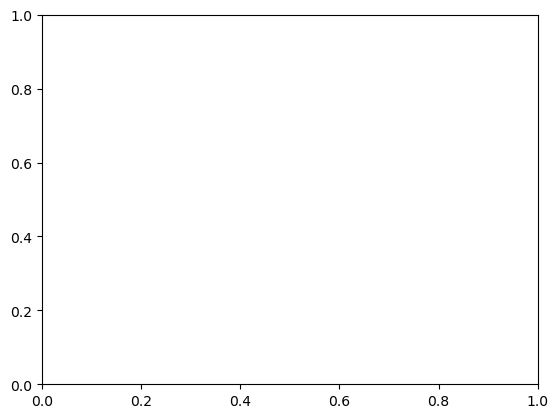

In [13]:
fig, ax = plt.subplots(1,1)
cmap = plt.cm.jet

img3 = ax.imshow(np.transpose(np.flipud(np.transpose(u_pred.reshape(500,500)))),vmin = 0,vmax = 1000,cmap = cmap,extent=[0,1,0,1],aspect = 0.75)


In [14]:
import scipy.io as sio
import numpy as np

for tune_reps in range(75):
    label = "MW_rowdy_tune"+str(tune_reps)+".mat"
    data = sio.loadmat(label)
    re = np.array(data["test_re_loss"])
    print(tune_reps," ",np.mean(re[:,-1]))

0   [[nan]]
1   [[nan]]
2   [[0.94827328        nan]]
3   [[nan]]
4   [[nan]]
5   [[nan]]
6   0.21369630313373836
7   [[nan]]
8   [[nan]]
9   [[nan]]
10   [[nan]]
11   nan
12   [[0.81591382        nan]]
13   nan
14   [[nan]]
15   [[nan]]
16   [[nan]]
17   nan
18   [[nan]]
19   nan
20   [[0.95762257 0.71060336        nan]]
21   [[0.80588063        nan]]
22   nan
23   [[0.93114631        nan]]
24   [[nan]]
25   [[0.97032202        nan]]
26   0.24526258067911674
27   0.21177007318112961
28   nan
29   [[nan]]
30   [[nan]]
31   0.20753383980174908
32   [[nan]]
33   [[nan]]
34   [[0.99861513        nan]]
35   [[nan]]
36   [[nan]]
37   [[nan]]
38   nan
39   [[0.98182751 0.93318346 0.89967899 0.86705134 0.80269023 0.65454279
         nan]]
40   [[nan]]
41   nan
42   nan
43   [[nan]]
44   [[nan]]
45   nan
46   nan
47   nan
48   [[nan]]
49   [[0.99985655        nan]]
50   [[nan]]
51   [[0.98043768 0.9667451  0.93276731        nan]]
52   [[0.992191   0.97897141 0.95492784 0.92830991 0.87812537 0.

In [5]:
lrnr_tune[27]

array([0.05, 5.  , 6.  ])